In [1]:
from ensembles import VanillaEnsemble
from datasets import make_dataset, make_cross_validation_dataset
from plot import plot_dataset, plot_prediction, train_and_plot, plot_error
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16, 4]
from evaluation import evaluate_model
import tensorflow as tf

from tqdm import tqdm


# Explanation



Showing the efficiency of two estimators, comparing to a vanialla Neural Network.

All Estimators are built in tensorflow (1.4 [*]) and are based on the same parent object (ToDo: Make this more beautiful and readable). Code can be found in /estimators.

GaussianLossEstimator [1], in which $\mu$ and $\sigma^2$ are estimated directly by using a gaussian cost function $-1/2 ln [\sigma^2(x_i)] - \frac{[y-\hat{y}]^2}{2\sigma^2(x_i)} $. In practice, this means separate output nodes have been added for both mean and variance, with corrensponding final layers. To ensure positive $\sigma^2$, a softmax function is applied according to [2]. The derivatives used for the backwards pass update can be found in [1], thanks to Tensorflows Automatic Differentiation, the author was spared implementing a working function of this [4].

GaussianLearningRateEstimator, which is a GaussianLossEstimator in which the predicted $\sigma$ is used to scale the learning rate for each sample. This approach hasn't been found in a [arguable somewhat shallow] literature review. It's too early to claim novelty, but it is fun to work with!

For both models, a minimum variance is returned if the variance goes below a certain threshold to (try to) avoid numerical instabilities


No Regularisation has been added, thus quite a bit of overfitting occurs.







# Parameters
parameters have been chosen at 'random', i.e. not much thought has been put into them. No Gridsearch for optimal parameter spaces or similar.

each neural network is contains three hidden layers with 10 neurons each, the learning rate has been set to 0.001 which seems a literature standard (cite needed)

The layers are instantiated by draws from a normal distribution (0,1), so no distribution over parameters


# Dataset 
The Dataset contains 100 samples generated by the function 

$5 \cdot sin(X) + 10 + X^2 + noise$

where X is linearly spaced patches in the intervall [-5,5] the noise is drawn from a normal distribution (0,4)

# Training
Each network is trained on 10 * 100 = 1000 epochs

Training is on-line, i.e. each sample is fed into the network on a singular basis (Stochastic gradient descent with batch size 1)

The optimizer is the standard implementation of tensorflow's tf.train.GradientDescentOptimizer 


# Evaluation
Right now, the RSME and the coverage probability of the prediction is reported, where the data is available (i.e. VanillaNetwork does not return uncertainty = no Coverage). At the moment, evaluation happens on the training set (because the data generating model is a bit annoying to work with because of quite frankly a bit of a stupid shuffling situation, which is on the ToDo list)


# Problems/ToDo
Weirdly, the standard GaussianLossEstimator tends to fall into numerical instabilities (see e.g. seed #forgottowritedowntheseedandIfeelbad (1011???))

Overfitting is locally SEVERE sometimes (e.g. seed 43). Why.

Adding SOME Regularisation might be cool: The learning rate thing looks like a perfect fit for early stopping

Hyperparameters need to be tuned

Evaluation on training set (alas only to make a point about uncertainty so maybe can be forgiven in this phase)

Learningrate scaling in GaussianLearningRateEstimator is absolutely eyeballed and not based on any evidence at all except for the fact that 'I've seeb people use square roots in combination with the standard deviation/variance'.


Implement Dropout Estimator from [3] and give it the whole routine




# Sources

[1] Nix, D. A., & Weigend, A. S. (1994, June). Estimating the mean and variance of the target probability distribution. In Neural Networks, 1994. IEEE World Congress on Computational Intelligence., 1994 IEEE International Conference On (Vol. 1, pp. 55-60). IEEE.
Chicago	
Link: http://ieeexplore.ieee.org/abstract/document/374138/


[2] Lakshminarayanan, B., Pritzel, A., & Blundell, C. (2017). Simple and scalable predictive uncertainty estimation using deep ensembles. In Advances in Neural Information Processing Systems (pp. 6405-6416).
Chicago	

Link: https://arxiv.org/abs/1612.01474

[3] Gal, Y., & Ghahramani, Z. (2016, June). Dropout as a Bayesian approximation: Representing model uncertainty in deep learning. In international conference on machine learning (pp. 1050-1059).

Link: http://proceedings.mlr.press/v48/gal16.html

[4] Huxley, Aldous. Brave New World. New York: Harper Brothers, 1932. Print. 


[*] BIG shoutout to https://danijar.com/structuring-your-tensorflow-models/ for helping me understand how to use Tensorflow in an object oriented manner


# Preparations

In [2]:
num_epochs = 10
num_eps = 75#25#75
#seed = 43#43 is cool 101 1011
from global_vars import SEED as seed

params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}
          #'optimizer':tf.train.AdamOptimizer}


In [3]:

data = make_dataset(train_p=0.8,seed=seed)

X = data['X']
y = data['y']
X_test = data['X_test']
y_test = data['y_test']
generate_sinoid = data['generating']
#sorted_index = data['train_index']
sorted_index = data['shuffle_index']
#test_index = data['test_ind']

In [4]:
#X_test[:10],X[:10]

In [5]:
#len(X), len(sorted_index),len(data['test_ind']),len(X_test)

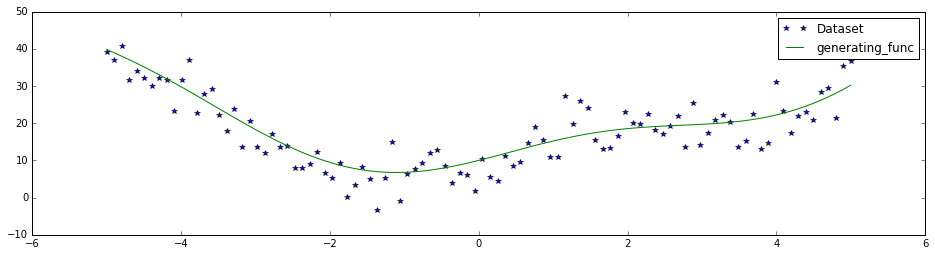

In [6]:
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

# initialise Networks

In [7]:
from estimators import GaussianLossEstimator,GaussianLearningRateEstimator, EnsembleNetwork

gauss = GaussianLossEstimator(**params)
gauss_lr = GaussianLearningRateEstimator(**params)
vanilla = EnsembleNetwork(**params)

In [8]:
gauss_preds = gauss.predict(X)
gauss_var = gauss.predict_var(X)


lr_preds = gauss_lr.predict(X)
lr_var = gauss_lr.predict_var(X)

vanilla_preds = vanilla.predict(X)

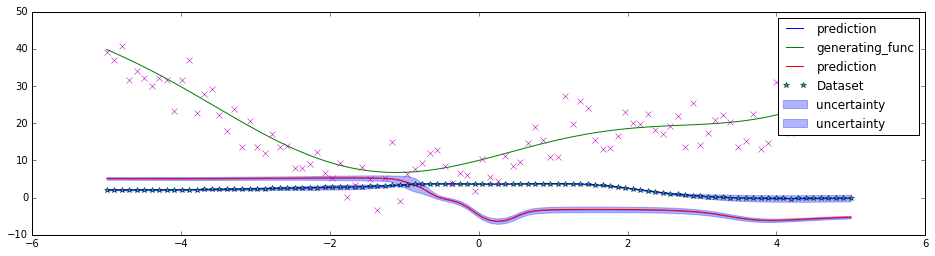

In [9]:
plot_prediction(X,
                gauss_preds,
                sorted_index,
                gauss_var,
                generating_func=generate_sinoid)
plot_prediction(X,
                lr_preds,
                sorted_index,
                lr_var)
plot_prediction(X,vanilla_preds,sorted_index)
plt.plot(X,y,'x')

In [10]:
evaluate_model(X,y,gauss_preds)

RSME is 18.59027862548828


In [11]:
evaluate_model(X,y,lr_preds)

RSME is 20.771207809448242


In [12]:
evaluate_model(X,y,vanilla_preds)

RSME is 18.59027862548828


# Training


## GaussianLossEstimator

Maye replace min_variance with 

In [13]:
num_eps

75

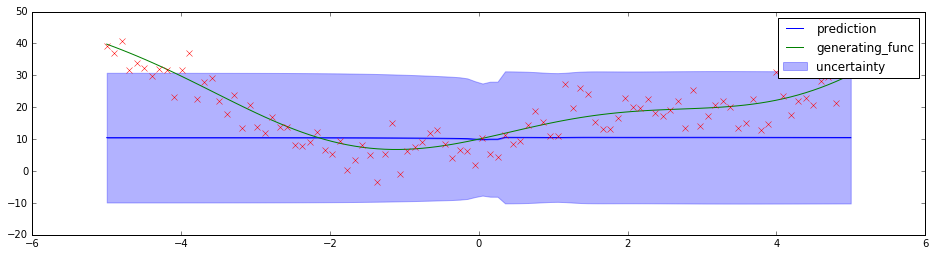

RSME is 12.005192756652832
COVERAGE PROBABILITY is 0.88
MEAN VARIANCE is 20.28429412841797
COVERAGE/MEAN_VAR is 0.04338331885885712
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.17680261, 0.078460673118294036)


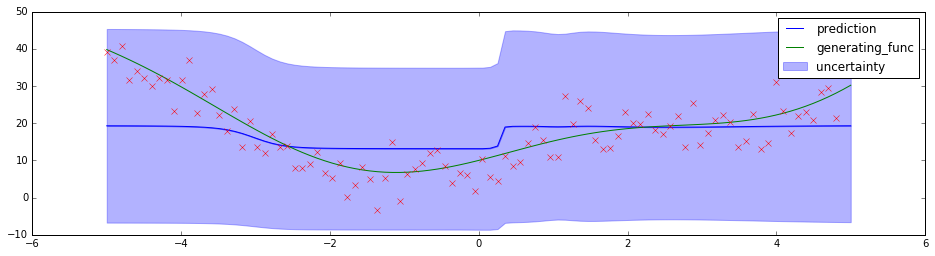

RSME is 8.047194480895996
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 24.280410766601562
COVERAGE/MEAN_VAR is 0.04118546467819771
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.20592666, 0.039834432469792215)


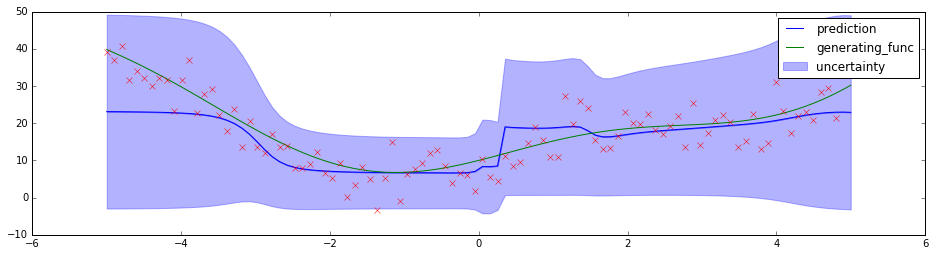

RSME is 6.0949554443359375
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 17.520322799682617
COVERAGE/MEAN_VAR is 0.056505808215927045
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.44848514, 2.8756511565926077e-06)


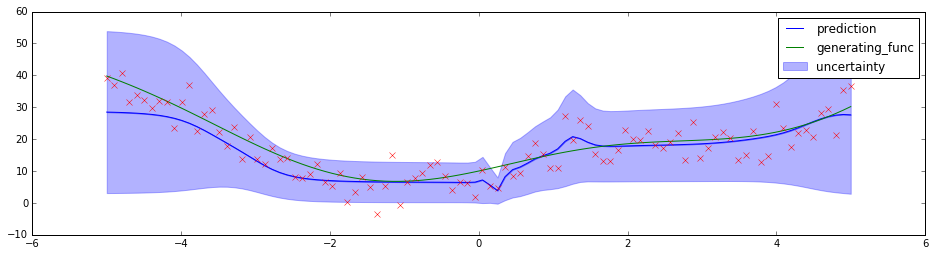

RSME is 4.793990135192871
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 12.703922271728516
COVERAGE/MEAN_VAR is 0.07556721298086003
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.36772096, 0.00016739143264012636)


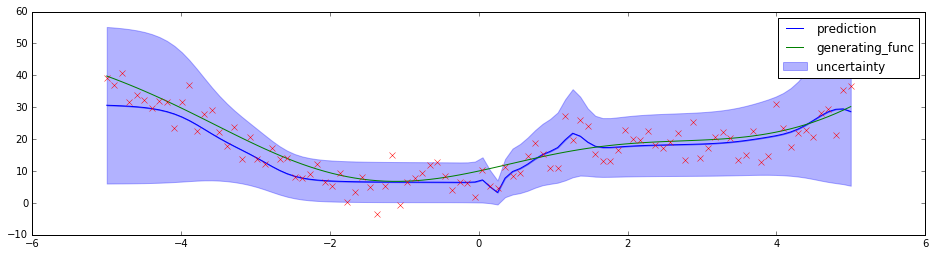

RSME is 4.490915298461914
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 11.555110931396484
COVERAGE/MEAN_VAR is 0.08308011975822545
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.266471, 0.0073656183229785822)


In [14]:
errors = train_and_plot(gauss,X,y,sorted_index,generating_func=generate_sinoid,
               num_eps=num_eps)

In [15]:
#plot_error(errors)

gauss_error_list = []
#for i in tqdm(range(num_eps)):
for i in range(num_eps):
    #gauss.train(X,y)
    errors = gauss.train_and_evaluate(X,y)
    gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        gauss_preds = gauss.predict(X)
        gauss_var = gauss.predict_var(X)

        #lr_preds = gauss_lr.predict(X)
        #lr_var = gauss_lr.predict_var(X)

        #vanilla_preds = vanilla.predict(X)
        plot_prediction(X,gauss_preds,sorted_index,gauss_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,gauss_preds,var=gauss_var)
#plt.show()

## GaussianLearningRateEstimator

gauss_lr_error_list = []
for i in range(num_eps):
    errors = gauss_lr.train_and_evaluate(X,y)
    gauss_lr_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        gauss_preds = gauss_lr.predict(X)
        gauss_var = gauss_lr.predict_var(X)

        #3lr_preds = gauss_lr.predict(X)
        #lr_var = gauss_lr.predict_var(X)

        #vanilla_preds = vanilla.predict(X)
        plot_prediction(X,gauss_preds,sorted_index,gauss_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,gauss_preds,var=gauss_var)

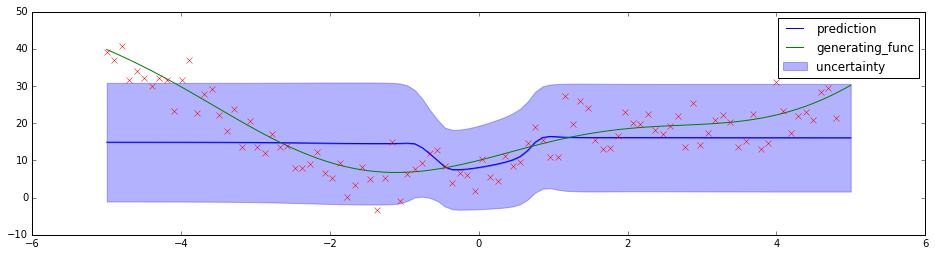

RSME is 9.452364921569824
COVERAGE PROBABILITY is 0.86
MEAN VARIANCE is 14.692195892333984
COVERAGE/MEAN_VAR is 0.05853447682716552
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.36303562, 0.00020546641705405011)


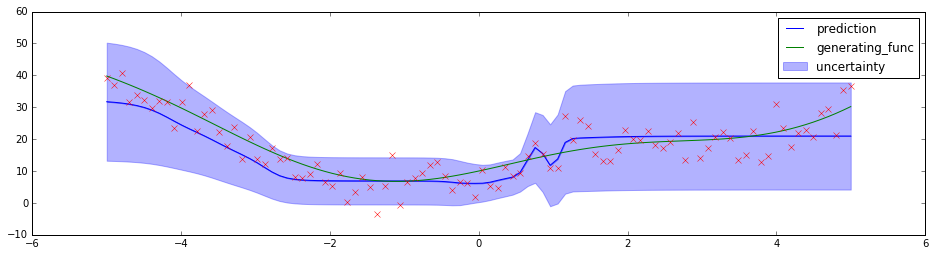

RSME is 5.169454097747803
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 12.599356651306152
COVERAGE/MEAN_VAR is 0.07619436663065479
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.19087824, 0.057130084222504852)


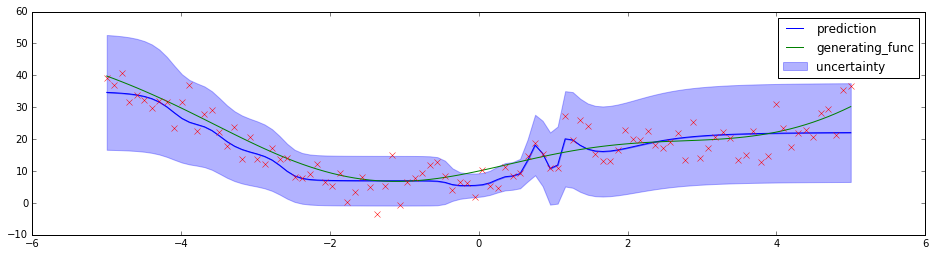

RSME is 4.621809482574463
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 11.806192398071289
COVERAGE/MEAN_VAR is 0.08216027380330201
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.18866742, 0.060125262221838983)


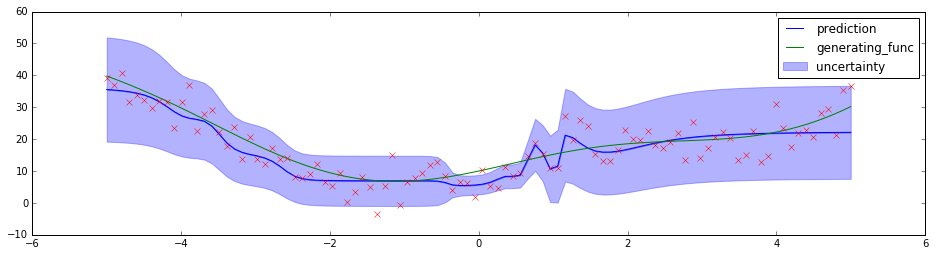

RSME is 4.529613971710205
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 11.07836627960205
COVERAGE/MEAN_VAR is 0.08575271624203105
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.19760865, 0.048755787027392403)


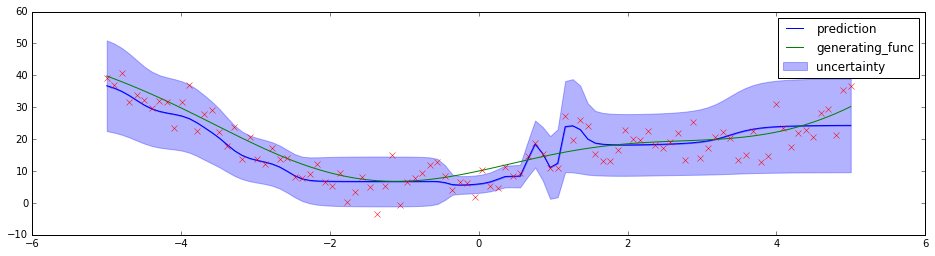

RSME is 4.43308687210083
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 9.560568809509277
COVERAGE/MEAN_VAR is 0.10041243561211026
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.28565624, 0.0039649957929178085)


In [16]:
errors = train_and_plot(gauss_lr,X,y,sorted_index,generating_func=generate_sinoid,
               num_eps=num_eps)

In [17]:
#plot_error(errors)

## Vanilla Neural Network for comparisson

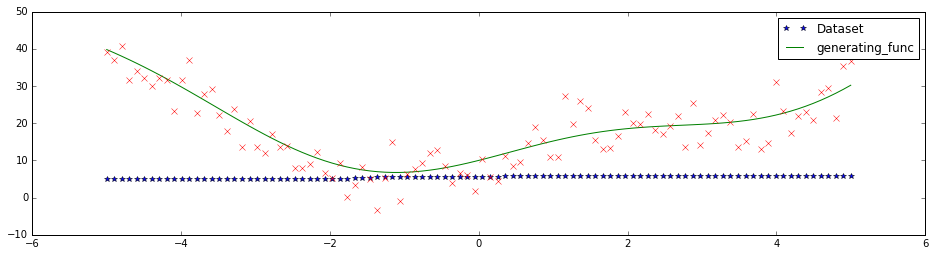

RSME is 15.525585174560547


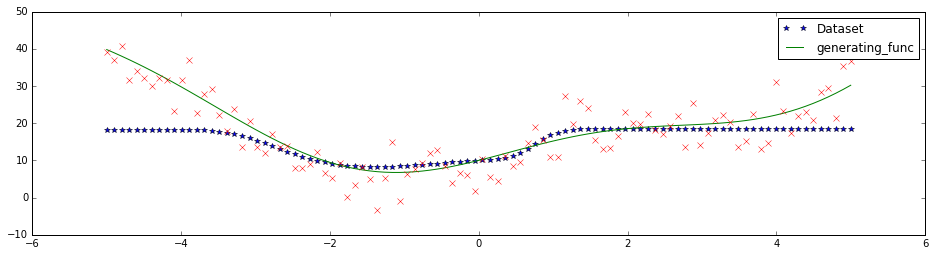

RSME is 7.516425132751465


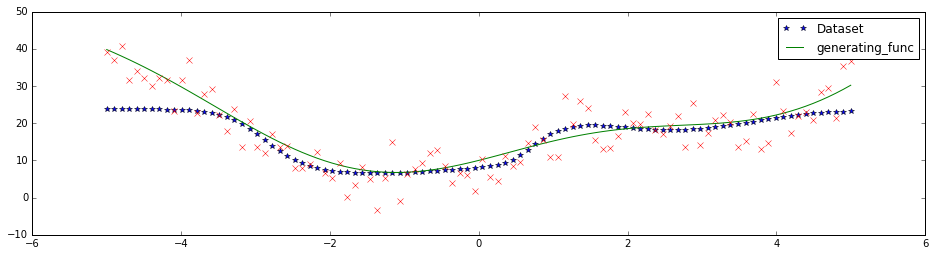

RSME is 5.681178092956543


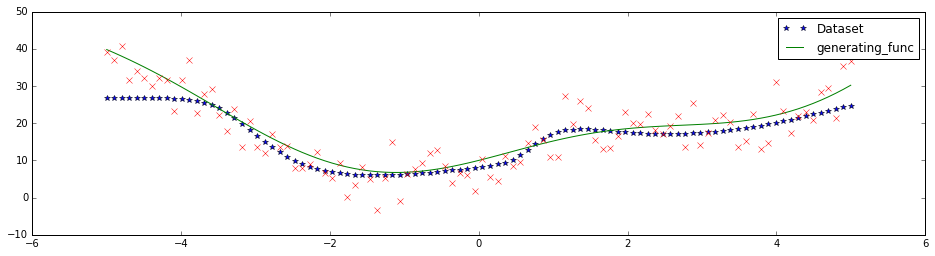

RSME is 5.061280250549316


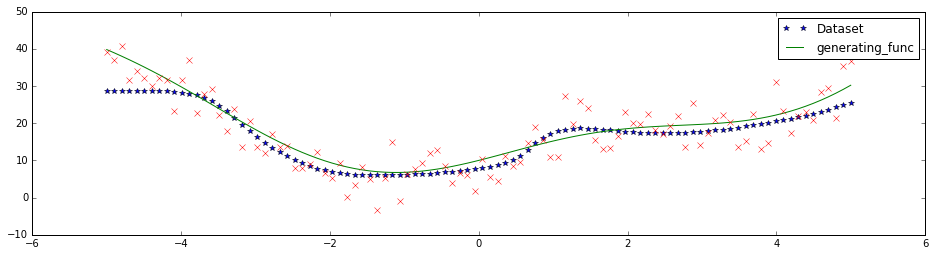

RSME is 4.74670934677124


In [18]:
vanilla_errors = []
for i in range(num_eps):

    vanilla.train(X,y)
    if i%(num_eps/5) ==0:


        vanilla_preds = vanilla.predict(X)
        plot_prediction(X,vanilla_preds,sorted_index,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,vanilla_preds)

# Dropout

In [19]:
from dropout import DropoutNetwork

In [20]:
dropout = DropoutNetwork()

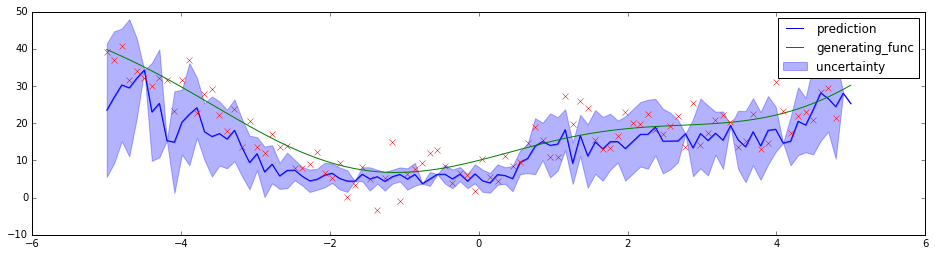

RSME is 6.280197620391846
COVERAGE PROBABILITY is 0.62
MEAN VARIANCE is 6.2083516120910645
COVERAGE/MEAN_VAR is 0.09986547778520148
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.18710281, 0.062321467834885388)


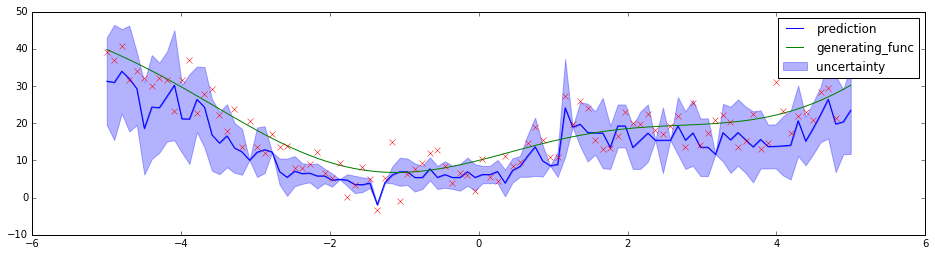

RSME is 5.907729625701904
COVERAGE PROBABILITY is 0.65
MEAN VARIANCE is 6.158646106719971
COVERAGE/MEAN_VAR is 0.1055426775197809
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.24971823, 0.012223780737682264)


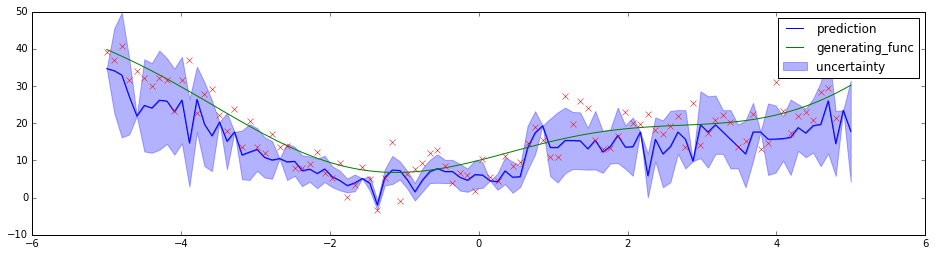

RSME is 6.366797924041748
COVERAGE PROBABILITY is 0.62
MEAN VARIANCE is 5.901104927062988
COVERAGE/MEAN_VAR is 0.10506506962054263
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.21226373, 0.033991367678881793)


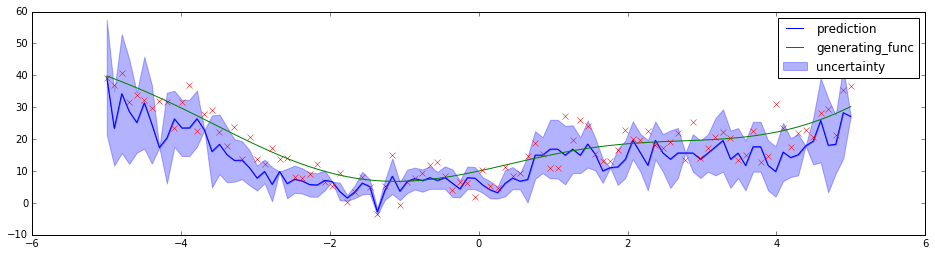

RSME is 6.194167137145996
COVERAGE PROBABILITY is 0.65
MEAN VARIANCE is 6.1924238204956055
COVERAGE/MEAN_VAR is 0.10496697558856329
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.19456521, 0.052407567079257852)


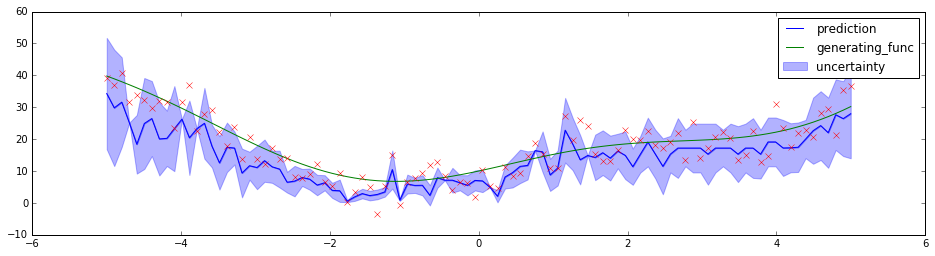

RSME is 5.632197380065918
COVERAGE PROBABILITY is 0.65
MEAN VARIANCE is 6.2253546714782715
COVERAGE/MEAN_VAR is 0.10441172178960387
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.30271992, 0.0022037278990728231)


In [21]:
errors = train_and_plot(dropout,X,y,sorted_index,generating_func=generate_sinoid,
               num_eps=num_eps)

# loop over experiment forever

In [22]:

def plot_error_tmp(error_list, variance_list=False):
    if len(variance_list) > 0:
        diff = error_list - variance_list
        sum_ = error_list + variance_list
        X = np.linspace(0, len(error_list), len(error_list))
        plt.plot()
        plt.xlim = 50
        plt.fill_between(X, error_list, diff, alpha=.3,
                         color='b')
        plt.fill_between(X, error_list, sum_, alpha=.3,
                         color='b')
        #plt.plot(X,error_list)
        plt.xlim = 50
        plt.show()

        
    else:
        plt.plot(np.squeeze(error_list))
        
        
def plottt(error_list):
    plt.plot(np.squeeze(error_list))

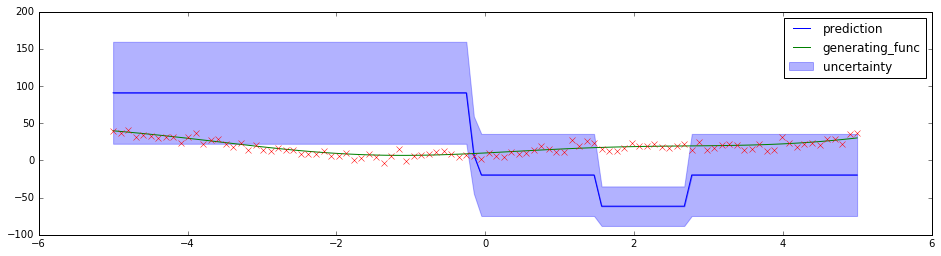

RSME is 63.683773040771484
COVERAGE PROBABILITY is 0.55
MEAN VARIANCE is 58.101192474365234
COVERAGE/MEAN_VAR is 0.009466242887229293
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.066068538, 0.51369629837387931)


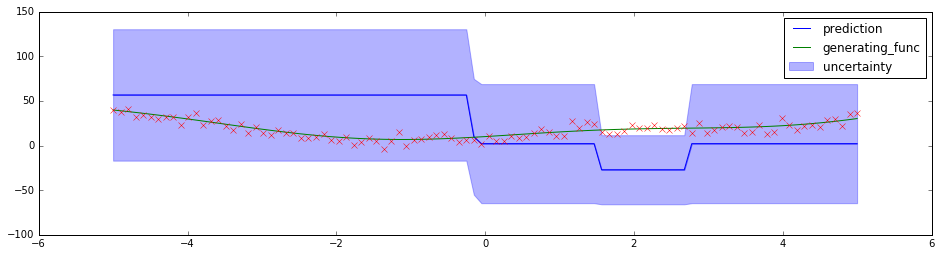

RSME is 34.75828552246094
COVERAGE PROBABILITY is 0.88
MEAN VARIANCE is 66.63505554199219
COVERAGE/MEAN_VAR is 0.013206261971905166
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.11293438, 0.26325597215146279)


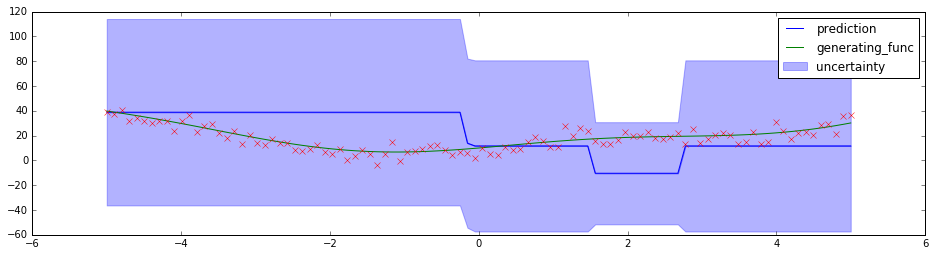

RSME is 21.075666427612305
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 68.62162780761719
COVERAGE/MEAN_VAR is 0.01457266509042208
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.16407412, 0.10285071240201804)


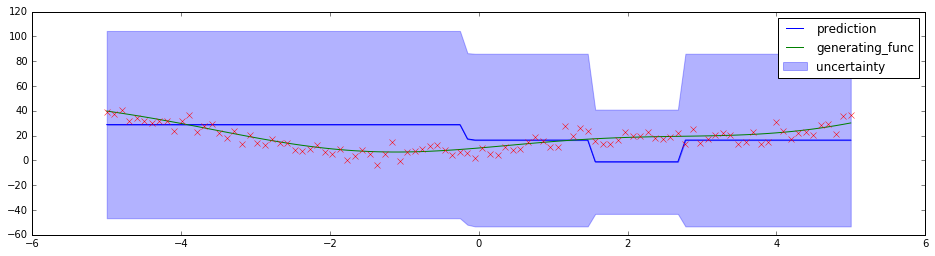

RSME is 14.543099403381348
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 69.1328353881836
COVERAGE/MEAN_VAR is 0.014464906500434426
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.16191575, 0.10752019220023136)


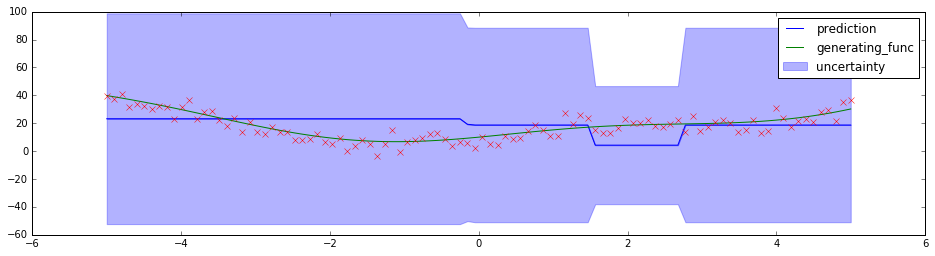

RSME is 11.762190818786621
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 69.2126693725586
COVERAGE/MEAN_VAR is 0.014448221822181006
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.083746515, 0.40744812749593873)


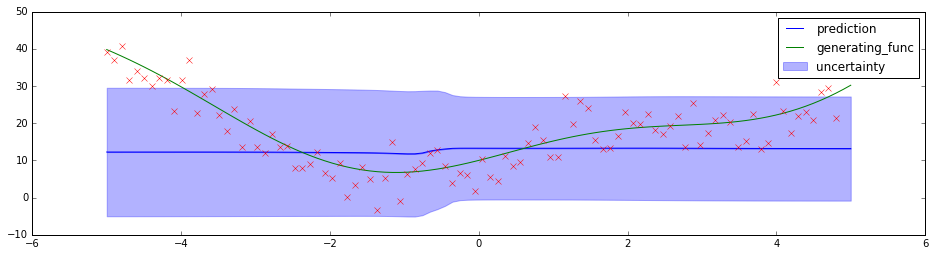

RSME is 10.837305068969727
COVERAGE PROBABILITY is 0.83
MEAN VARIANCE is 15.357295036315918
COVERAGE/MEAN_VAR is 0.05404597606787333
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.30051631, 0.002382102527211927)


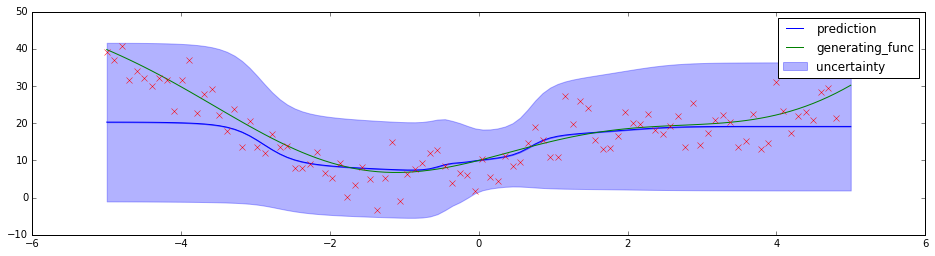

RSME is 6.9320831298828125
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 15.687505722045898
COVERAGE/MEAN_VAR is 0.06310754670251609
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.4503347, 2.5868325089262197e-06)


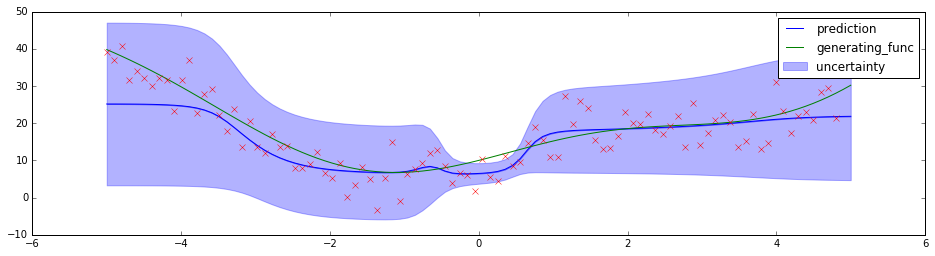

RSME is 5.492574691772461
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 13.445871353149414
COVERAGE/MEAN_VAR is 0.07214110372793339
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.41466367, 1.792724958992801e-05)


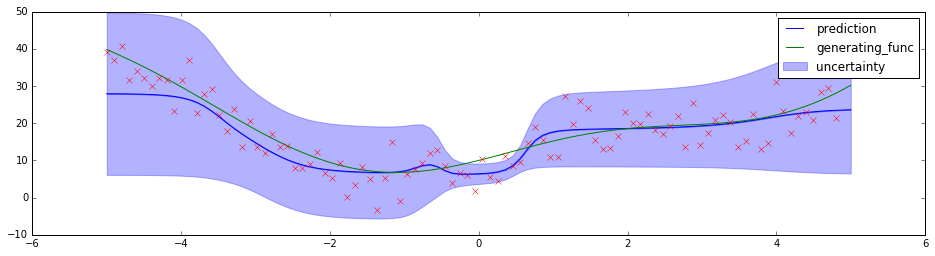

RSME is 4.932518482208252
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 12.555063247680664
COVERAGE/MEAN_VAR is 0.07725966654761306
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.35029495, 0.00035317106351492731)


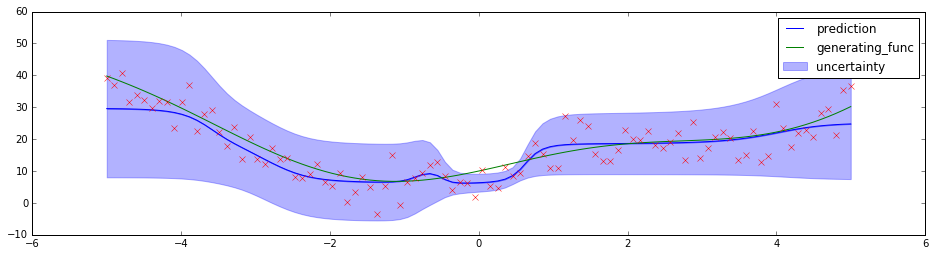

RSME is 4.664958477020264
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 12.047088623046875
COVERAGE/MEAN_VAR is 0.0805173789577945
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.30126339, 0.0023202213880103898)


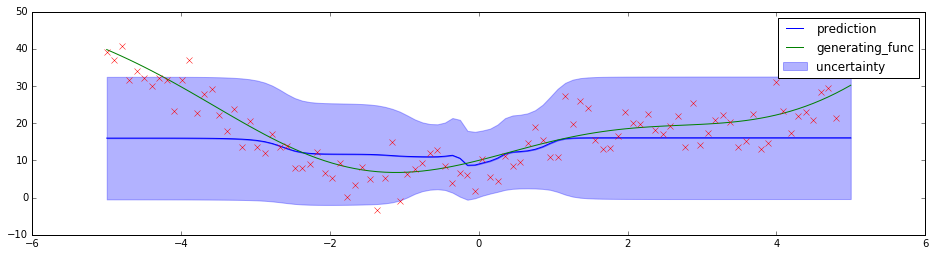

RSME is 8.813766479492188
COVERAGE PROBABILITY is 0.91
MEAN VARIANCE is 14.563756942749023
COVERAGE/MEAN_VAR is 0.062483877173813256
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.29574668, 0.0028134792928878305)


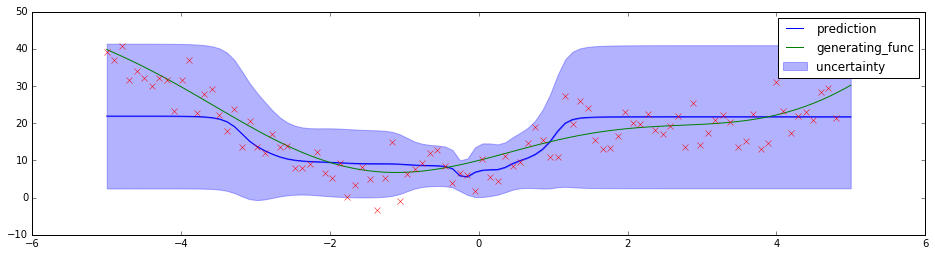

RSME is 6.422495365142822
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 14.733019828796387
COVERAGE/MEAN_VAR is 0.06651725249731515
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.30520472, 0.0020171192811760303)


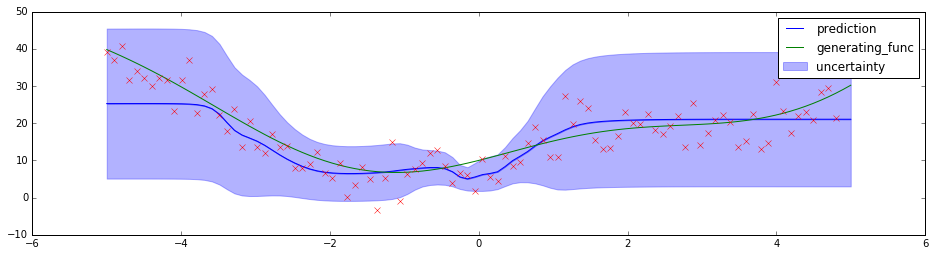

RSME is 5.542265892028809
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 13.964949607849121
COVERAGE/MEAN_VAR is 0.06874353484672968
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.31670073, 0.0013262093314839547)


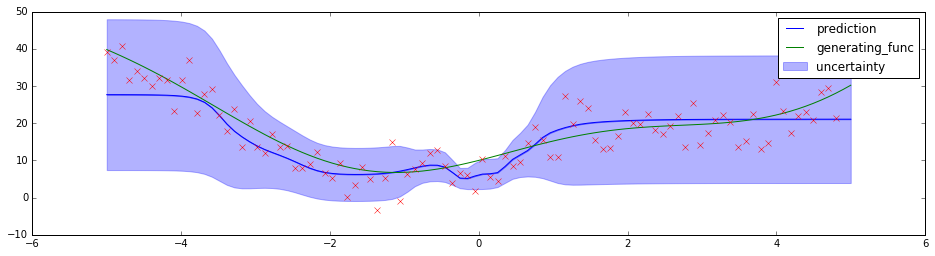

RSME is 5.176938056945801
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 13.169116020202637
COVERAGE/MEAN_VAR is 0.07213847904009749
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.29144076, 0.0032619219397290872)


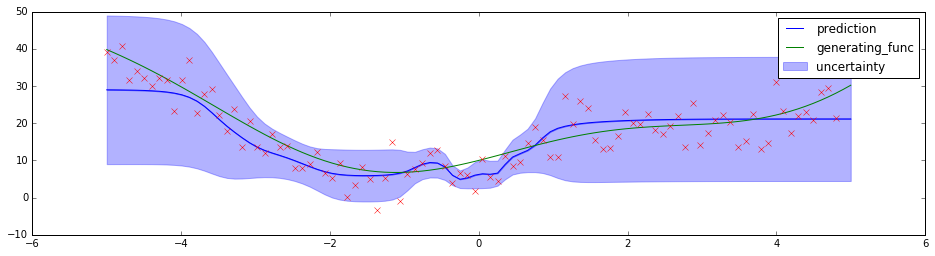

RSME is 5.051754951477051
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 12.287503242492676
COVERAGE/MEAN_VAR is 0.07731432344324496
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.2932938, 0.0030616186189124368)


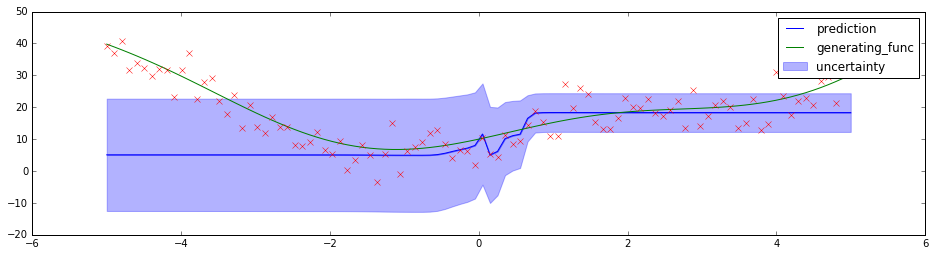

RSME is 12.269364356994629
COVERAGE PROBABILITY is 0.75
MEAN VARIANCE is 12.249189376831055
COVERAGE/MEAN_VAR is 0.06122854149178236
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.38735461, 6.8497522483427269e-05)


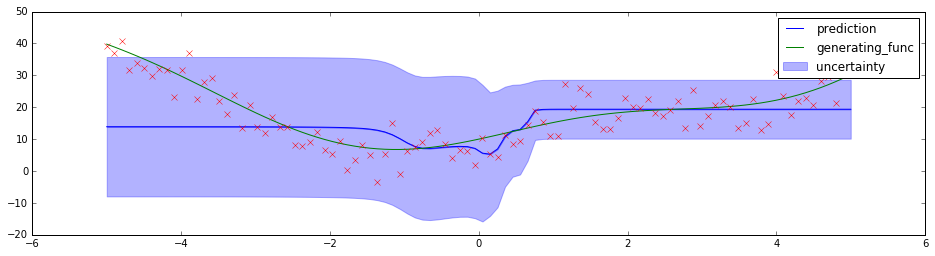

RSME is 9.130149841308594
COVERAGE PROBABILITY is 0.92
MEAN VARIANCE is 16.099267959594727
COVERAGE/MEAN_VAR is 0.057145455452321046
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.316037, 0.0013593236656448343)


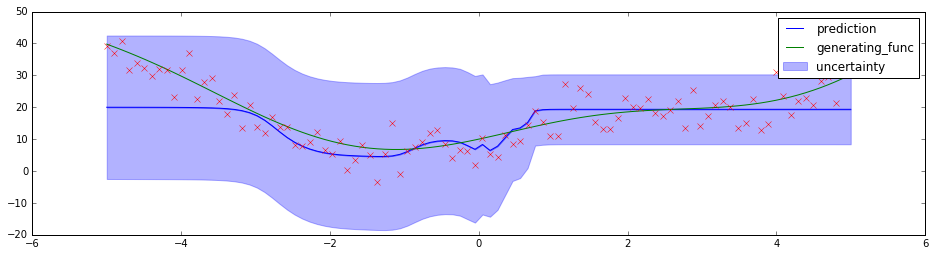

RSME is 6.846124172210693
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 17.36842918395996
COVERAGE/MEAN_VAR is 0.0558484587020576
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.12198768, 0.2266393058061007)


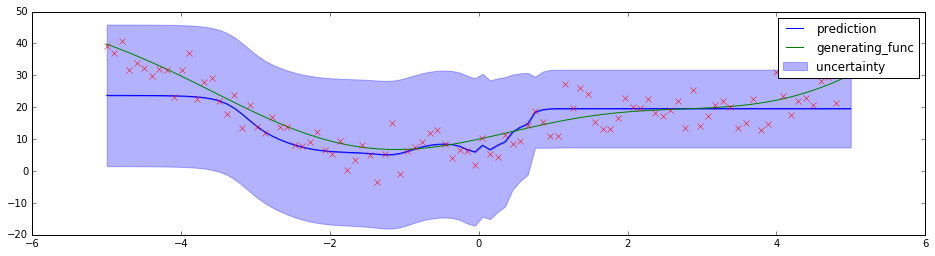

RSME is 5.9815897941589355
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 17.917034149169922
COVERAGE/MEAN_VAR is 0.054696552556685415
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.0043471851, 0.96576092217678278)


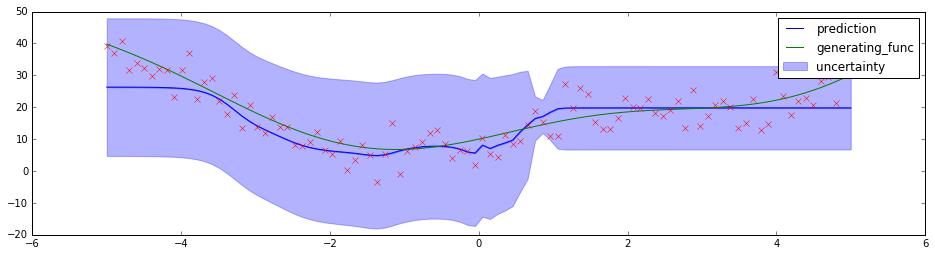

RSME is 5.424031734466553
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 17.96916389465332
COVERAGE/MEAN_VAR is 0.054537874201904105
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.091163024, 0.36703084441945077)


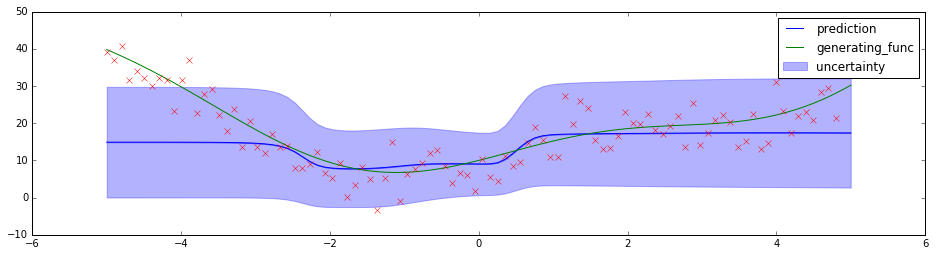

RSME is 8.647706031799316
COVERAGE PROBABILITY is 0.86
MEAN VARIANCE is 13.049386978149414
COVERAGE/MEAN_VAR is 0.06590347894809385
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.34458837, 0.00044688273511925384)


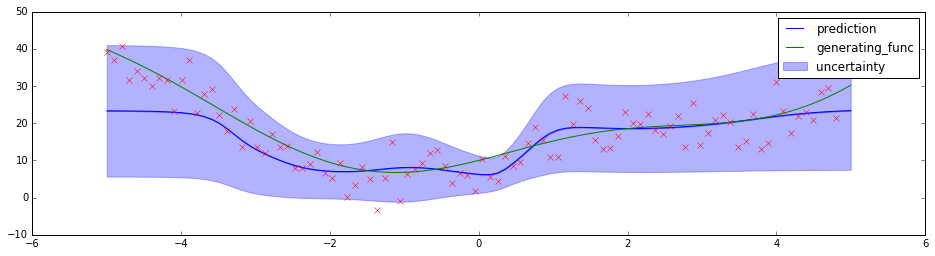

RSME is 5.877381324768066
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 11.705799102783203
COVERAGE/MEAN_VAR is 0.08457346579308839
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.48307219, 3.5723520466068179e-07)


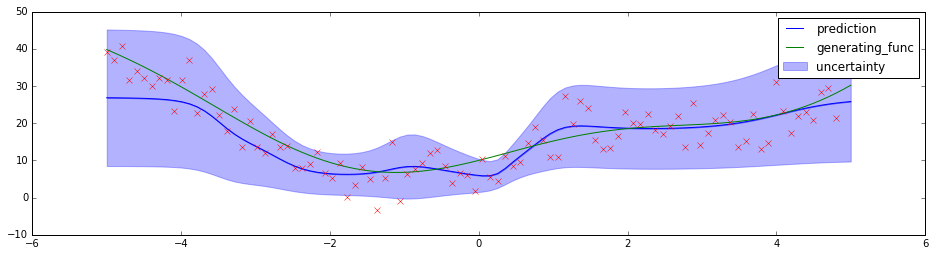

RSME is 5.065303325653076
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 10.85569953918457
COVERAGE/MEAN_VAR is 0.0884328086398116
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.41760373, 1.5408479673628592e-05)


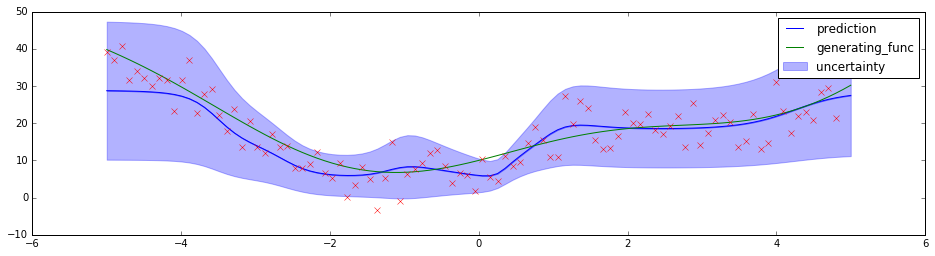

RSME is 4.694718360900879
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 10.556434631347656
COVERAGE/MEAN_VAR is 0.09093979487631652
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.34737882, 0.00039852518578602128)


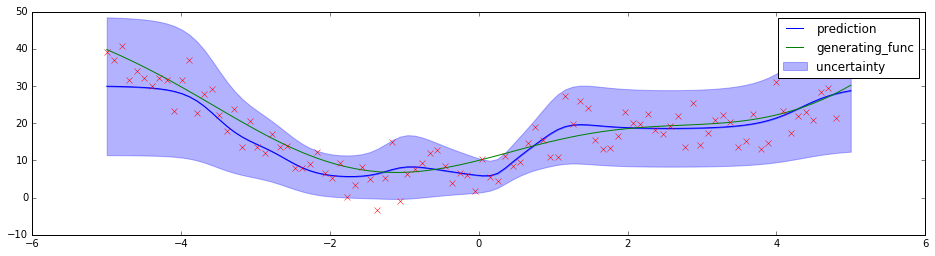

RSME is 4.501614570617676
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 10.387160301208496
COVERAGE/MEAN_VAR is 0.09338452203218094
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.29399025, 0.0029892395245394569)


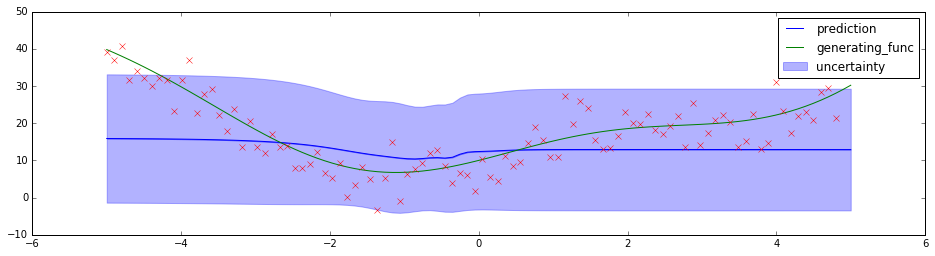

RSME is 9.865461349487305
COVERAGE PROBABILITY is 0.9
MEAN VARIANCE is 16.137798309326172
COVERAGE/MEAN_VAR is 0.05576968944269692
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.3568815, 0.00026766971974718265)


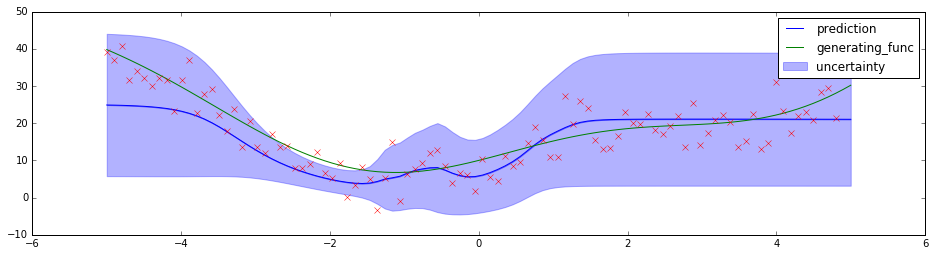

RSME is 5.868871688842773
COVERAGE PROBABILITY is 0.92
MEAN VARIANCE is 13.5571928024292
COVERAGE/MEAN_VAR is 0.06786065621454856
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.30847955, 0.0017930059245994077)


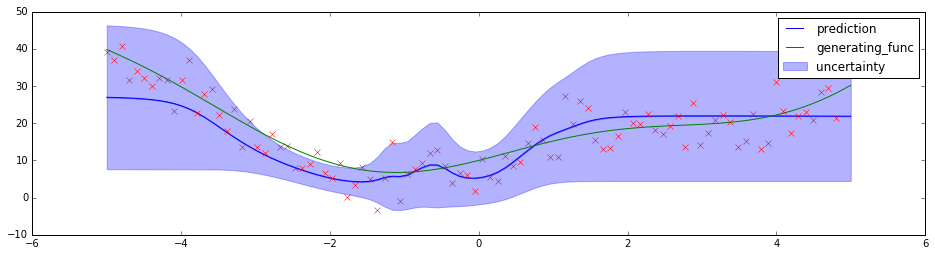

RSME is 5.54949426651001
COVERAGE PROBABILITY is 0.92
MEAN VARIANCE is 12.800479888916016
COVERAGE/MEAN_VAR is 0.07187230541228627
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.3232156, 0.0010379737008934689)


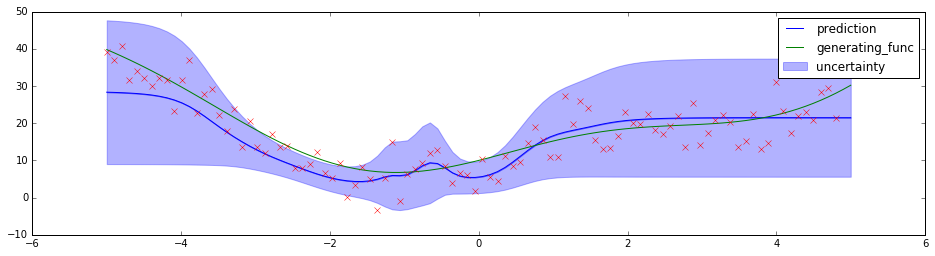

RSME is 5.299671649932861
COVERAGE PROBABILITY is 0.92
MEAN VARIANCE is 11.554494857788086
COVERAGE/MEAN_VAR is 0.07962269327420157
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.31188416, 0.0015841285125177619)


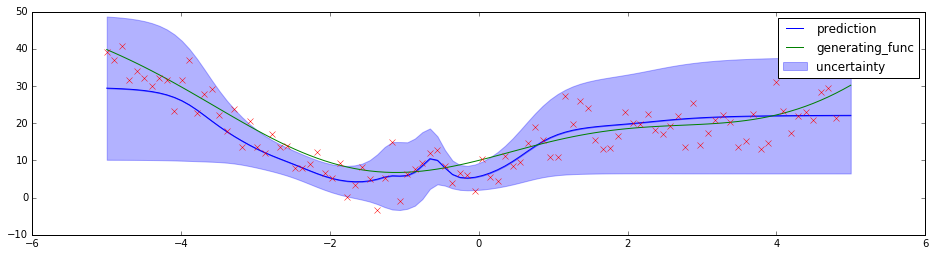

RSME is 5.092563629150391
COVERAGE PROBABILITY is 0.9
MEAN VARIANCE is 10.925084114074707
COVERAGE/MEAN_VAR is 0.08237922844370017
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.31794834, 0.0012659403360926725)


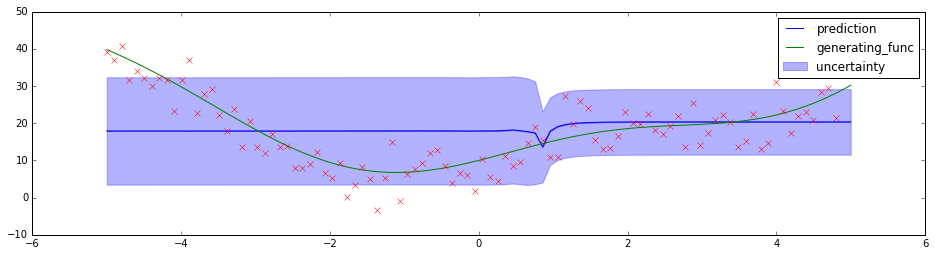

RSME is 9.60228443145752
COVERAGE PROBABILITY is 0.86
MEAN VARIANCE is 12.080484390258789
COVERAGE/MEAN_VAR is 0.07118919839782824
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.43855903, 5.0221348457820586e-06)


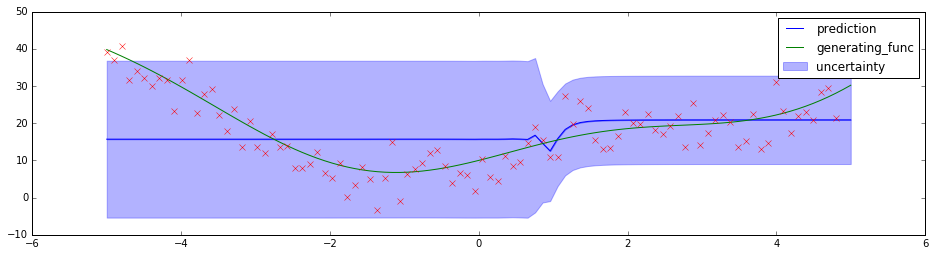

RSME is 9.372101783752441
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 17.288192749023438
COVERAGE/MEAN_VAR is 0.05437236926069661
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.37353531, 0.00012923298559297435)


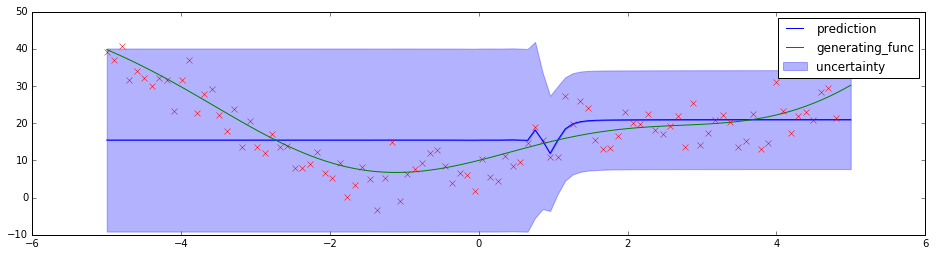

RSME is 9.360795021057129
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 19.943065643310547
COVERAGE/MEAN_VAR is 0.048638459971441984
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.36835817, 0.00016275071827515813)


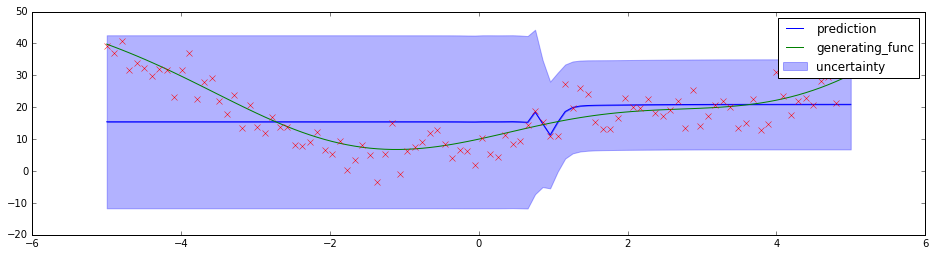

RSME is 9.352120399475098
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 21.75823402404785
COVERAGE/MEAN_VAR is 0.045040420050490984
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.36875603, 0.00015991386175048325)


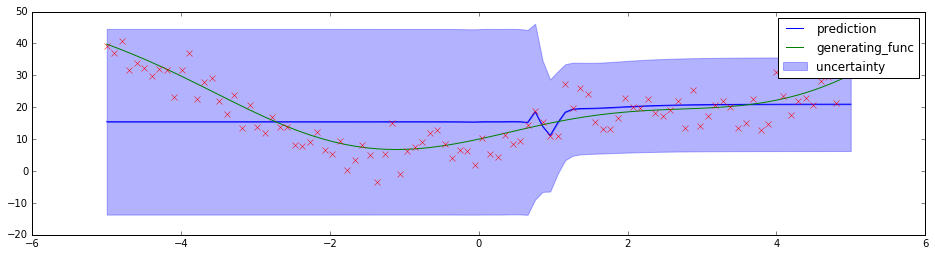

RSME is 9.338708877563477
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 23.097888946533203
COVERAGE/MEAN_VAR is 0.04286105982636091
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.37227228, 0.00013676077219352102)


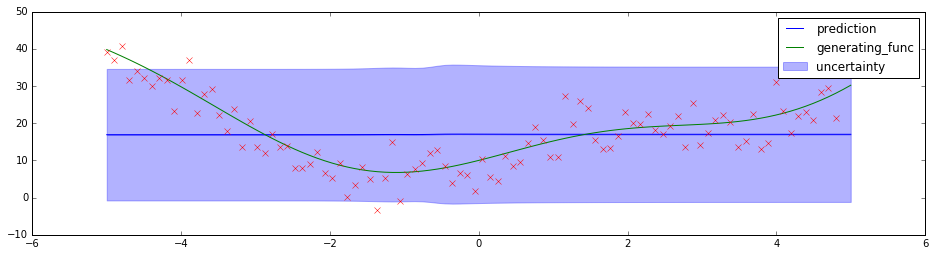

RSME is 9.780667304992676
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 18.043968200683594
COVERAGE/MEAN_VAR is 0.051540769173200336
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.28070837, 0.0046707540294065155)


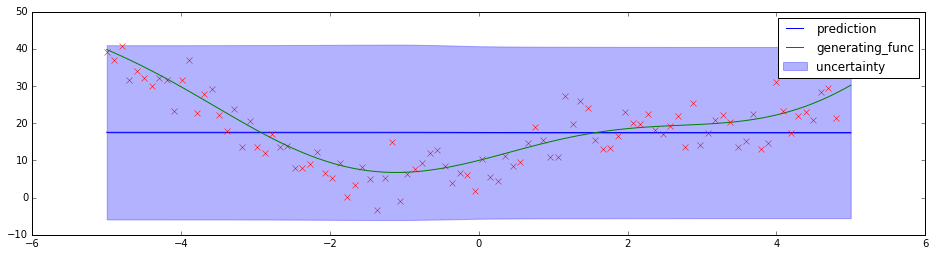

RSME is 9.757671356201172
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 23.252347946166992
COVERAGE/MEAN_VAR is 0.043006409602813635
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.37652412, 0.00011292374409744507)


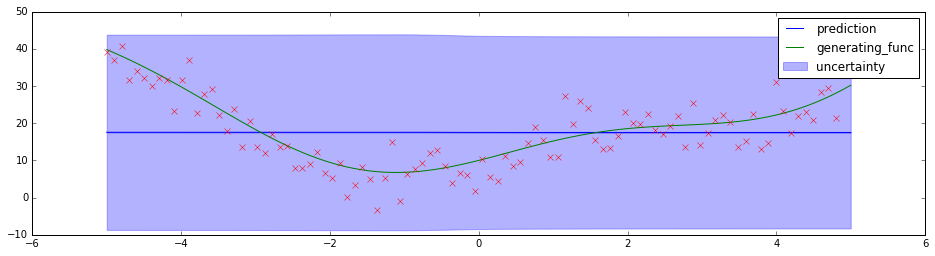

RSME is 9.756409645080566
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 26.047197341918945
COVERAGE/MEAN_VAR is 0.038391846419140625
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.37926012, 9.969044583194622e-05)


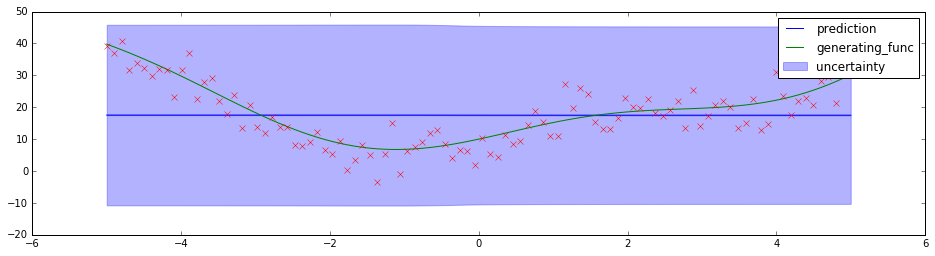

RSME is 9.755786895751953
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 28.08929443359375
COVERAGE/MEAN_VAR is 0.035600751822517734
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.38035399, 9.4815008682280229e-05)


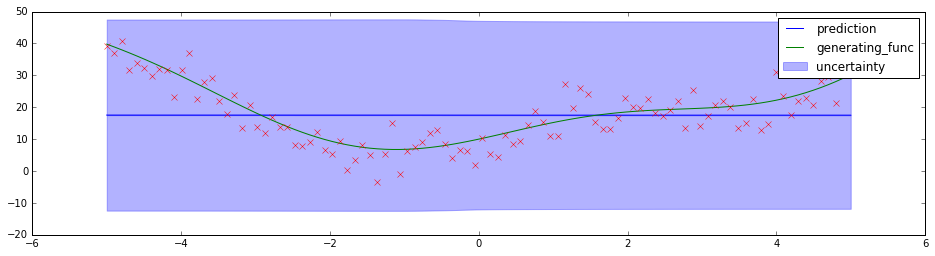

RSME is 9.755176544189453
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 29.686861038208008
COVERAGE/MEAN_VAR is 0.03368493552460685
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.38158485, 8.9594439096039459e-05)


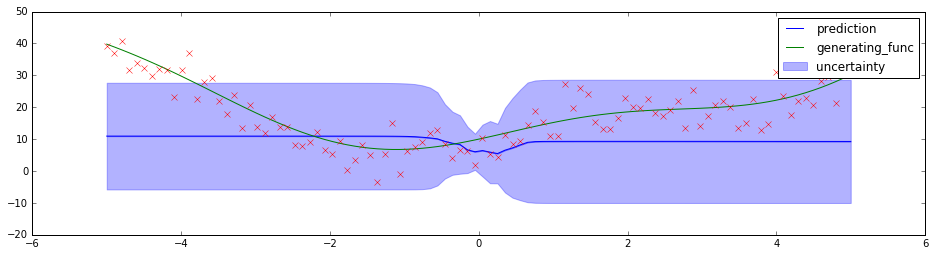

RSME is 12.310972213745117
COVERAGE PROBABILITY is 0.83
MEAN VARIANCE is 17.149063110351562
COVERAGE/MEAN_VAR is 0.04839914546112978
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.18461876, 0.065942119376459302)


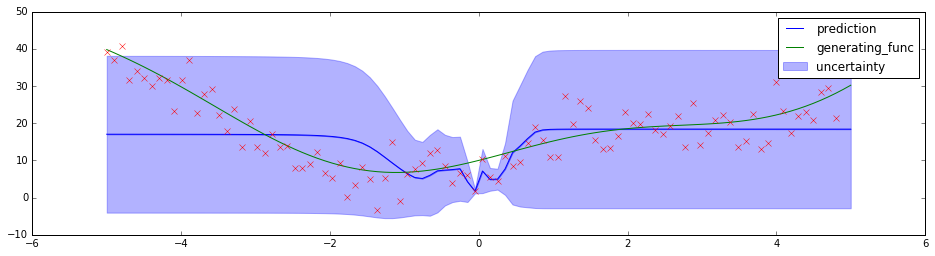

RSME is 8.459178924560547
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 18.7997989654541
COVERAGE/MEAN_VAR is 0.05212821699853366
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.22593504, 0.023805388762057754)


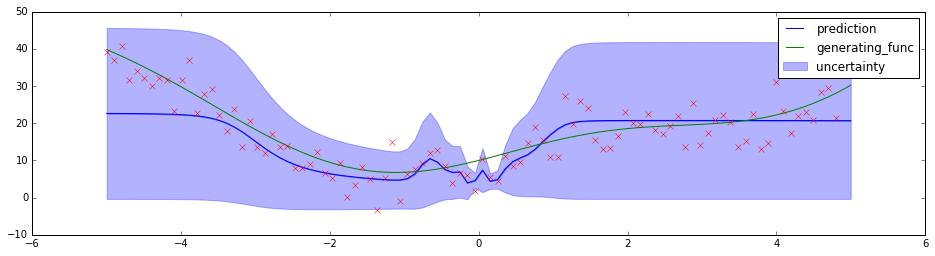

RSME is 6.091503620147705
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 16.632953643798828
COVERAGE/MEAN_VAR is 0.05831796449223194
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.35328606, 0.00031162931178071378)


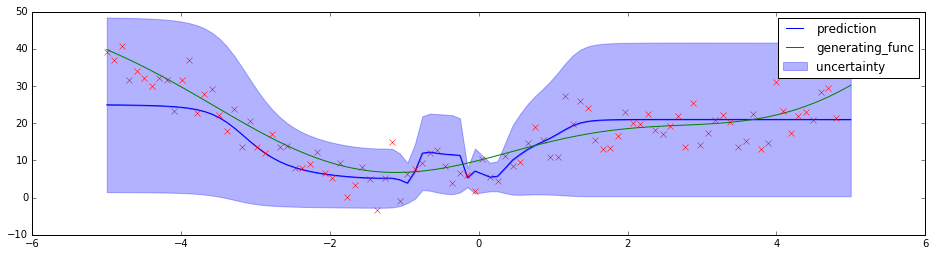

RSME is 5.729672908782959
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 16.294008255004883
COVERAGE/MEAN_VAR is 0.060144808119818045
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.32559237, 0.00094791938839985631)


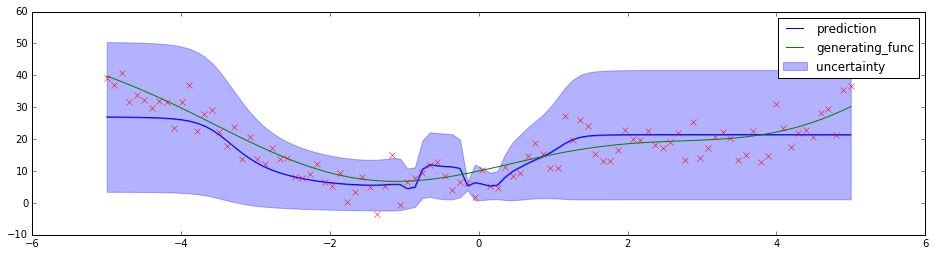

RSME is 5.418939590454102
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 15.866133689880371
COVERAGE/MEAN_VAR is 0.06176678068867256
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.29820022, 0.0025835123600531666)


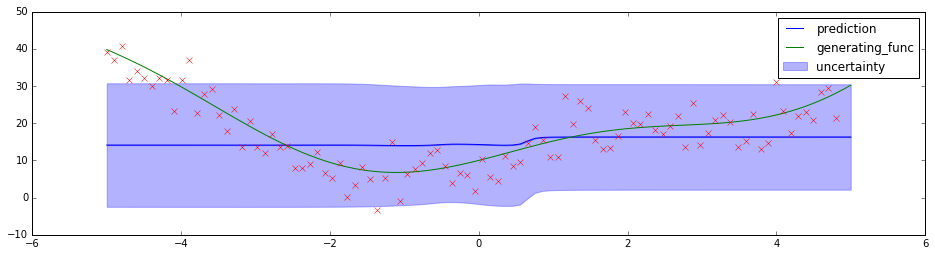

RSME is 9.864511489868164
COVERAGE PROBABILITY is 0.86
MEAN VARIANCE is 15.429808616638184
COVERAGE/MEAN_VAR is 0.055736271354179315
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.32716054, 0.00089246680895458525)


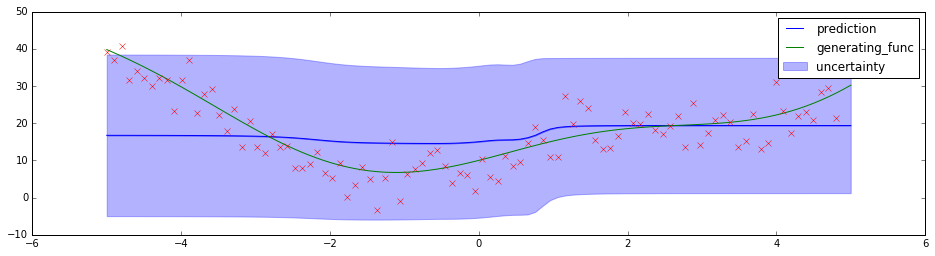

RSME is 8.985455513000488
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 19.89027976989746
COVERAGE/MEAN_VAR is 0.049270297418498914
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.39971602, 3.7883569593950337e-05)


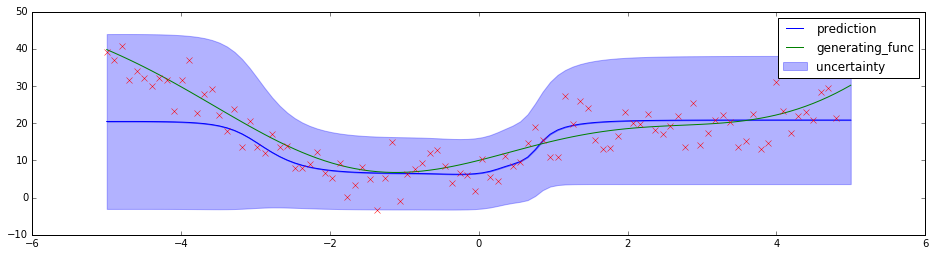

RSME is 6.702515125274658
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 15.703807830810547
COVERAGE/MEAN_VAR is 0.06304203481512556
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.50288808, 9.7139225113779199e-08)


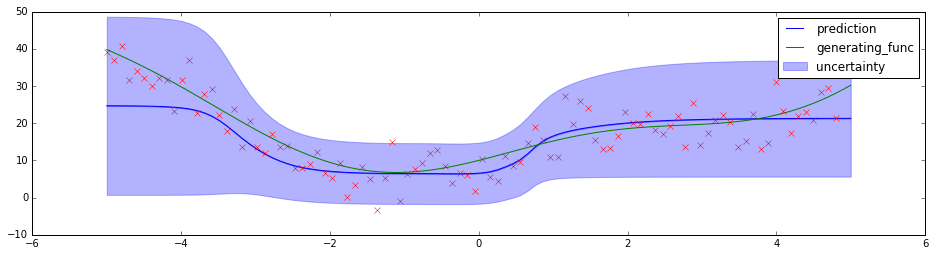

RSME is 5.768465518951416
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 13.84294319152832
COVERAGE/MEAN_VAR is 0.07079419357869977
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.42485762, 1.0540835969713025e-05)


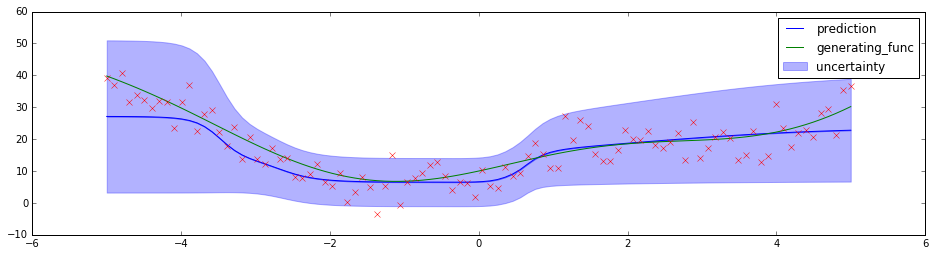

RSME is 5.250988006591797
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 12.963027000427246
COVERAGE/MEAN_VAR is 0.07559962653535322
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.35045573, 0.00035081436807661359)


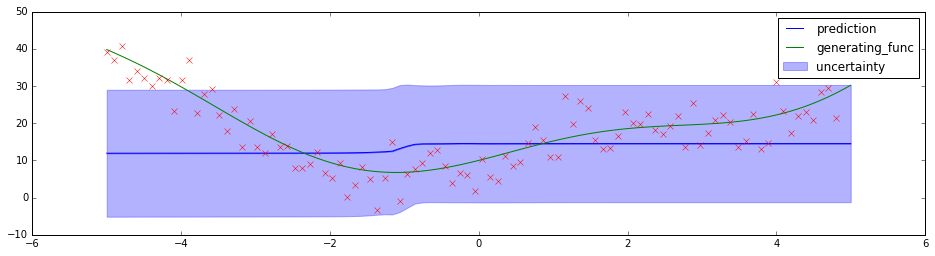

RSME is 10.749082565307617
COVERAGE PROBABILITY is 0.85
MEAN VARIANCE is 16.276771545410156
COVERAGE/MEAN_VAR is 0.052221658185015764
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.37386298, 0.00012734379382108941)


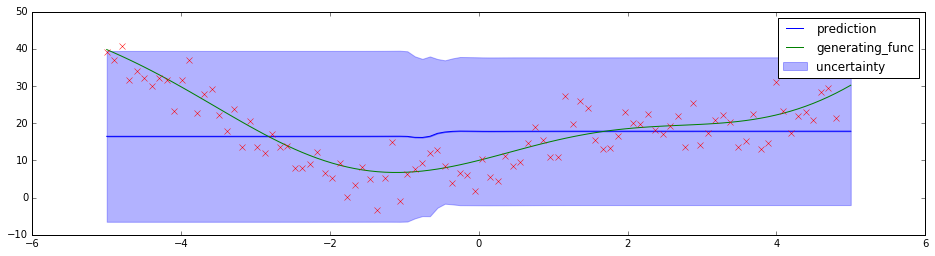

RSME is 9.777563095092773
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 21.17403793334961
COVERAGE/MEAN_VAR is 0.046755371040529146
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.37000784, 0.00015128412095900137)


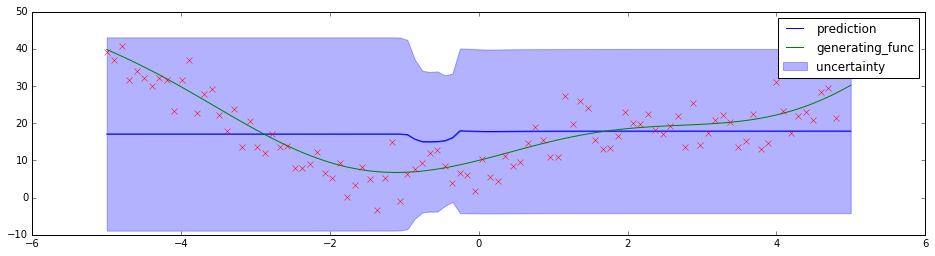

RSME is 9.66614055633545
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 23.469961166381836
COVERAGE/MEAN_VAR is 0.04260765464888758
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.36477217, 0.00019050661745759626)


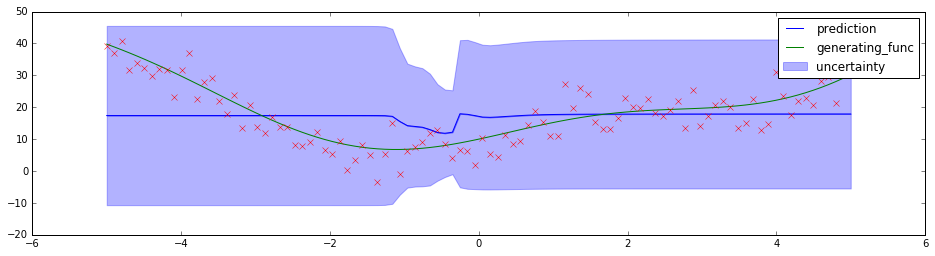

RSME is 9.446969032287598
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 24.677968978881836
COVERAGE/MEAN_VAR is 0.040521973297549314
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.34941182, 0.00036637760742010258)


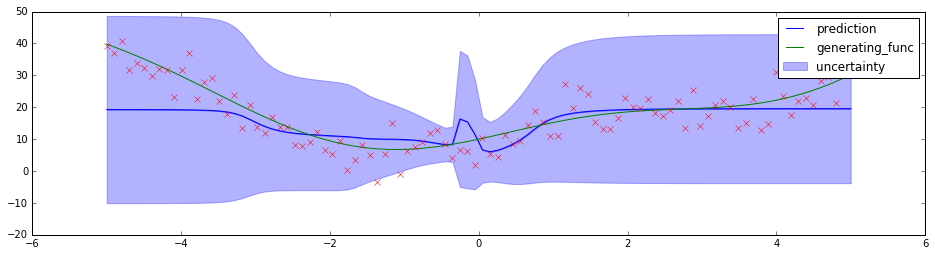

RSME is 7.395964622497559
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 20.634572982788086
COVERAGE/MEAN_VAR is 0.04749310784465699
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.39948526, 3.8313042128487518e-05)


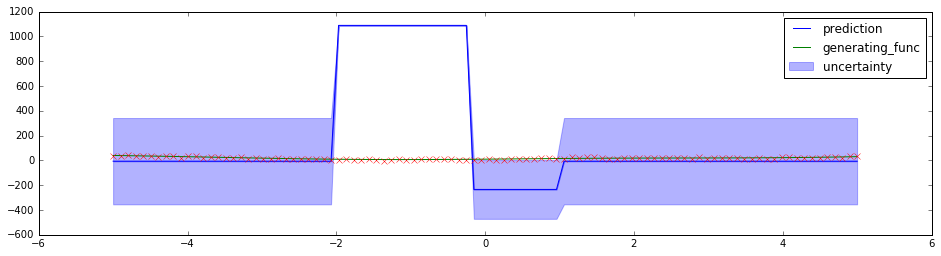

RSME is 467.5919494628906
COVERAGE PROBABILITY is 0.71
MEAN VARIANCE is 272.1116943359375
COVERAGE/MEAN_VAR is 0.0026092226639971754
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.97368991, 9.3587835945123283e-65)


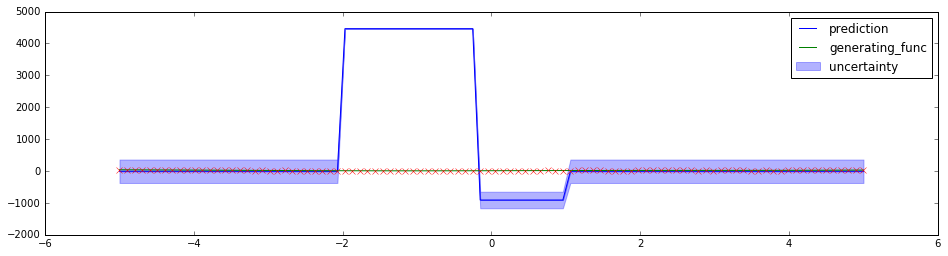

RSME is 1918.1243896484375
COVERAGE PROBABILITY is 0.7
MEAN VARIANCE is 288.68463134765625
COVERAGE/MEAN_VAR is 0.0024247913604967977
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.97702217, 1.3298858892838457e-67)


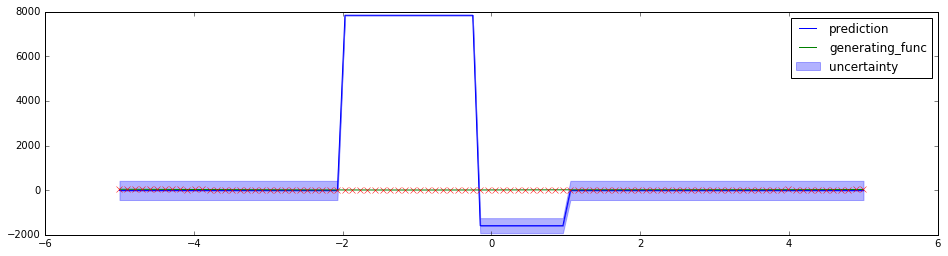

RSME is 3368.3779296875
COVERAGE PROBABILITY is 0.7
MEAN VARIANCE is 340.88006591796875
COVERAGE/MEAN_VAR is 0.002053508168965362
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.98896223, 4.4037440284495626e-83)


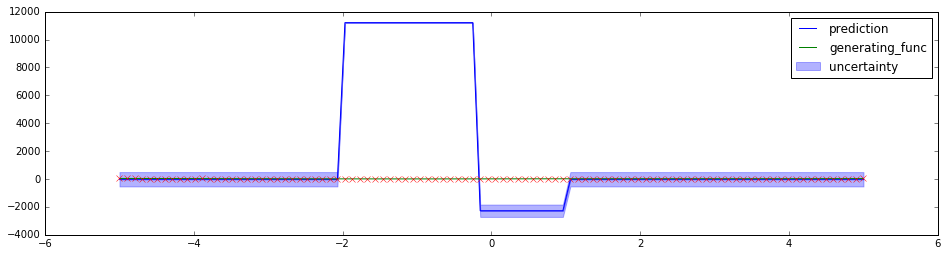

RSME is 4818.37548828125
COVERAGE PROBABILITY is 0.7
MEAN VARIANCE is 413.23846435546875
COVERAGE/MEAN_VAR is 0.0016939371824735516
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.99657863, 6.2587962884268235e-108)


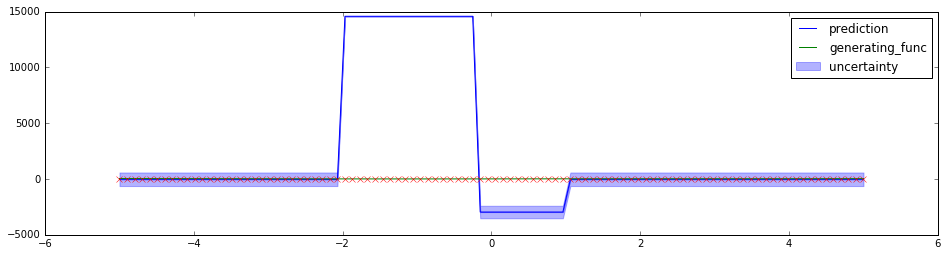

RSME is 6268.3310546875
COVERAGE PROBABILITY is 0.7
MEAN VARIANCE is 493.1622619628906
COVERAGE/MEAN_VAR is 0.0014194111228500153
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.99950057, 7.5115454630514754e-149)


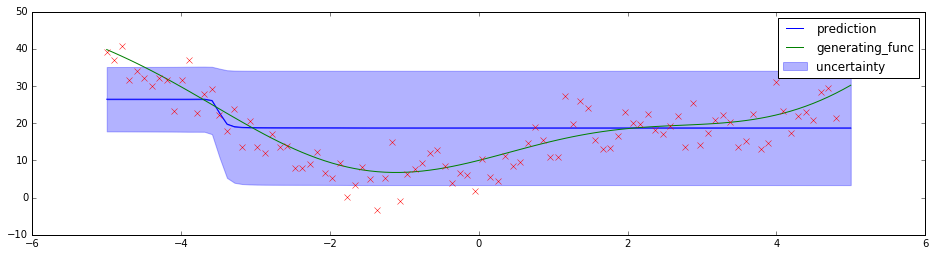

RSME is 8.646626472473145
COVERAGE PROBABILITY is 0.9
MEAN VARIANCE is 14.313158988952637
COVERAGE/MEAN_VAR is 0.06287920092934407
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.098568052, 0.32922974823629769)


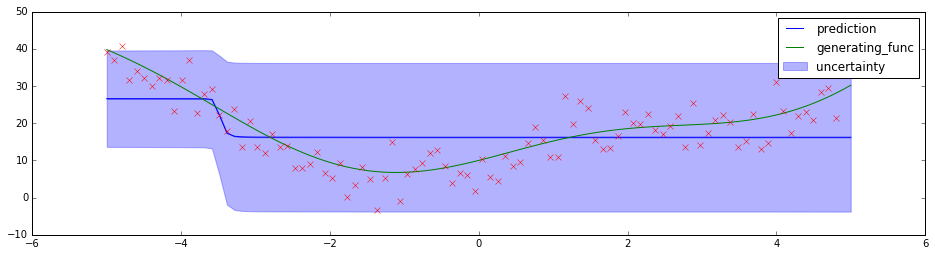

RSME is 7.97206974029541
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 18.8814640045166
COVERAGE/MEAN_VAR is 0.05190275498581974
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.059790142, 0.55457848739496063)


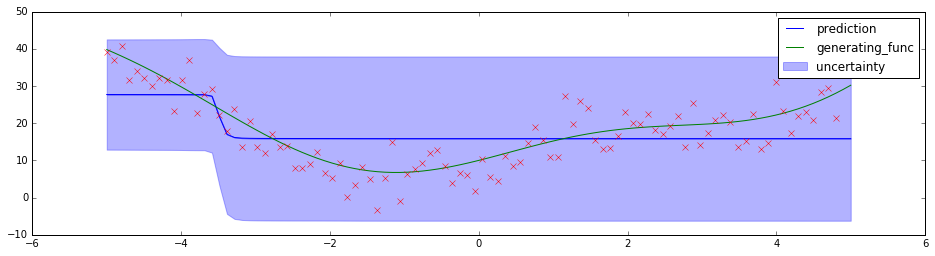

RSME is 7.8253631591796875
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 20.94866943359375
COVERAGE/MEAN_VAR is 0.04773572866620244
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.10074424, 0.31861093372137705)


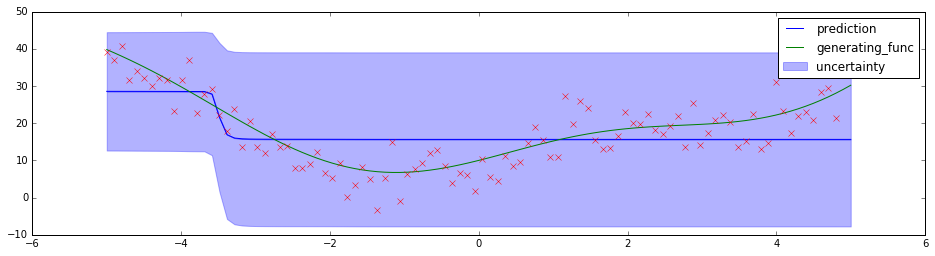

RSME is 7.741422653198242
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 22.2398738861084
COVERAGE/MEAN_VAR is 0.044964283750935564
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.12668636, 0.20911470171534949)


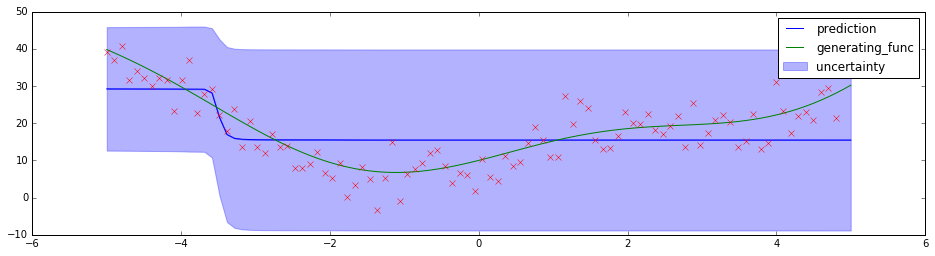

RSME is 7.688270092010498
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 23.1451416015625
COVERAGE/MEAN_VAR is 0.04320561166635901
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.14327089, 0.15501350879021683)


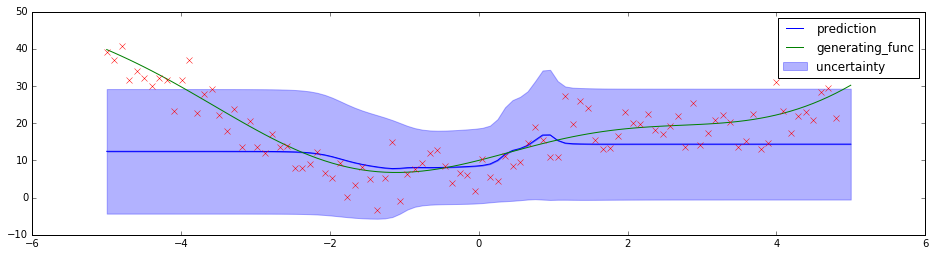

RSME is 10.127726554870605
COVERAGE PROBABILITY is 0.85
MEAN VARIANCE is 14.801278114318848
COVERAGE/MEAN_VAR is 0.05742747304894601
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.3529948, 0.00031546694521444836)


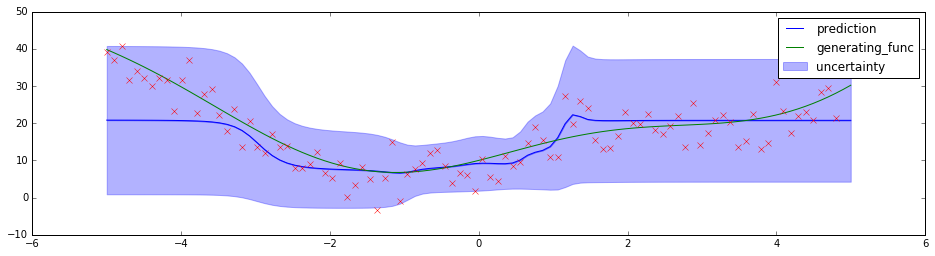

RSME is 6.592685699462891
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 14.230932235717773
COVERAGE/MEAN_VAR is 0.06956677072182452
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.39842761, 4.034032694595399e-05)


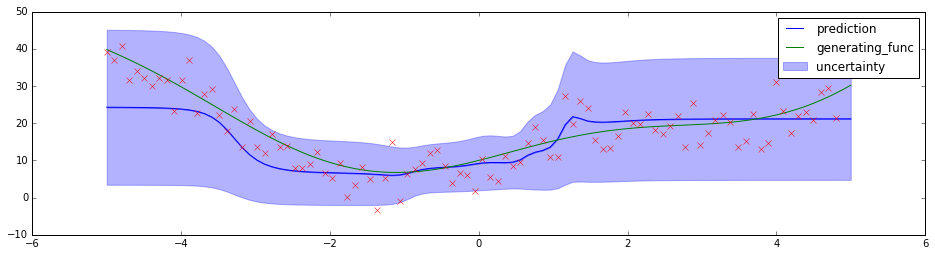

RSME is 5.971673965454102
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 13.6158447265625
COVERAGE/MEAN_VAR is 0.0712405303879291
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.36320022, 0.00020400319905086552)


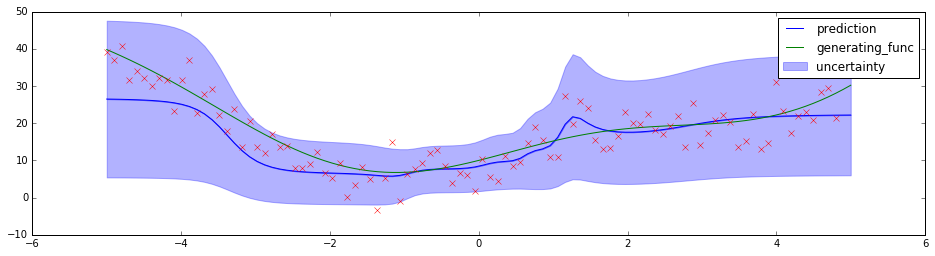

RSME is 5.557842254638672
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 12.991437911987305
COVERAGE/MEAN_VAR is 0.07543429808456738
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.34189105, 0.00049869619649100681)


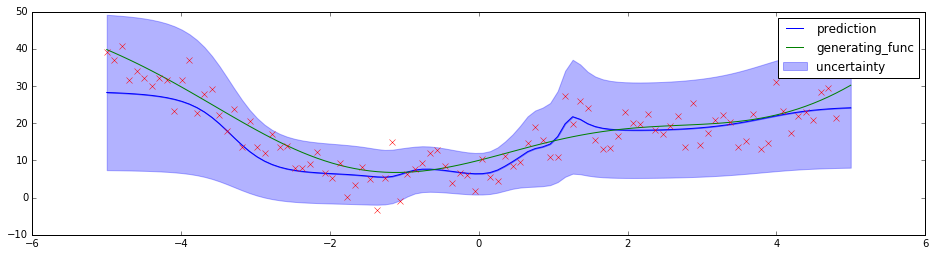

RSME is 5.038634300231934
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 12.28051471710205
COVERAGE/MEAN_VAR is 0.07898691727058978
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.34355906, 0.00046604146487372637)


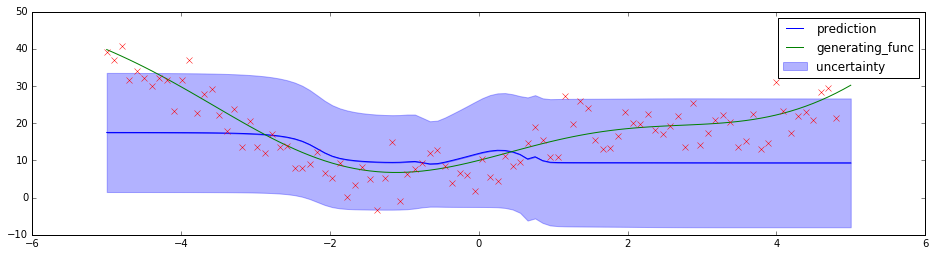

RSME is 10.690783500671387
COVERAGE PROBABILITY is 0.88
MEAN VARIANCE is 15.752449989318848
COVERAGE/MEAN_VAR is 0.05586432590464946
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.35450736, 0.00029600130706083352)


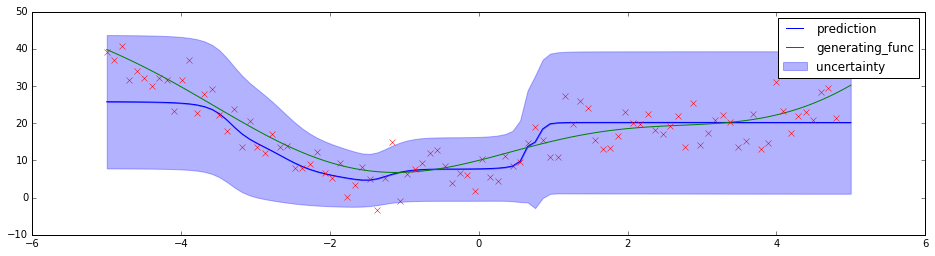

RSME is 5.546760082244873
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 15.133752822875977
COVERAGE/MEAN_VAR is 0.06475591424478964
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.24732634, 0.013107342072578541)


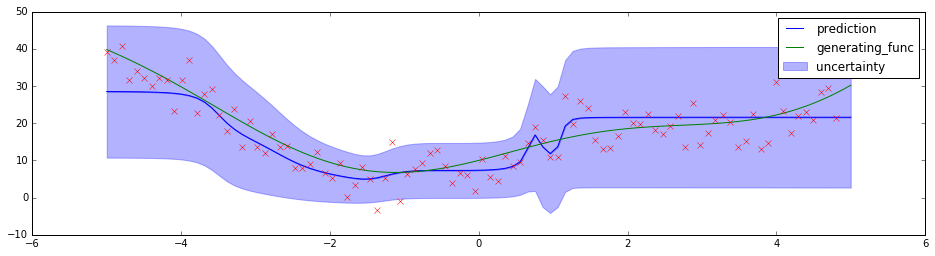

RSME is 5.014580726623535
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 14.39915657043457
COVERAGE/MEAN_VAR is 0.06736505678337278
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.24707131, 0.013204753505376853)


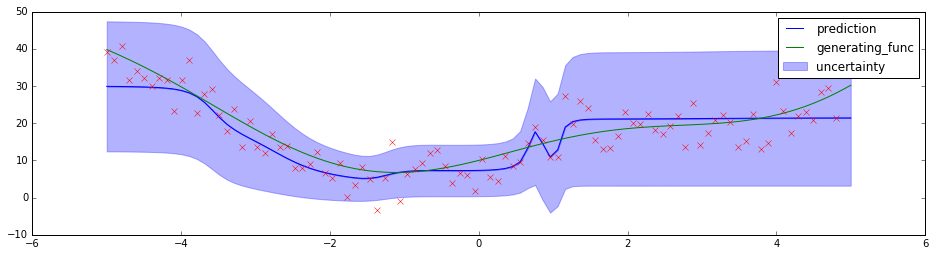

RSME is 4.8508381843566895
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 13.755090713500977
COVERAGE/MEAN_VAR is 0.07051934590645192
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.23191427, 0.020247234474880575)


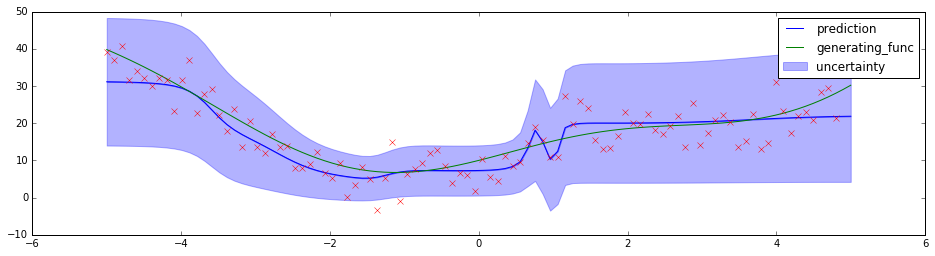

RSME is 4.644243240356445
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 12.976609230041504
COVERAGE/MEAN_VAR is 0.07474988132912265
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.22376788, 0.02522070291188681)


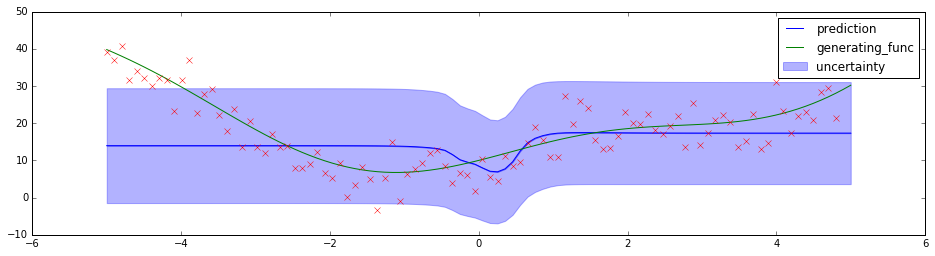

RSME is 9.468131065368652
COVERAGE PROBABILITY is 0.85
MEAN VARIANCE is 14.600284576416016
COVERAGE/MEAN_VAR is 0.05821804332314272
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.35879055, 0.0002467270690969201)


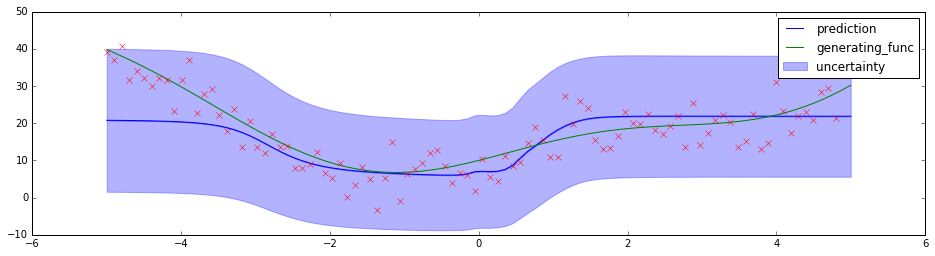

RSME is 6.674552917480469
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 16.598379135131836
COVERAGE/MEAN_VAR is 0.059644378040780106
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.52459621, 2.1148001947988408e-08)


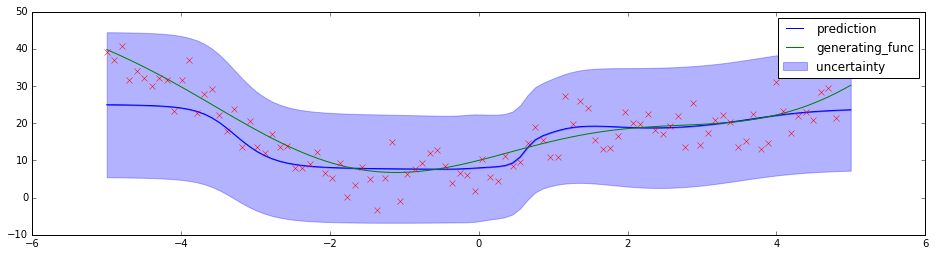

RSME is 5.601037502288818
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 15.960314750671387
COVERAGE/MEAN_VAR is 0.06265540596296411
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.44399902, 3.7078304435958897e-06)


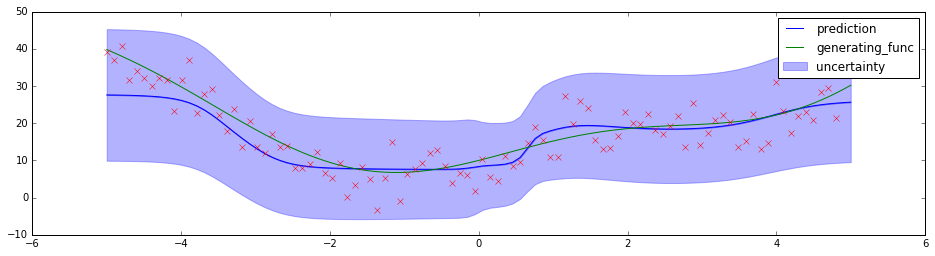

RSME is 5.048226356506348
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 14.550812721252441
COVERAGE/MEAN_VAR is 0.06872468357313352
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.34794784, 0.00038927541558711546)


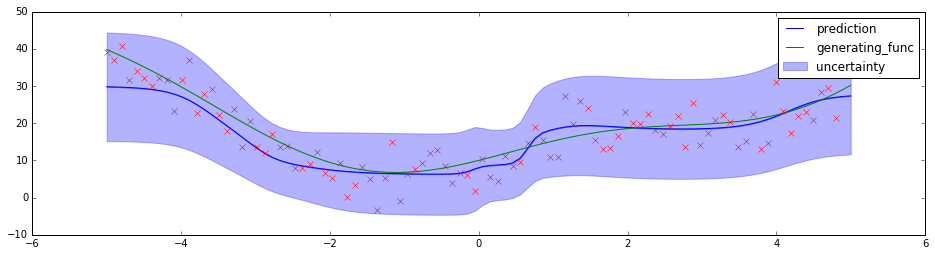

RSME is 4.705357551574707
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 12.341827392578125
COVERAGE/MEAN_VAR is 0.08102527836366918
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.25852099, 0.0094038121489505421)


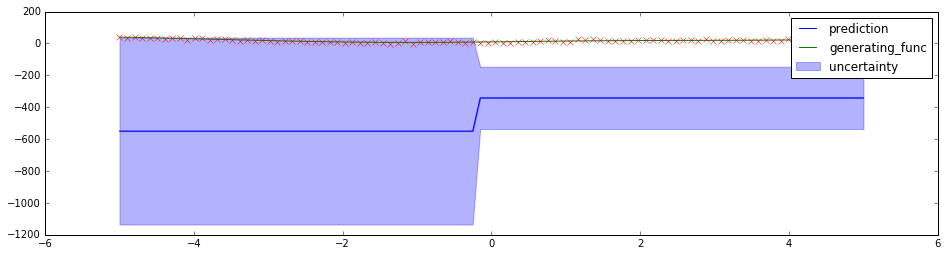

RSME is 470.2244567871094
COVERAGE PROBABILITY is 0.44
MEAN VARIANCE is 383.0129699707031
COVERAGE/MEAN_VAR is 0.0011487861626034645
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.99454767, 4.9256772425219011e-98)


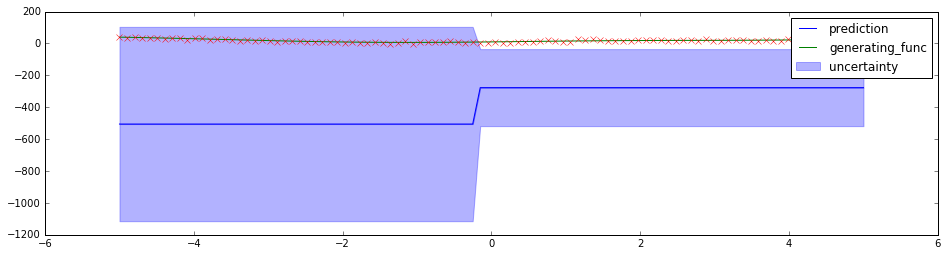

RSME is 419.72906494140625
COVERAGE PROBABILITY is 0.48
MEAN VARIANCE is 418.1748352050781
COVERAGE/MEAN_VAR is 0.0011478452541617001
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.99519366, 1.0362059875491588e-100)


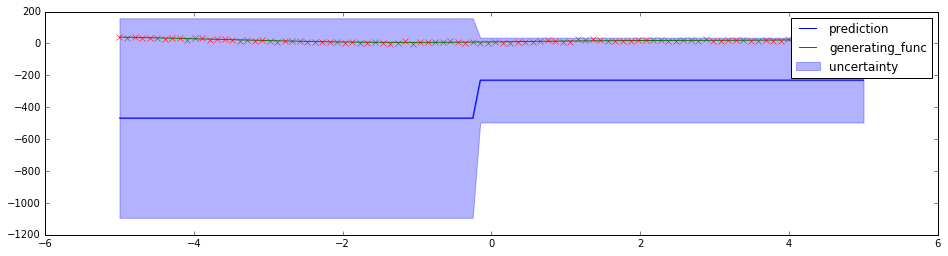

RSME is 380.33148193359375
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 438.6968688964844
COVERAGE/MEAN_VAR is 0.002256683532960437
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.99535745, 1.9022584823094581e-101)


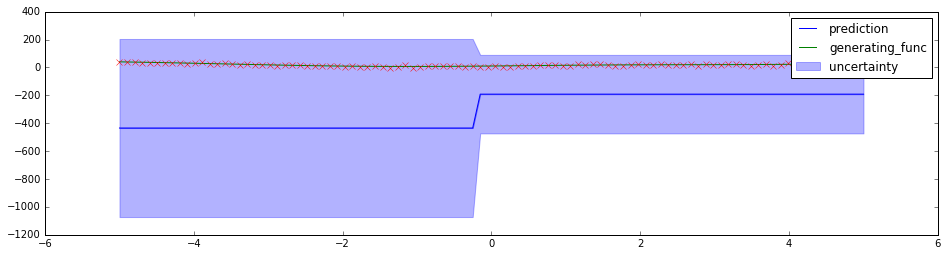

RSME is 347.5302734375
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 452.7110290527344
COVERAGE/MEAN_VAR is 0.002208914596342901
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.99532735, 2.6090926779176681e-101)


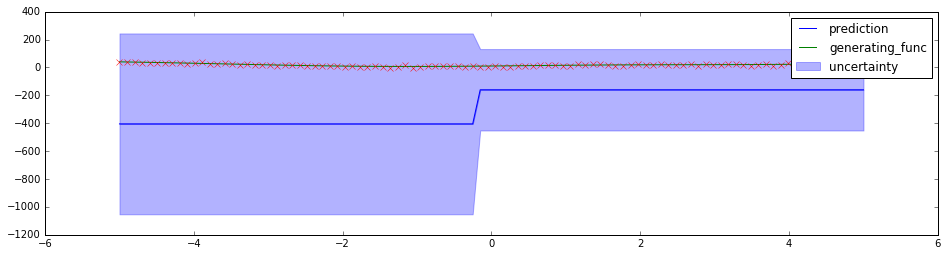

RSME is 319.4181213378906
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 462.94683837890625
COVERAGE/MEAN_VAR is 0.0021600752334796896
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.99518168, 1.170313316714053e-100)


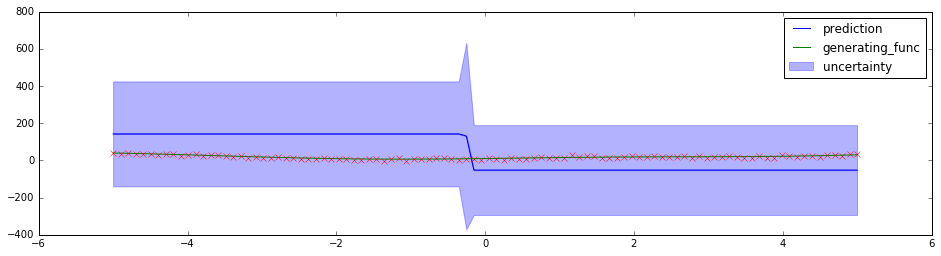

RSME is 101.03500366210938
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 263.1368103027344
COVERAGE/MEAN_VAR is 0.0038003044836240024
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.66632521, 3.8488074067519509e-14)


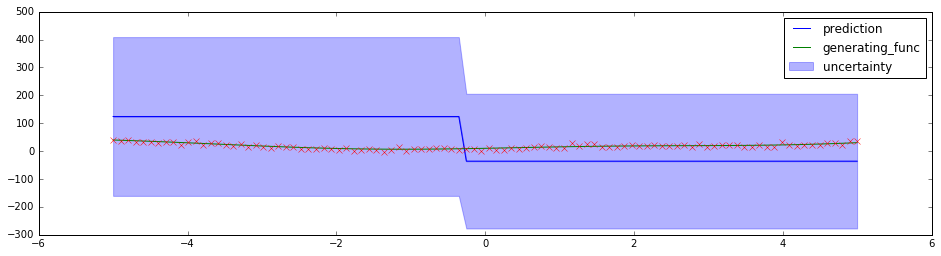

RSME is 83.79886627197266
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 261.69012451171875
COVERAGE/MEAN_VAR is 0.003821313478549776
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.9227016, 2.3520194383729824e-42)


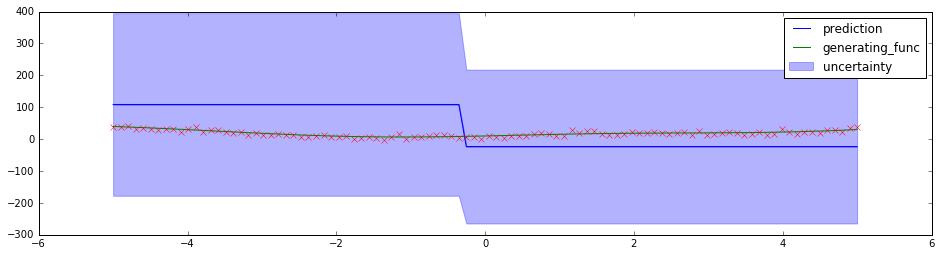

RSME is 70.33417510986328
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 262.43310546875
COVERAGE/MEAN_VAR is 0.003810494861971894
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.91228223, 8.9445449065162765e-40)


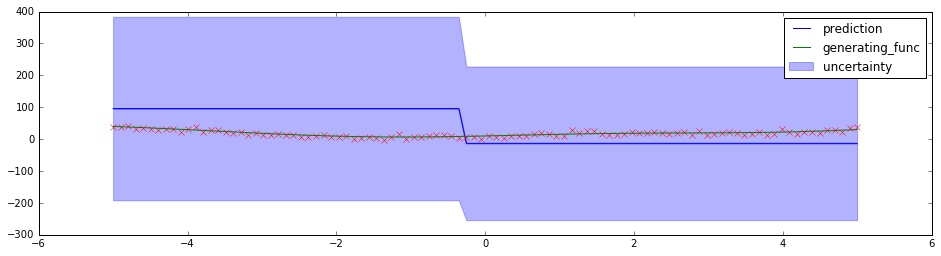

RSME is 59.4228401184082
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 262.9126281738281
COVERAGE/MEAN_VAR is 0.003803544953112092
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.89973438, 4.5971699728463385e-37)


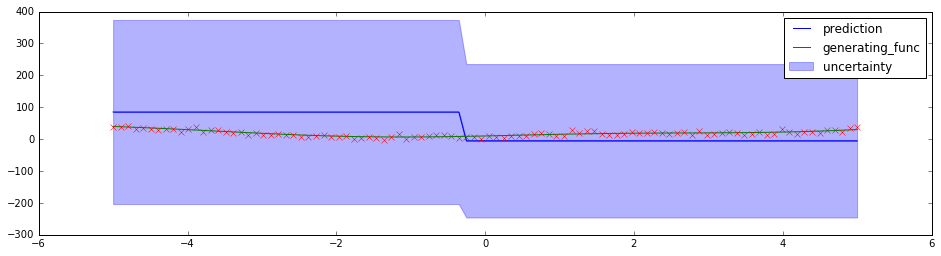

RSME is 50.57255554199219
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 263.2215576171875
COVERAGE/MEAN_VAR is 0.0037990809303481733
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.88476574, 2.8993726771255643e-34)


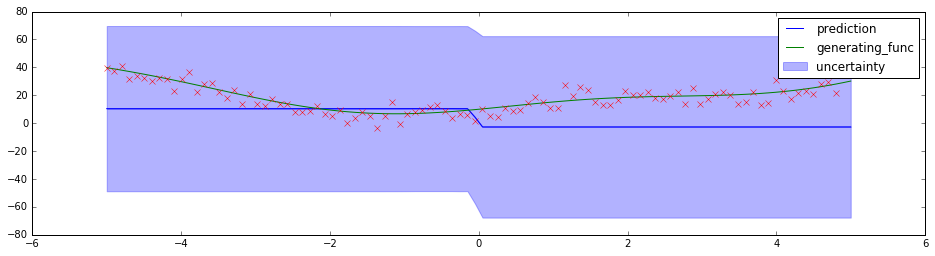

RSME is 18.422487258911133
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 62.15507507324219
COVERAGE/MEAN_VAR is 0.01608879079981195
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.50095308, 1.1071551176627079e-07)


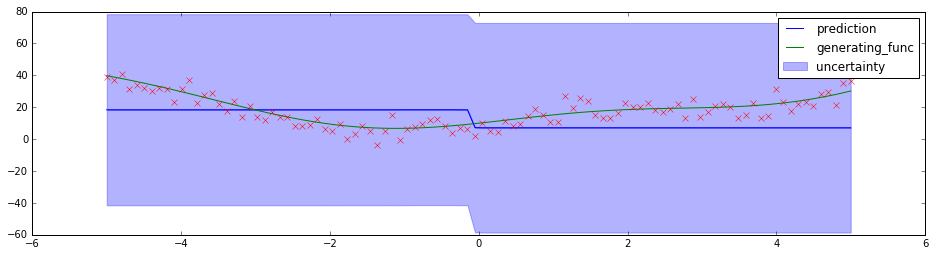

RSME is 12.68669319152832
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 62.898704528808594
COVERAGE/MEAN_VAR is 0.01589857863514477
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.11614066, 0.2498541243746403)


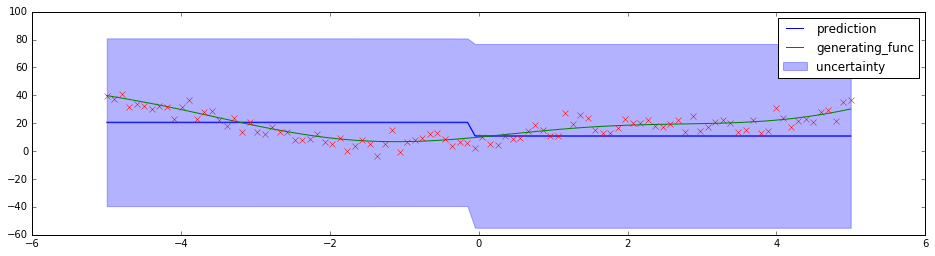

RSME is 11.470040321350098
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 63.06000900268555
COVERAGE/MEAN_VAR is 0.015857910834700527
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.16955663, 0.09170268221909747)


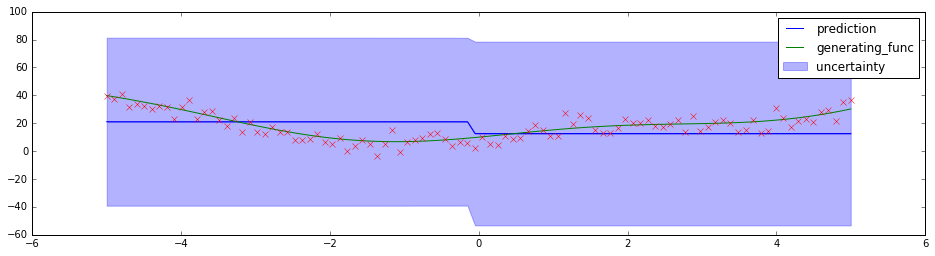

RSME is 11.026352882385254
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 63.0923957824707
COVERAGE/MEAN_VAR is 0.015849770603858337
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.27623287, 0.0054034039873650823)


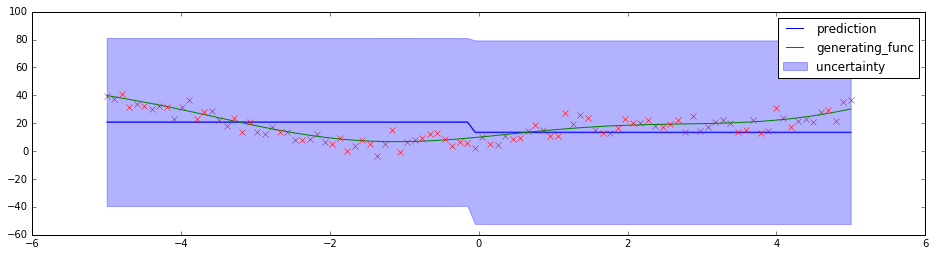

RSME is 10.74473762512207
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 63.060577392578125
COVERAGE/MEAN_VAR is 0.015857767901086398
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.31824827, 0.0012518277359826815)


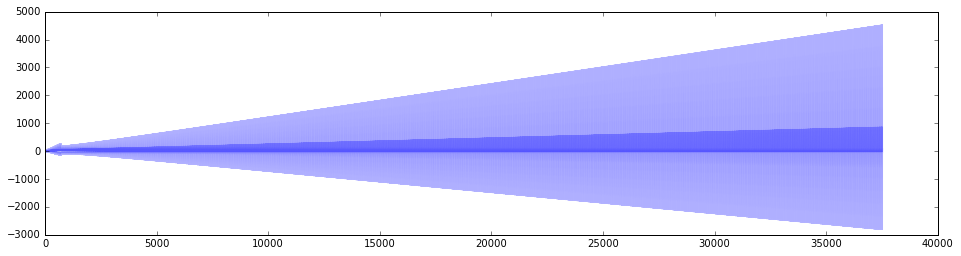

In [23]:
import numpy as np
n_samples = 20
num_epochs = 25#15#10#15
num_eps = 15#25#75
seed = 43#43 is cool 101 1011
params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}


errors_meta = []


bad_seeds = [2,4,10,13,15,16,9]
very_bad_seeds = [16,10]
for i in range(n_samples):
    silent = False
    if i == n_samples - 1:
        silent = True
    if not i in bad_seeds:
        params['seed'] = seed+i
    else:
        if i not in very_bad_seeds:
            params['seed'] = seed + 100+i
        else:
            params['seed'] = seed + 100+i + 42 + i

    gauss_tmp = GaussianLossEstimator(**params)

    errors = train_and_plot(gauss_tmp,X,y,sorted_index,generating_func=generate_sinoid,
                   num_eps=num_eps,silent=silent)
    errors_meta.append(errors)
    
    
    
plot_error_tmp(np.mean(errors_meta,axis=0).flatten(),np.std(errors_meta,axis=0).flatten())

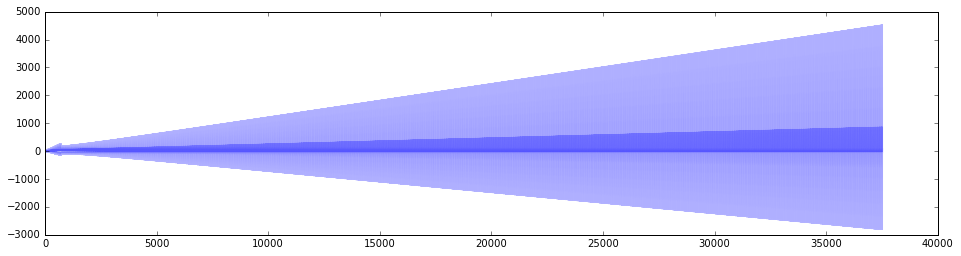

In [24]:
plot_error_tmp(np.mean(errors_meta,axis=0).flatten(),np.std(errors_meta,axis=0).flatten())

In [25]:
#for i in range(n_samples):
#    plt.plot(errors_meta[i])
#    plt.show()
#    print(i)

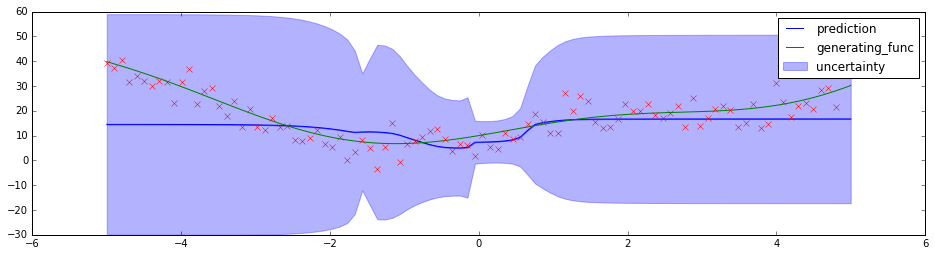

RSME is 9.11553955078125
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 33.667327880859375
COVERAGE/MEAN_VAR is 0.029702386941391993
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.40453857, 2.9874841059873533e-05)


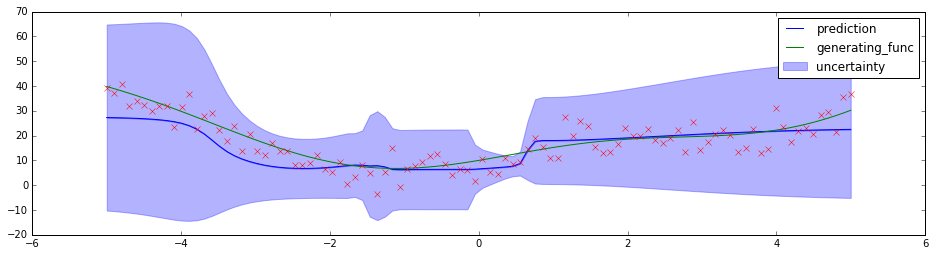

RSME is 5.833017826080322
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 21.2727108001709
COVERAGE/MEAN_VAR is 0.04700858340968779
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.34363288, 0.00046464272092959058)


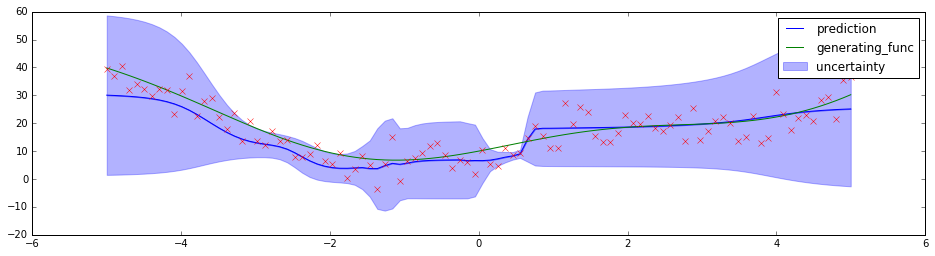

RSME is 4.9217658042907715
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 14.858175277709961
COVERAGE/MEAN_VAR is 0.0625918043513172
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.33550048, 0.00064419974623333817)


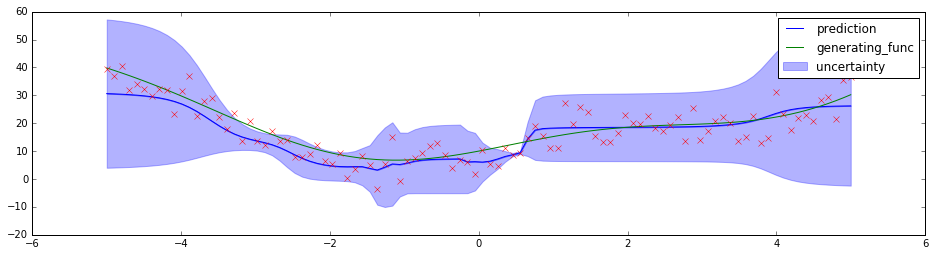

RSME is 4.715564250946045
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 13.491969108581543
COVERAGE/MEAN_VAR is 0.07041225727353276
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.33409637, 0.0006809785014756962)


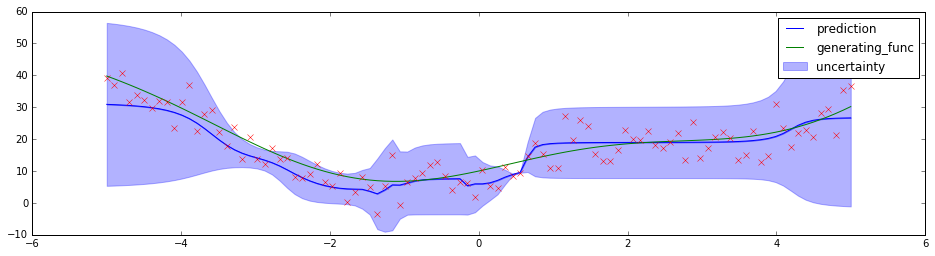

RSME is 4.529601097106934
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 12.284672737121582
COVERAGE/MEAN_VAR is 0.07570409240042222
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.31465495, 0.0014306977324523335)


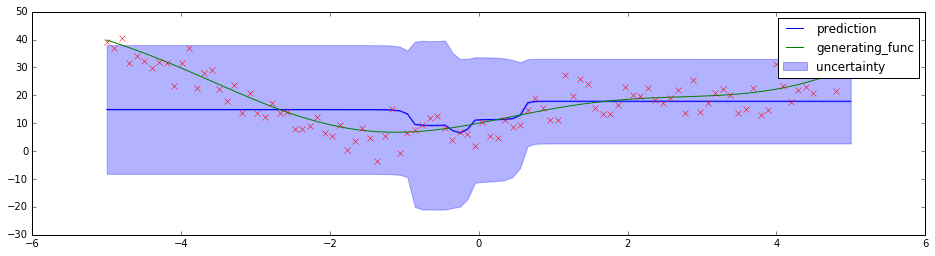

RSME is 9.224625587463379
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 19.928342819213867
COVERAGE/MEAN_VAR is 0.04817259561966277
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.20082022, 0.045132983318284921)


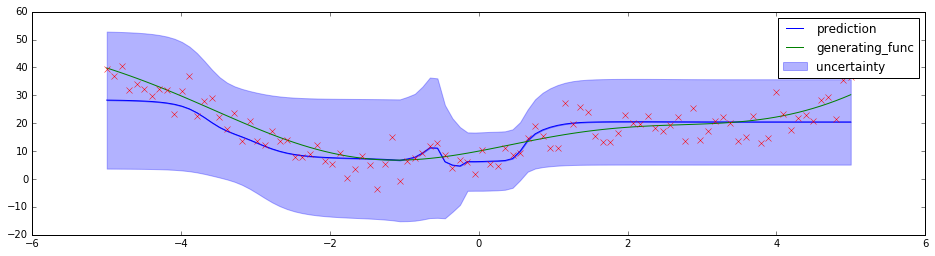

RSME is 5.349052429199219
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 17.643089294433594
COVERAGE/MEAN_VAR is 0.0561126219721818
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.084741846, 0.40187706856956074)


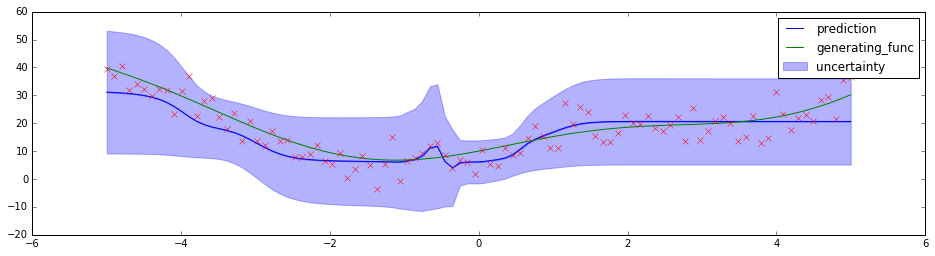

RSME is 5.2716569900512695
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 14.885047912597656
COVERAGE/MEAN_VAR is 0.06583788011663684
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.054487187, 0.59028593720757061)


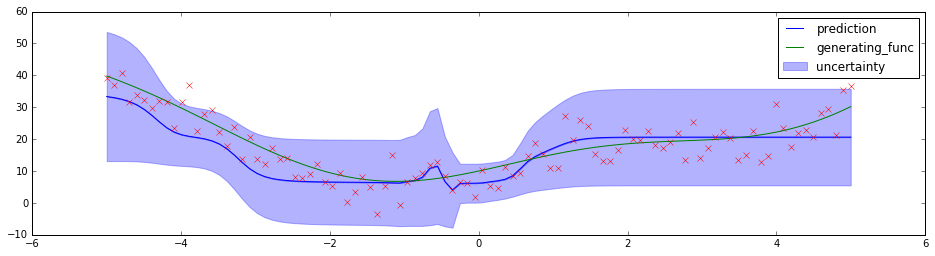

RSME is 5.50888729095459
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 13.347186088562012
COVERAGE/MEAN_VAR is 0.07192527276012735
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.00071905641, 0.99433493898501479)


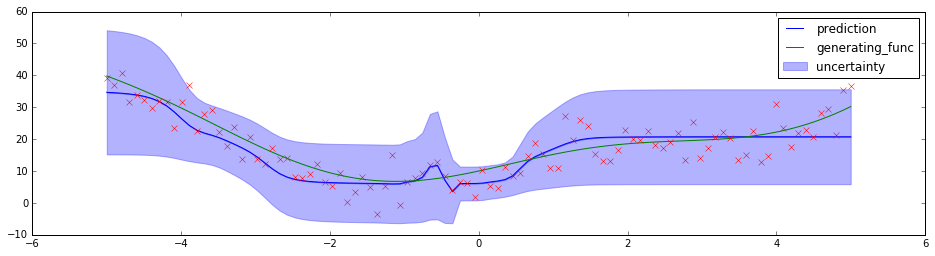

RSME is 4.902970790863037
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 12.97900390625
COVERAGE/MEAN_VAR is 0.07550656483954704
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.088716954, 0.38008045010093561)


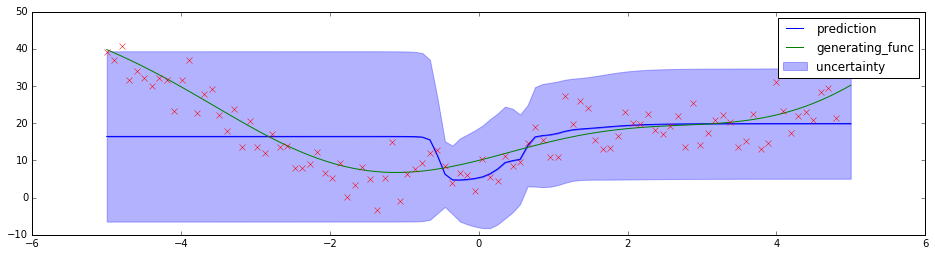

RSME is 8.883685111999512
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 17.958271026611328
COVERAGE/MEAN_VAR is 0.05401410851649431
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.48422924, 3.3182010973320314e-07)


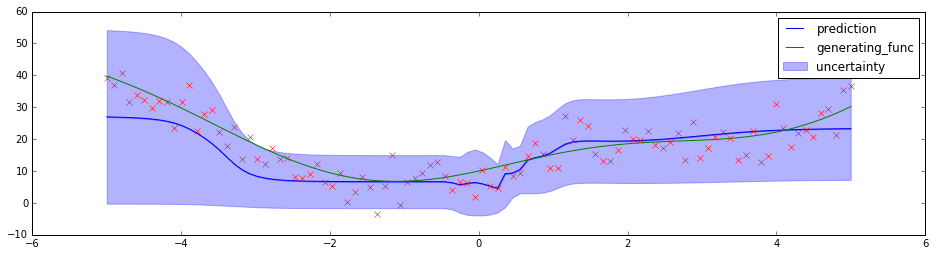

RSME is 5.7846856117248535
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 13.815384864807129
COVERAGE/MEAN_VAR is 0.07021158002416183
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.37034062, 0.00014906380539147062)


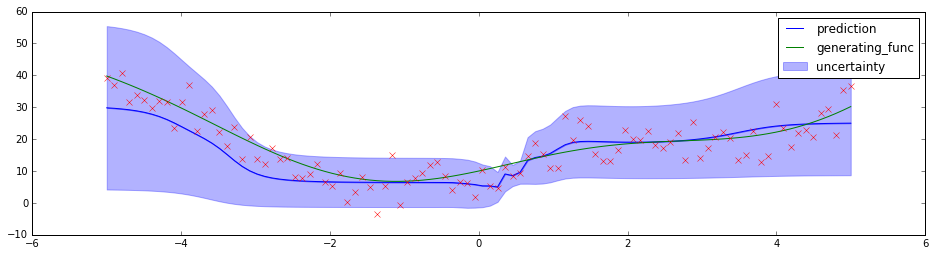

RSME is 5.435575485229492
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 12.393034934997559
COVERAGE/MEAN_VAR is 0.0782697704870297
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.32293215, 0.0010492182162643018)


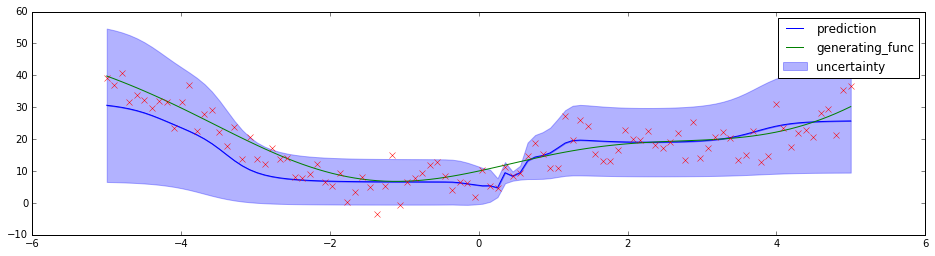

RSME is 5.320181846618652
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 11.448446273803711
COVERAGE/MEAN_VAR is 0.08298069251316541
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.33872151, 0.00056659959299809799)


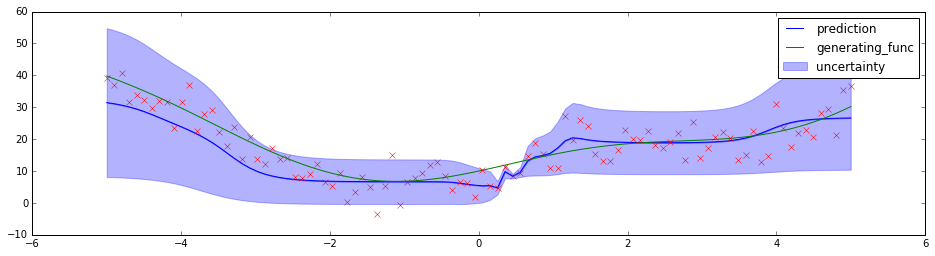

RSME is 5.108212471008301
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 10.898554801940918
COVERAGE/MEAN_VAR is 0.08808507342909667
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.33034873, 0.00078875028995860461)


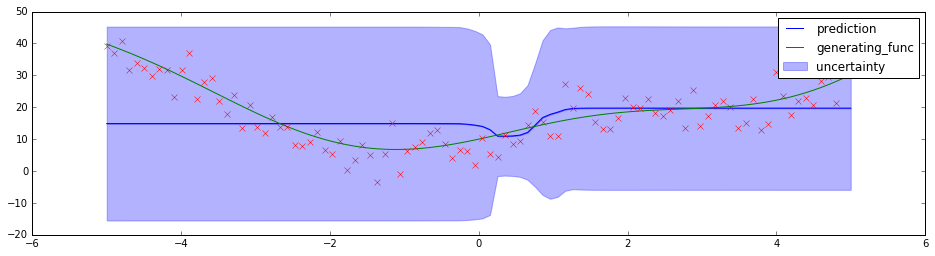

RSME is 9.33859920501709
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 27.351768493652344
COVERAGE/MEAN_VAR is 0.03656070722564337
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.33149976, 0.0007540980248027829)


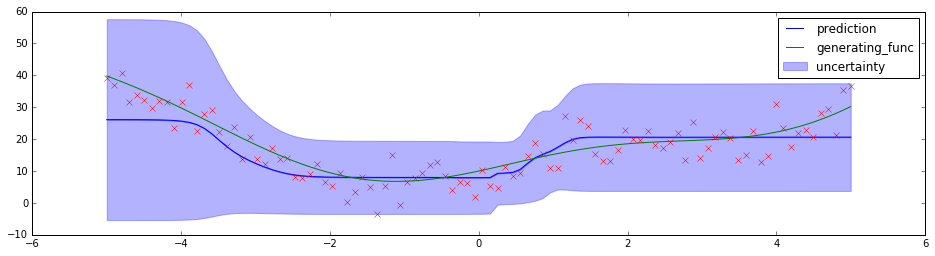

RSME is 5.624268054962158
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 16.967308044433594
COVERAGE/MEAN_VAR is 0.058936868322377545
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.32299301, 0.0010467947202731957)


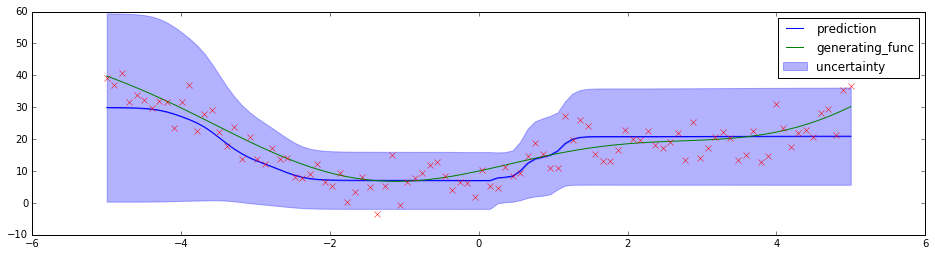

RSME is 5.090144634246826
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 14.784502029418945
COVERAGE/MEAN_VAR is 0.06628562788587311
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.15985431, 0.11213273325487988)


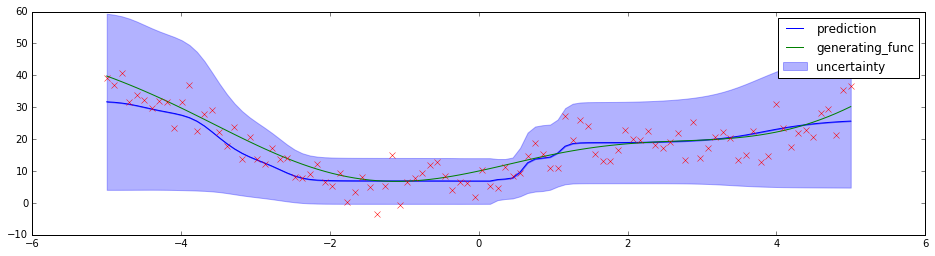

RSME is 4.644247055053711
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 13.66833209991455
COVERAGE/MEAN_VAR is 0.07096696165335813
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.23075999, 0.020896141935299161)


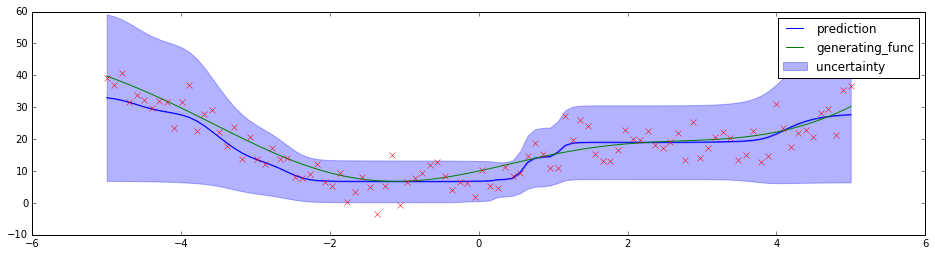

RSME is 4.430603981018066
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 12.372424125671387
COVERAGE/MEAN_VAR is 0.0784001574911548
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.19075595, 0.057292509757884608)


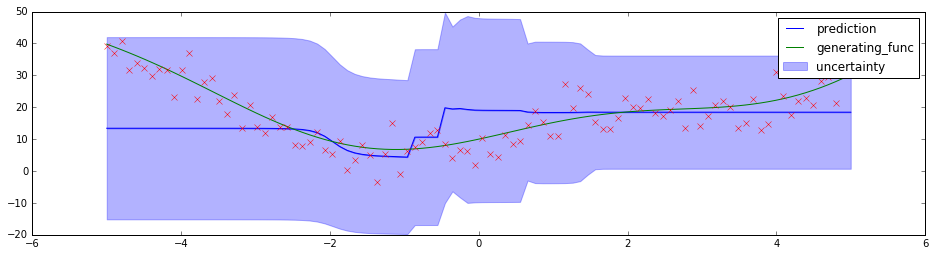

RSME is 9.828350067138672
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 23.683534622192383
COVERAGE/MEAN_VAR is 0.04180119292972139
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.39271635, 5.3132025975025311e-05)


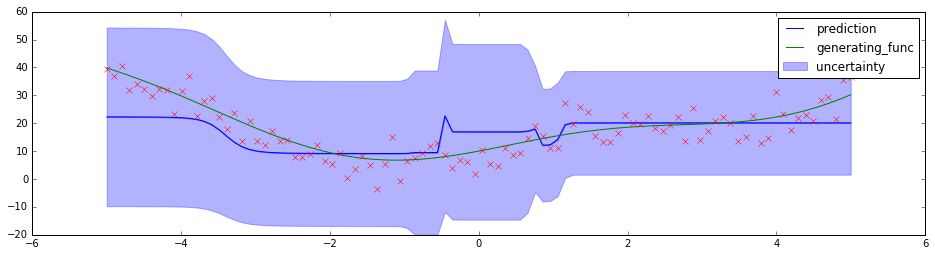

RSME is 7.383051872253418
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 24.693208694458008
COVERAGE/MEAN_VAR is 0.04049696466641996
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.40500143, 2.9195912329544056e-05)


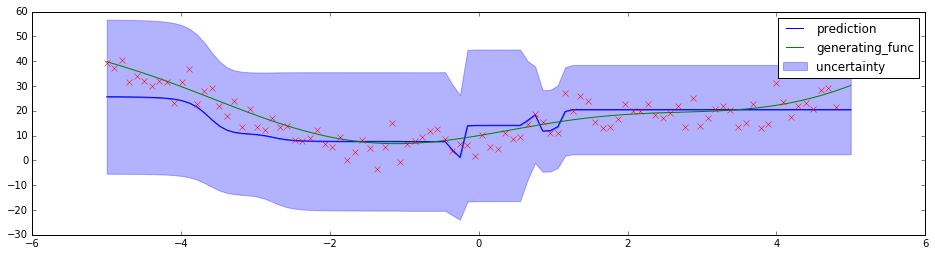

RSME is 6.366145133972168
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 23.86981964111328
COVERAGE/MEAN_VAR is 0.04189390682607438
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.18996623, 0.058350505648622611)


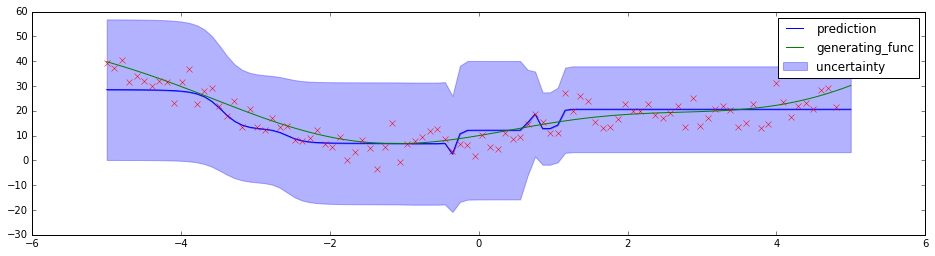

RSME is 5.300752639770508
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 21.9351806640625
COVERAGE/MEAN_VAR is 0.04558886545385741
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.011548668, 0.90920726089188952)


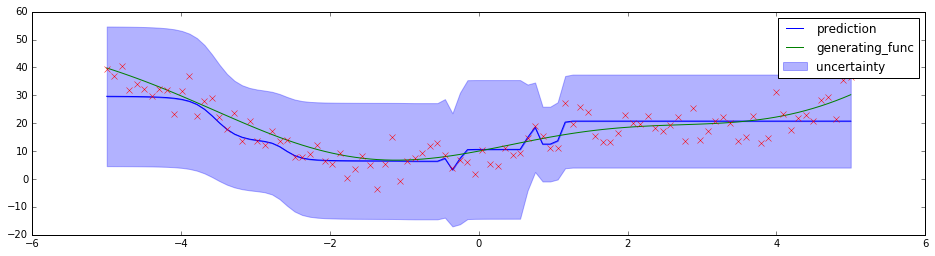

RSME is 5.071342468261719
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 19.611242294311523
COVERAGE/MEAN_VAR is 0.050991160324915366
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.022369154, 0.8251649948251274)


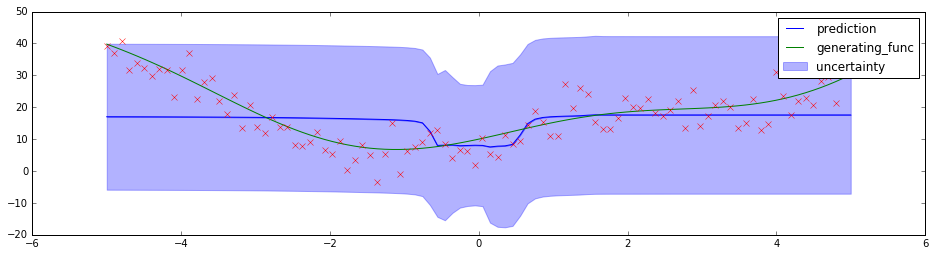

RSME is 8.941657066345215
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 23.65019989013672
COVERAGE/MEAN_VAR is 0.04186011131402226
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.17460199, 0.082309400794203361)


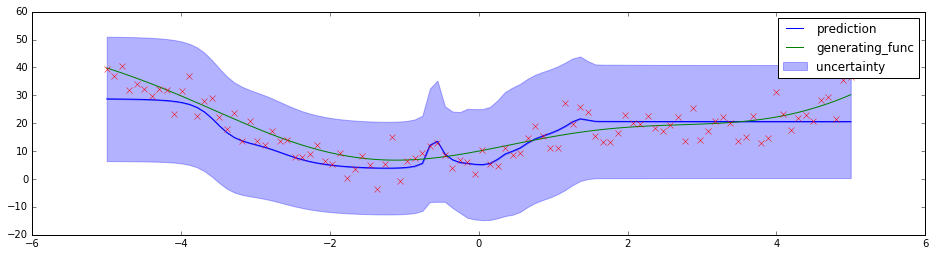

RSME is 5.209954738616943
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 19.991079330444336
COVERAGE/MEAN_VAR is 0.05002231162562113
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.095086999, 0.34667941468338392)


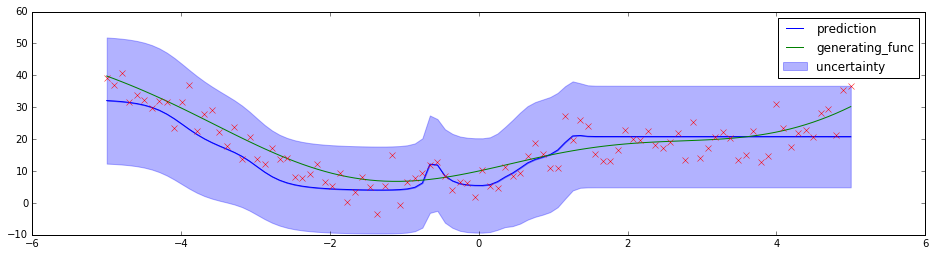

RSME is 5.296818256378174
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 16.00580406188965
COVERAGE/MEAN_VAR is 0.06185256274361267
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.079946101, 0.42913278916881969)


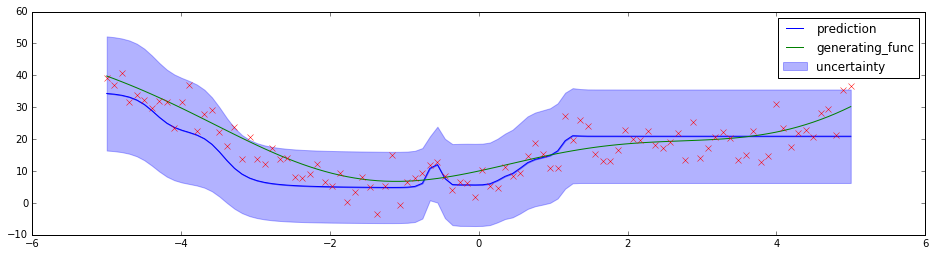

RSME is 5.671967506408691
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 13.884305000305176
COVERAGE/MEAN_VAR is 0.06986305760199589
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.023871021, 0.81363239840615853)


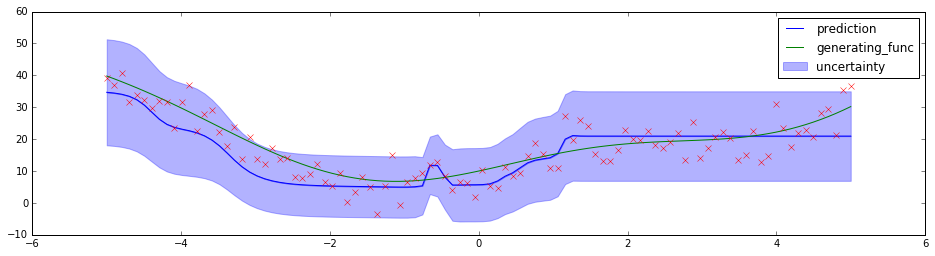

RSME is 5.395877361297607
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 12.636100769042969
COVERAGE/MEAN_VAR is 0.07439003670363999
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.058293227, 0.56455192224471618)


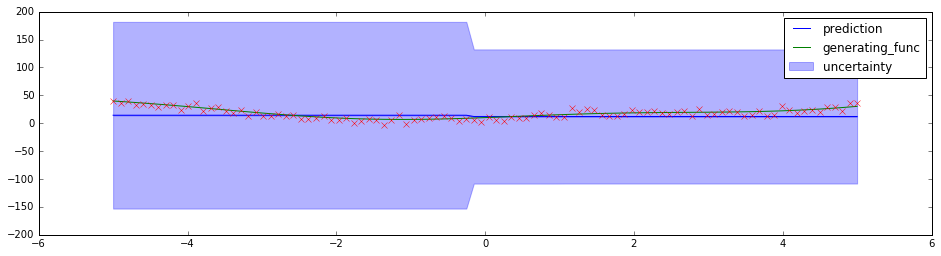

RSME is 10.844137191772461
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 142.8131103515625
COVERAGE/MEAN_VAR is 0.007002158258007992
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.17325146, 0.08474503561214361)


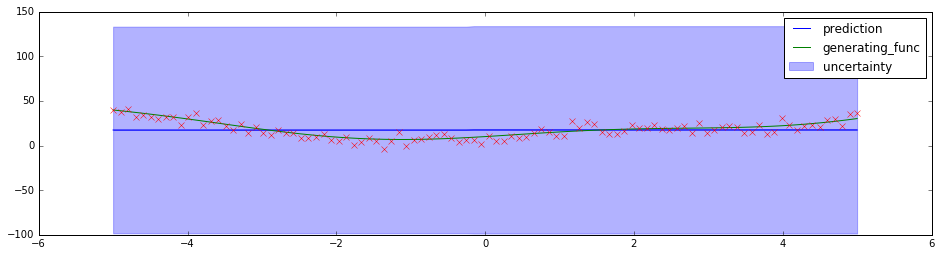

RSME is 9.74946117401123
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 115.93913269042969
COVERAGE/MEAN_VAR is 0.008625215462583376
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.36321965, 0.00020383110097696544)


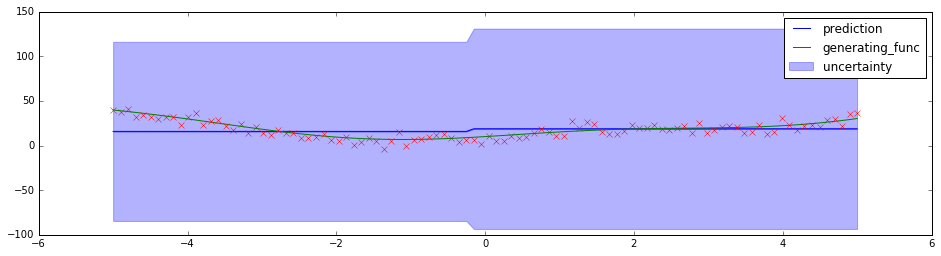

RSME is 9.762027740478516
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 106.50810241699219
COVERAGE/MEAN_VAR is 0.009388957058730408
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.340931, 0.00051843061761734036)


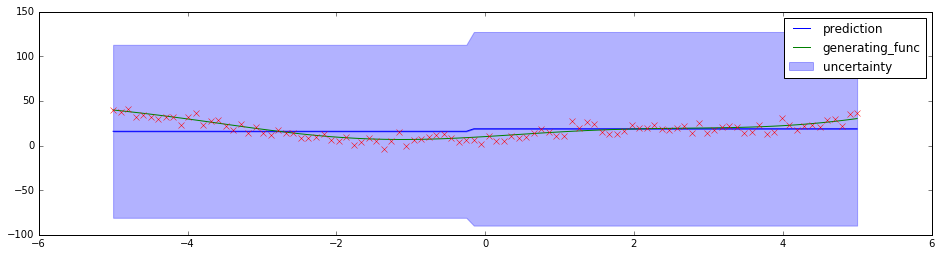

RSME is 9.756394386291504
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 102.89021301269531
COVERAGE/MEAN_VAR is 0.00971909738272787
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.34246445, 0.00048724105799704273)


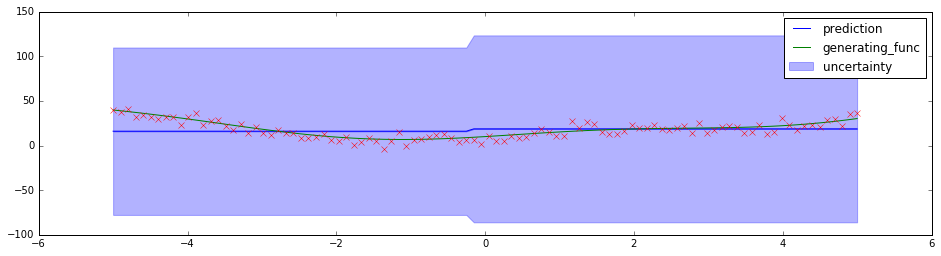

RSME is 9.749857902526855
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 99.44873046875
COVERAGE/MEAN_VAR is 0.010055432535805294
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.34427059, 0.00045271899123375177)


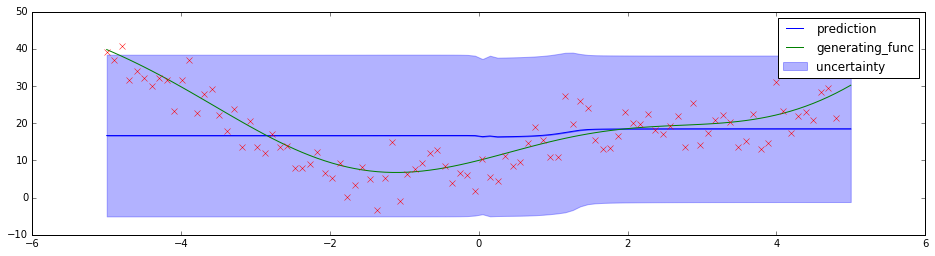

RSME is 9.54921817779541
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 20.941078186035156
COVERAGE/MEAN_VAR is 0.04679797244888405
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.35773307, 0.00025813298855696648)


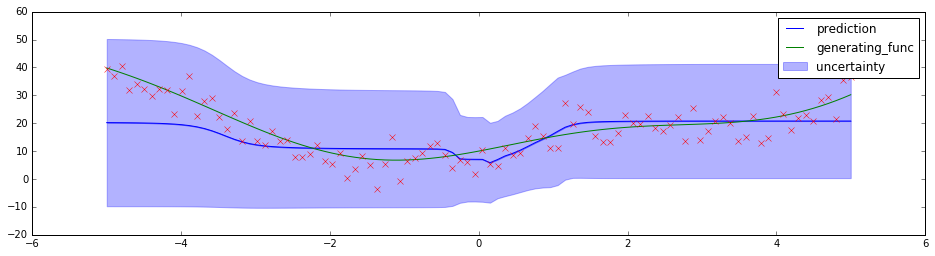

RSME is 7.186634063720703
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 21.468523025512695
COVERAGE/MEAN_VAR is 0.04657982287890151
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.60101497, 3.8124849064341786e-11)


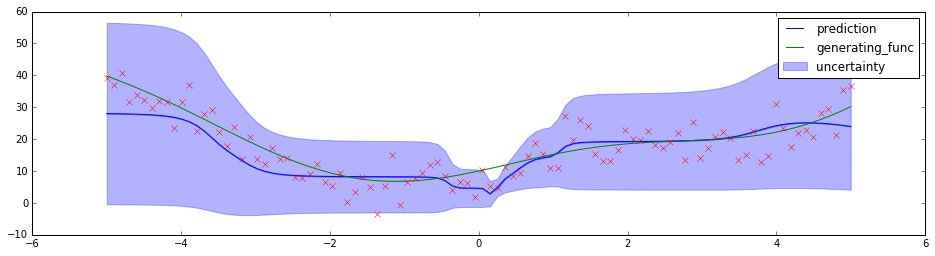

RSME is 5.293335914611816
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 15.612805366516113
COVERAGE/MEAN_VAR is 0.06276898846774517
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.3420313, 0.00049587171828796204)


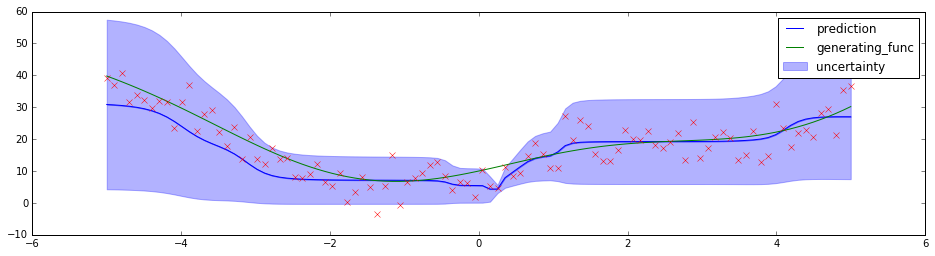

RSME is 5.054325103759766
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 12.85070514678955
COVERAGE/MEAN_VAR is 0.07470407180261494
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.2708168, 0.0064253918764326876)


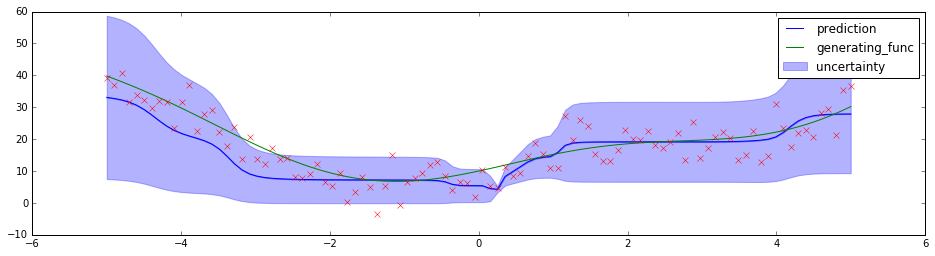

RSME is 5.28564453125
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 11.823436737060547
COVERAGE/MEAN_VAR is 0.07865733294659719
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.19933631, 0.04677813440651421)


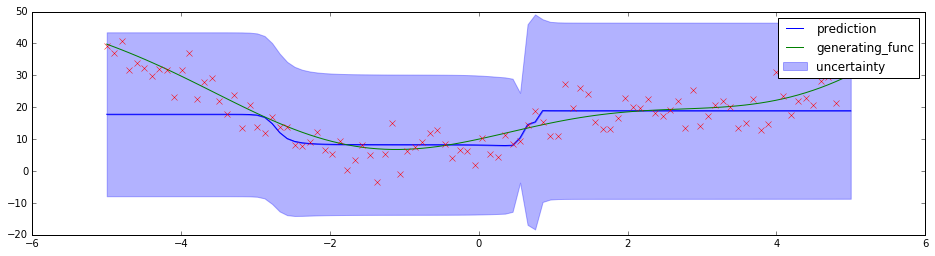

RSME is 7.567182540893555
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 25.4088134765625
COVERAGE/MEAN_VAR is 0.039356422562683464
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.10102302, 0.31726675937653881)


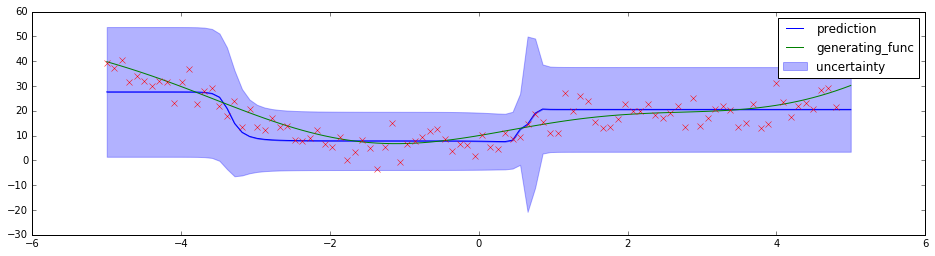

RSME is 5.598057746887207
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 17.07486343383789
COVERAGE/MEAN_VAR is 0.05856562214244495
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.11044669, 0.27398491363862632)


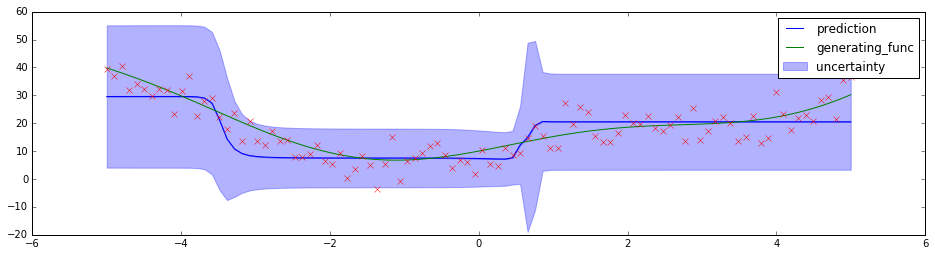

RSME is 5.5426025390625
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 16.417877197265625
COVERAGE/MEAN_VAR is 0.06030012212327201
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.035007648, 0.72950717636082196)


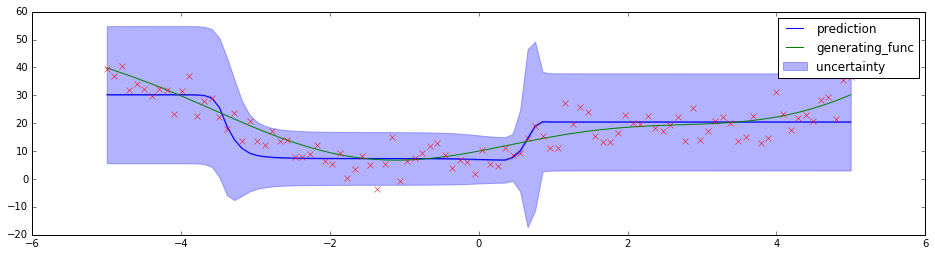

RSME is 5.384937763214111
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 16.097253799438477
COVERAGE/MEAN_VAR is 0.06150117357499416
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.058151249, 0.5655022691969529)


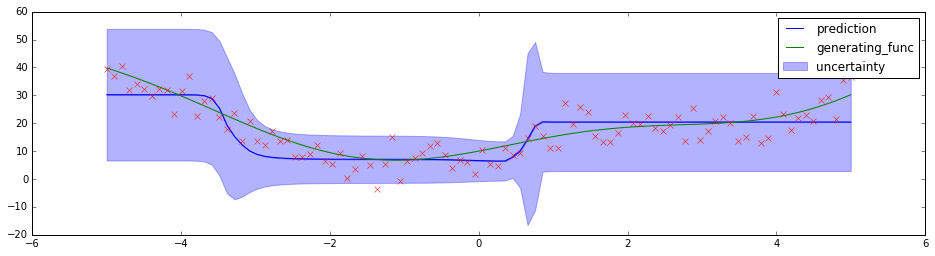

RSME is 5.334941387176514
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 15.689034461975098
COVERAGE/MEAN_VAR is 0.0631013975015113
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.077849507, 0.4413729285466339)


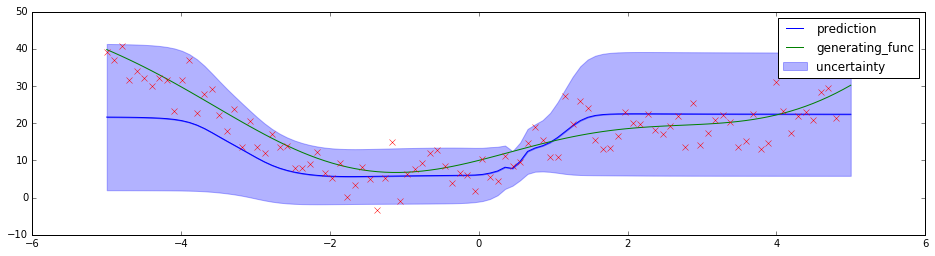

RSME is 6.811187744140625
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 12.940996170043945
COVERAGE/MEAN_VAR is 0.07572832779817383
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.4579643, 1.6606450071369853e-06)


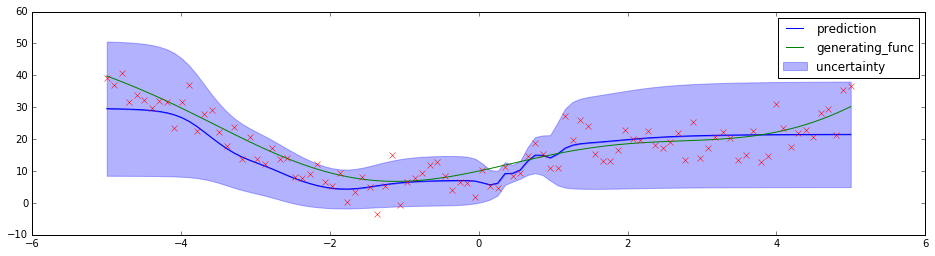

RSME is 5.1610636711120605
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 12.386650085449219
COVERAGE/MEAN_VAR is 0.07831011559287311
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.26446068, 0.007840244947731858)


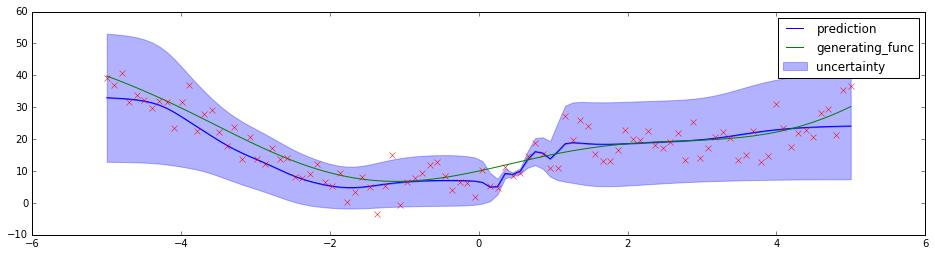

RSME is 4.624680042266846
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 11.364641189575195
COVERAGE/MEAN_VAR is 0.08535245273645618
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.24159898, 0.015452197410162053)


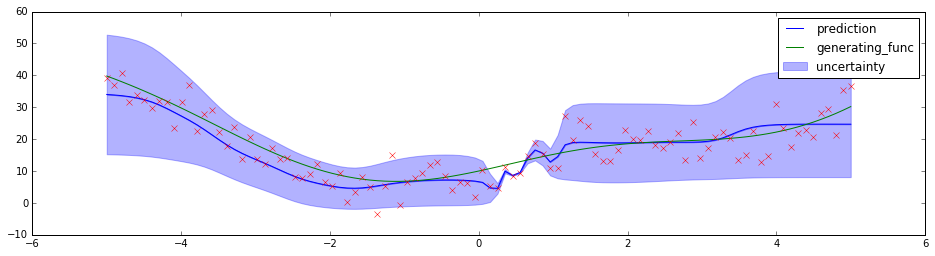

RSME is 4.622216701507568
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 10.824911117553711
COVERAGE/MEAN_VAR is 0.08960812605907173
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.28224397, 0.0044405910800422391)


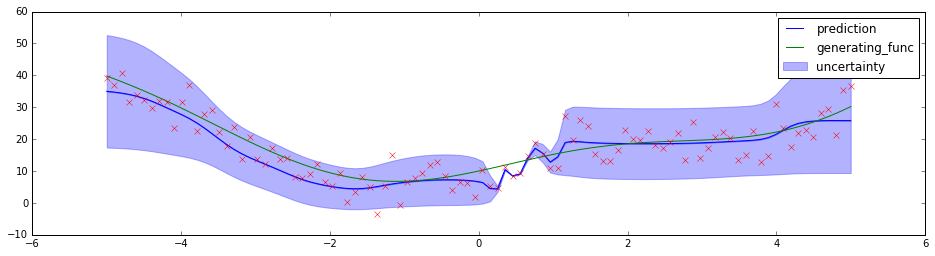

RSME is 4.320122241973877
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 9.893416404724121
COVERAGE/MEAN_VAR is 0.09703422566360378
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.2305223, 0.021031958352650378)


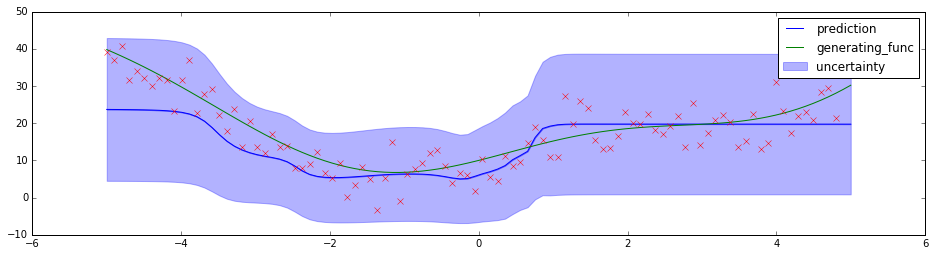

RSME is 6.244300365447998
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 16.32637596130371
COVERAGE/MEAN_VAR is 0.06125058018816731
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.29950735, 0.0024680352402779914)


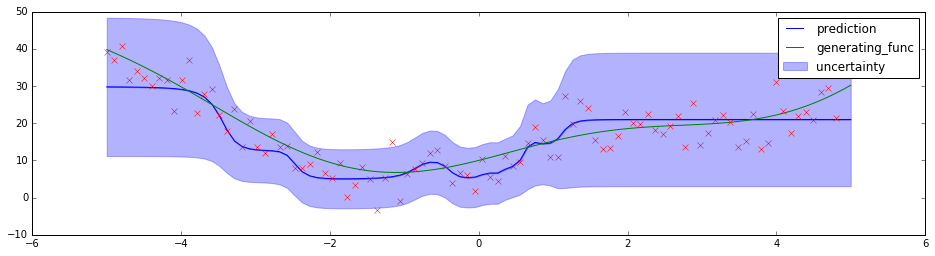

RSME is 4.942005634307861
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 13.752436637878418
COVERAGE/MEAN_VAR is 0.07126009926857471
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.24622586, 0.013532198181080103)


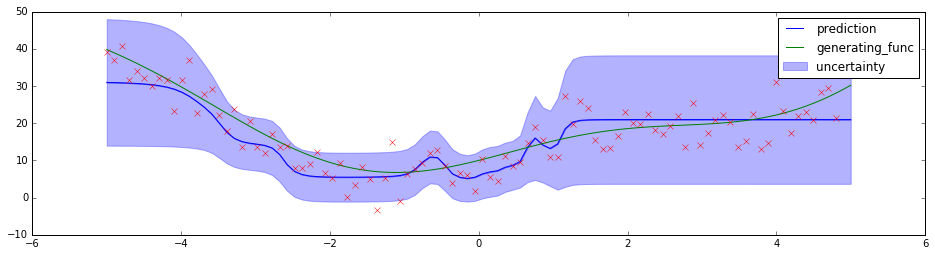

RSME is 4.8614325523376465
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 12.348249435424805
COVERAGE/MEAN_VAR is 0.07693398201648152
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.24873644, 0.012579961978163891)


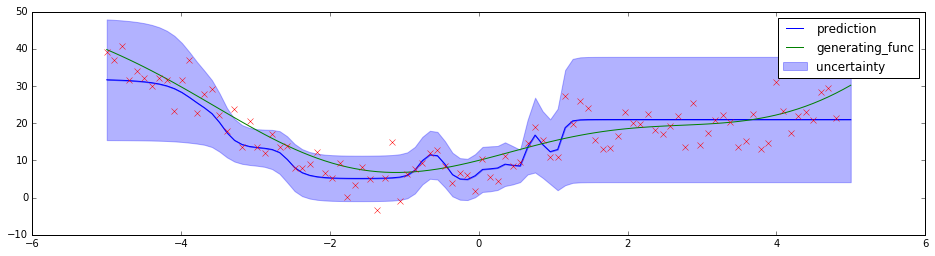

RSME is 4.795564651489258
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 11.566275596618652
COVERAGE/MEAN_VAR is 0.08127075929911308
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.24547128, 0.013830392210037332)


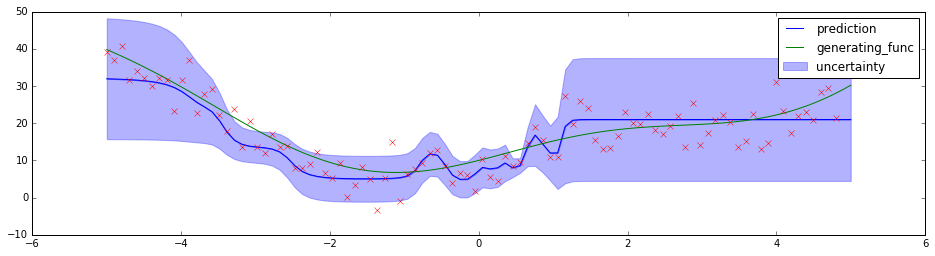

RSME is 4.747904300689697
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 11.151289939880371
COVERAGE/MEAN_VAR is 0.084295180653341
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.25472188, 0.01054189546460263)


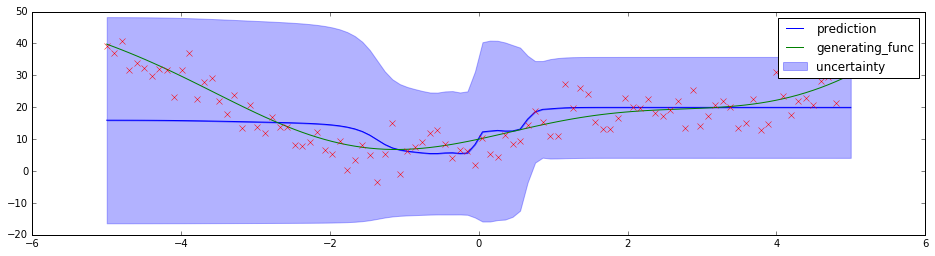

RSME is 8.512395858764648
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 22.825231552124023
COVERAGE/MEAN_VAR is 0.043373053970524766
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.43065435, 7.7331302281697247e-06)


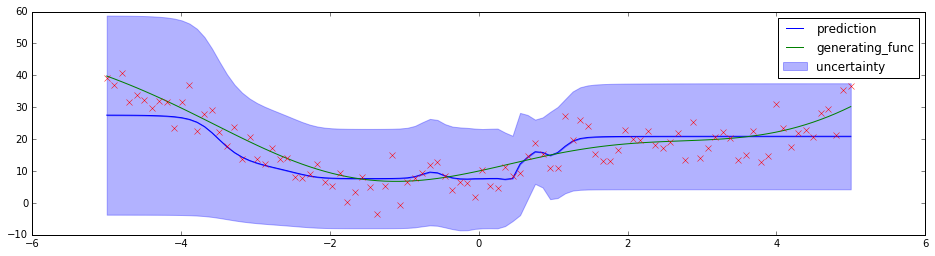

RSME is 5.33347749710083
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 18.48763084411621
COVERAGE/MEAN_VAR is 0.054090218937828664
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.21450494, 0.032105608525830769)


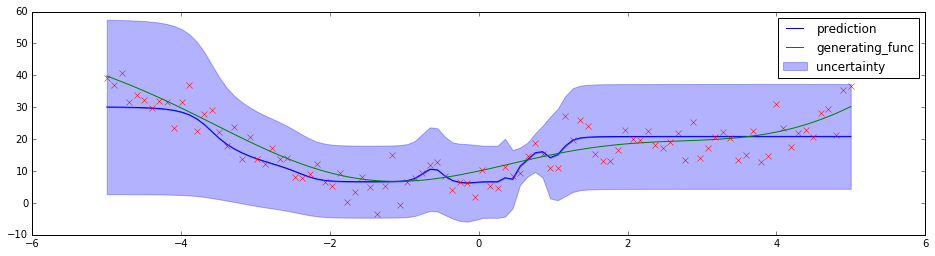

RSME is 4.922778606414795
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 15.883514404296875
COVERAGE/MEAN_VAR is 0.06295835887109945
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.17464112, 0.082239671966783418)


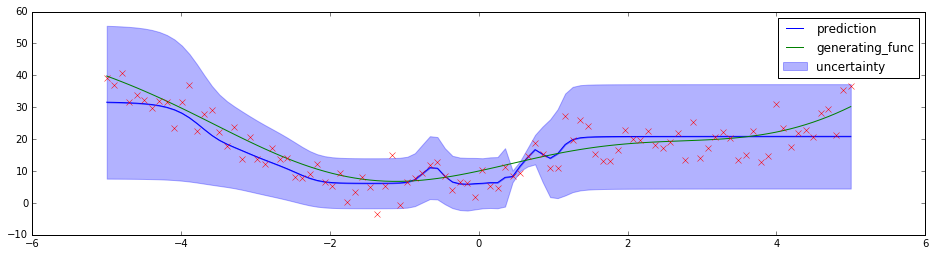

RSME is 4.822782039642334
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 13.696693420410156
COVERAGE/MEAN_VAR is 0.07082001255533342
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.20820999, 0.03763914710894338)


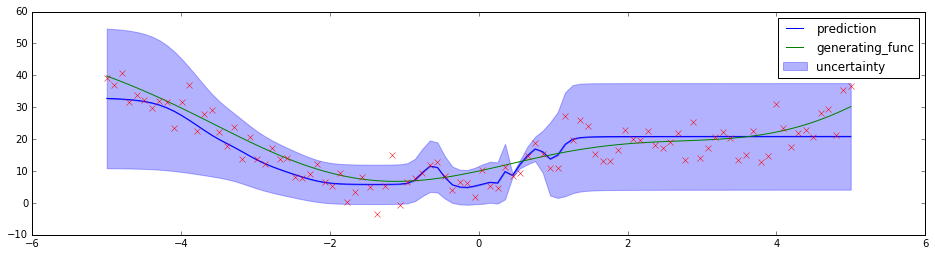

RSME is 4.790528774261475
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 12.615645408630371
COVERAGE/MEAN_VAR is 0.0760959878710021
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.21598475, 0.030909512325894135)


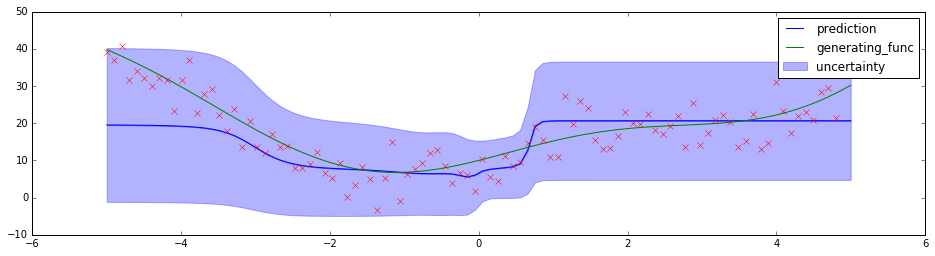

RSME is 7.076306343078613
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 15.19091510772705
COVERAGE/MEAN_VAR is 0.06451224255091194
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.5199548, 2.9562988500706743e-08)


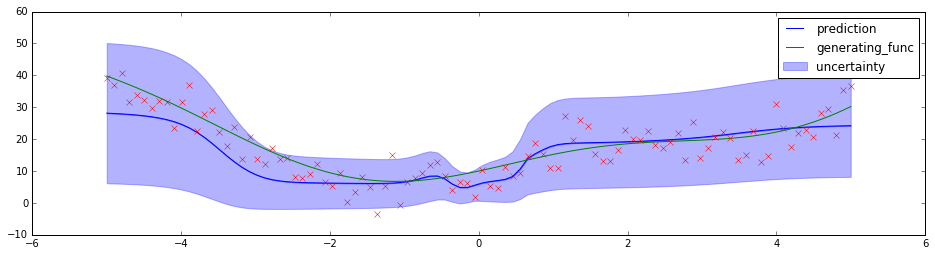

RSME is 5.572881698608398
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 13.025995254516602
COVERAGE/MEAN_VAR is 0.07446647884073691
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.33164164, 0.0007499241447855437)


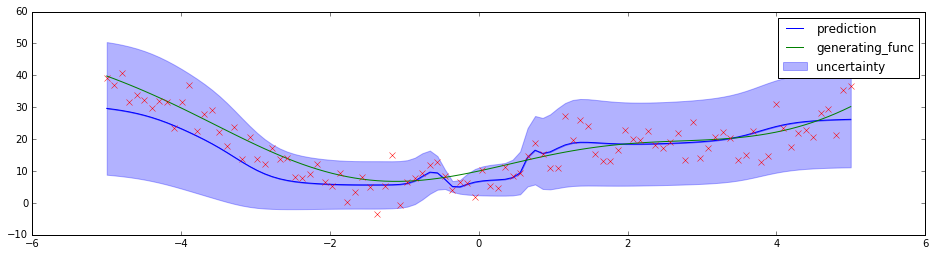

RSME is 5.296955108642578
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 12.031556129455566
COVERAGE/MEAN_VAR is 0.08062132525195582
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.38473079, 7.744100987313316e-05)


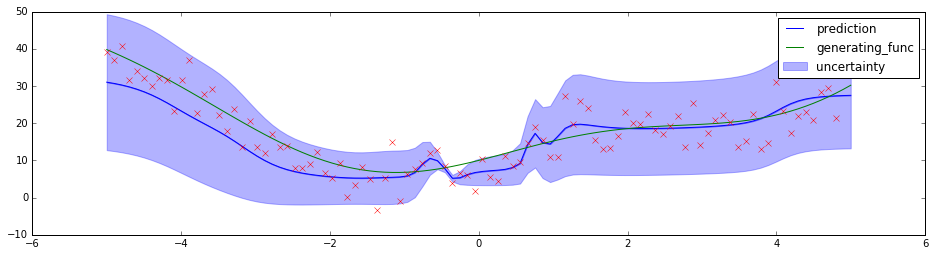

RSME is 4.993492603302002
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 11.174948692321777
COVERAGE/MEAN_VAR is 0.08501157599522025
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.3563619, 0.00027364739384494295)


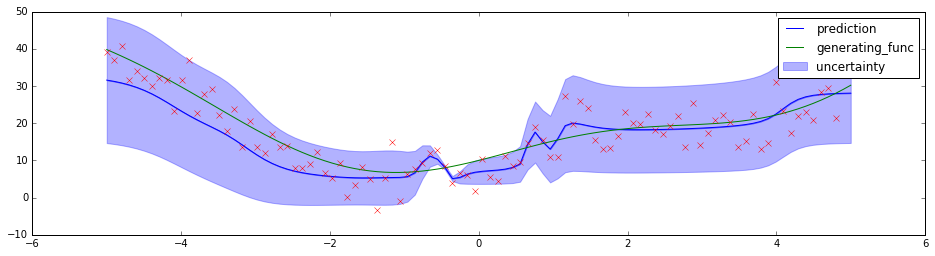

RSME is 4.874034881591797
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 10.48702621459961
COVERAGE/MEAN_VAR is 0.08963456186381706
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.34885976, 0.00037486253316235325)


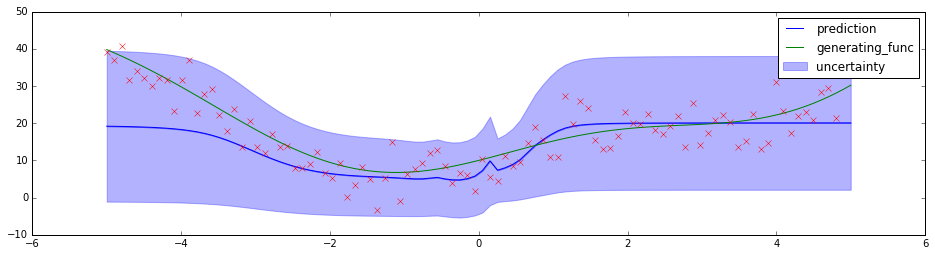

RSME is 7.301342010498047
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 15.49258804321289
COVERAGE/MEAN_VAR is 0.0639015248607031
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.44152111, 4.2601199969102379e-06)


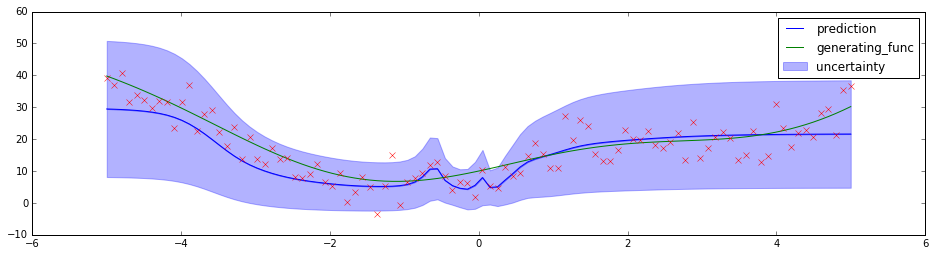

RSME is 5.254410266876221
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 13.586644172668457
COVERAGE/MEAN_VAR is 0.07212965818089317
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.27127215, 0.0063333133973266656)


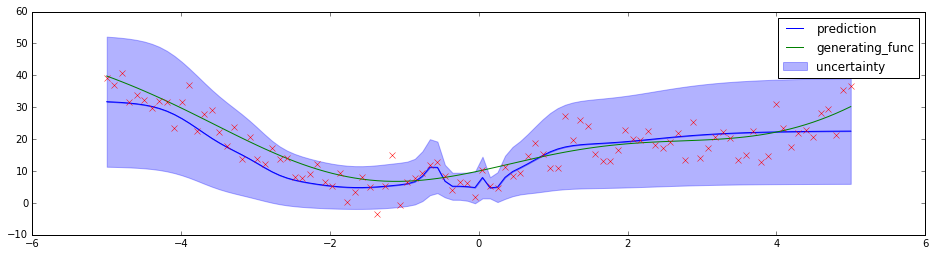

RSME is 4.952974796295166
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 12.601715087890625
COVERAGE/MEAN_VAR is 0.07776719225637088
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.24841437, 0.012698760273683189)


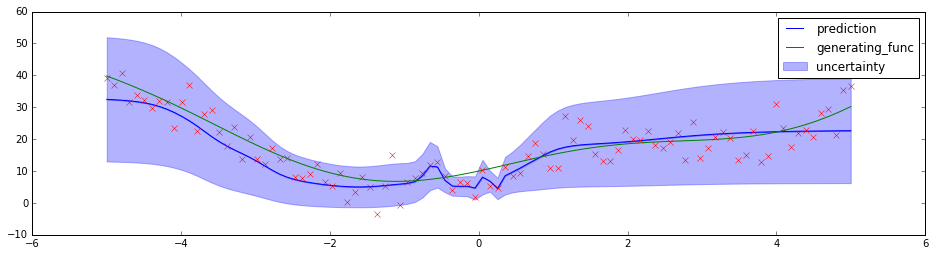

RSME is 4.8330302238464355
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 12.005804061889648
COVERAGE/MEAN_VAR is 0.08079425542843044
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.25073799, 0.011863170895759034)


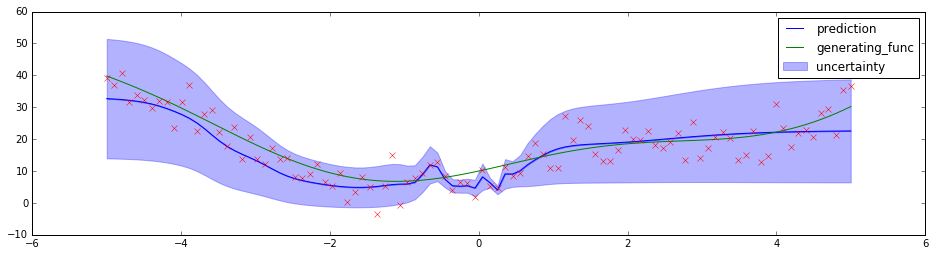

RSME is 4.747417449951172
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 11.210195541381836
COVERAGE/MEAN_VAR is 0.08563632957660831
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.26911774, 0.0067795211193271534)


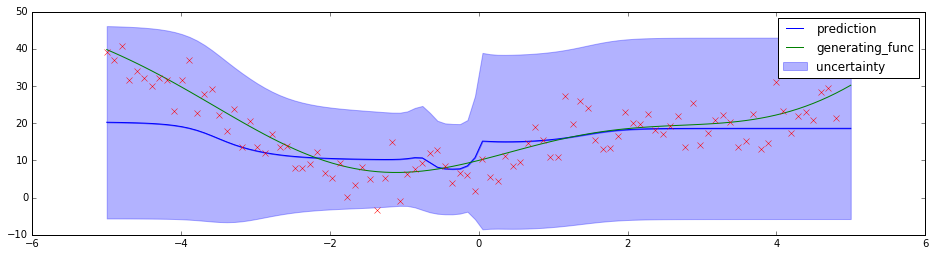

RSME is 7.580205917358398
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 21.028093338012695
COVERAGE/MEAN_VAR is 0.04707987472218259
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.27949956, 0.0048593552178068595)


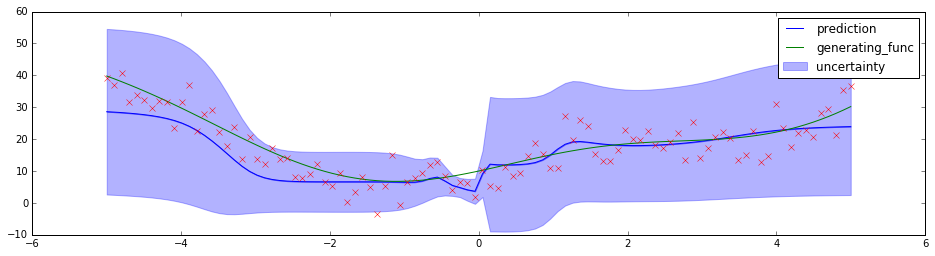

RSME is 5.499345302581787
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 16.695528030395508
COVERAGE/MEAN_VAR is 0.05929731591583255
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.25712359, 0.0098092201190006188)


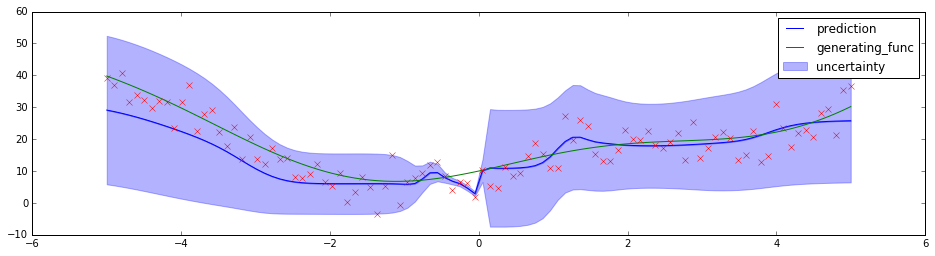

RSME is 5.4379658699035645
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 14.364204406738281
COVERAGE/MEAN_VAR is 0.06613662498107815
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.3854641, 7.4837787537163631e-05)


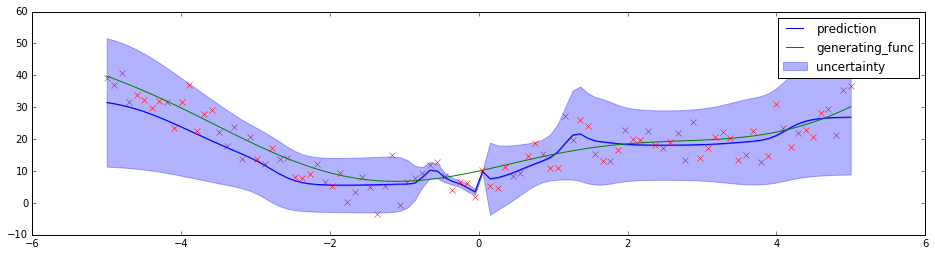

RSME is 4.790122985839844
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 11.337724685668945
COVERAGE/MEAN_VAR is 0.08202704032631292
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.3147642, 0.0014249340037595954)


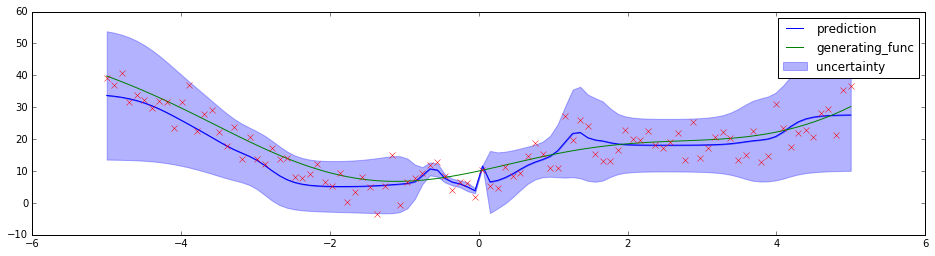

RSME is 4.49486780166626
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 10.319244384765625
COVERAGE/MEAN_VAR is 0.09012287773443622
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.25495759, 0.010467928271425985)


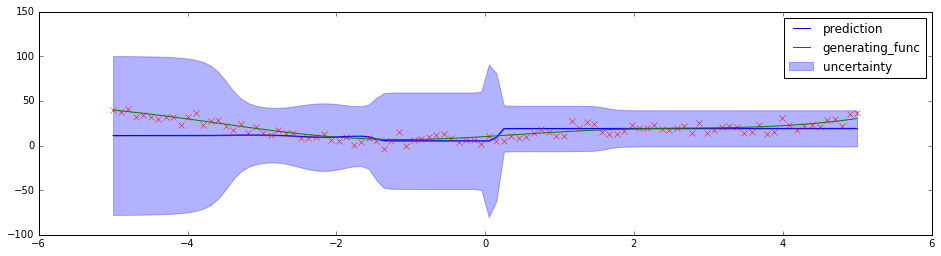

RSME is 9.968079566955566
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 40.271060943603516
COVERAGE/MEAN_VAR is 0.024831727214746642
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.68960088, 2.1255925666821266e-15)


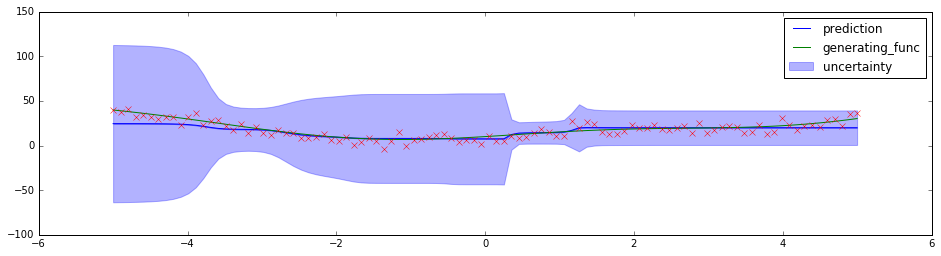

RSME is 5.984496116638184
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 36.489749908447266
COVERAGE/MEAN_VAR is 0.027404956255085294
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.30577374, 0.0019764483345447456)


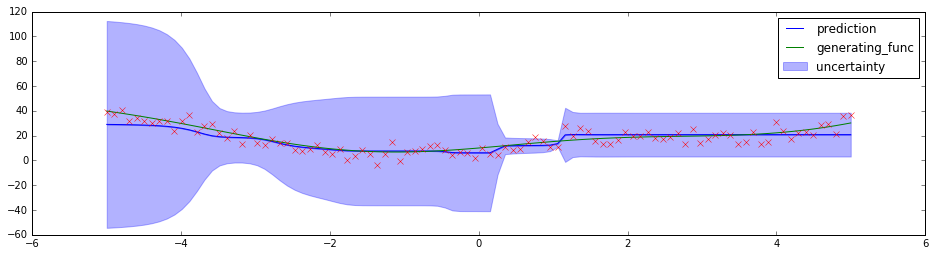

RSME is 5.240464210510254
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 31.944799423217773
COVERAGE/MEAN_VAR is 0.03099095996453366
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.092087746, 0.36217002652828456)


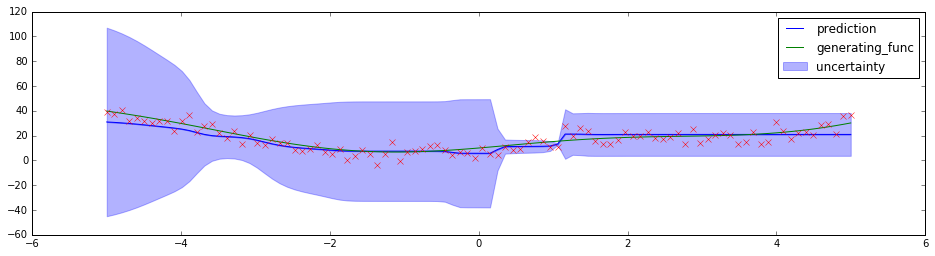

RSME is 5.144306659698486
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 28.491104125976562
COVERAGE/MEAN_VAR is 0.03439670135867048
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.03031682, 0.76461543707553181)


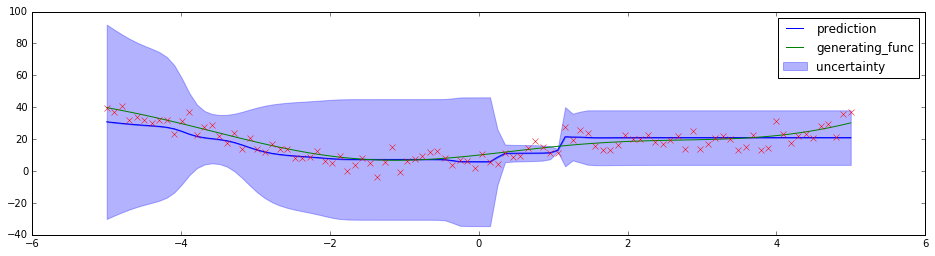

RSME is 5.201661109924316
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 26.035011291503906
COVERAGE/MEAN_VAR is 0.03764161993353184
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.0095589589, 0.92479941057648052)


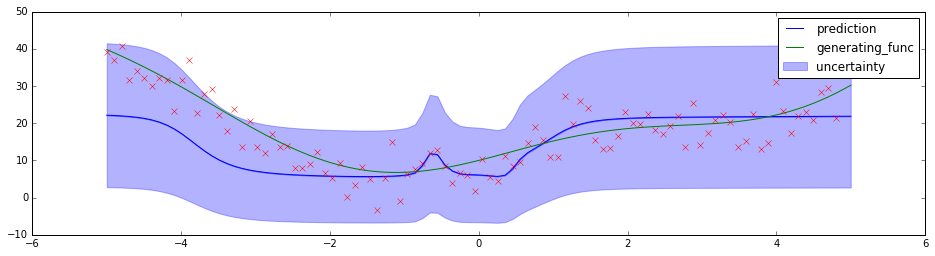

RSME is 7.58364725112915
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 16.212987899780273
COVERAGE/MEAN_VAR is 0.05921178785392237
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.15700708, 0.11875436043156505)


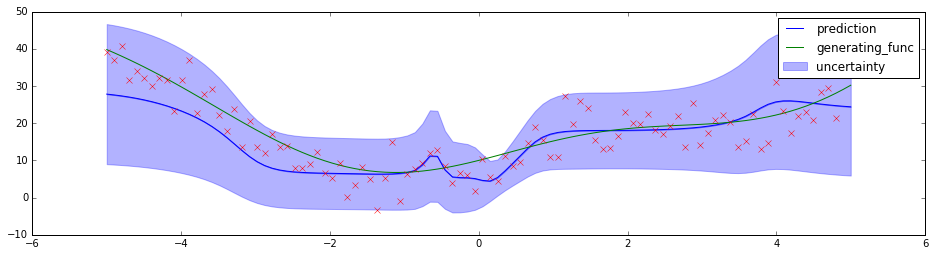

RSME is 5.637457847595215
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 12.368169784545898
COVERAGE/MEAN_VAR is 0.0800441793123677
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.41911024, 1.4250432317033733e-05)


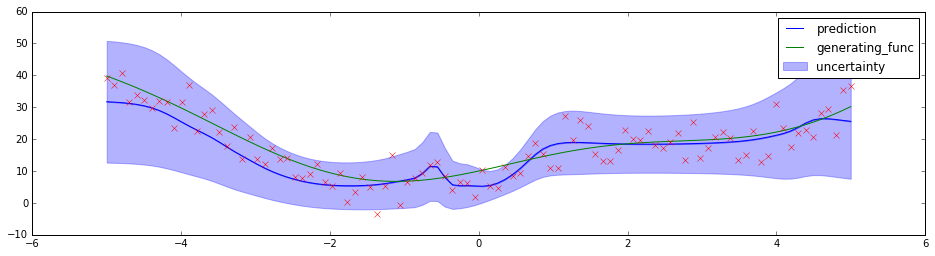

RSME is 4.724940776824951
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 10.855423927307129
COVERAGE/MEAN_VAR is 0.08935625236707129
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.26932064, 0.0067363437623397327)


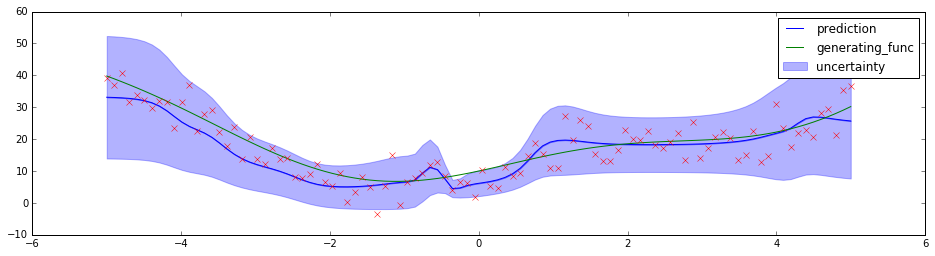

RSME is 4.671929836273193
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 10.359353065490723
COVERAGE/MEAN_VAR is 0.09266987947326272
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.26085696, 0.0087589115165098274)


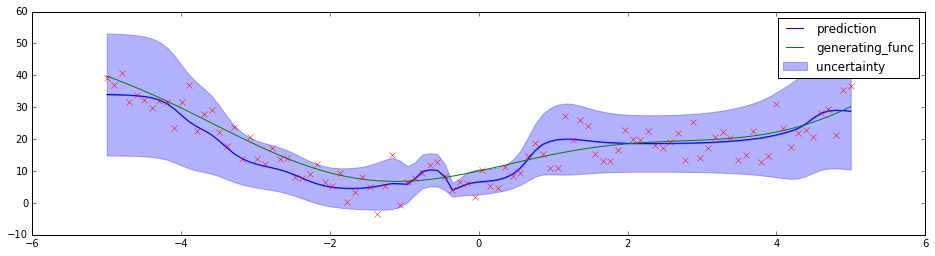

RSME is 4.427102565765381
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 10.065454483032227
COVERAGE/MEAN_VAR is 0.09438222601885053
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.2169435, 0.030154850461513779)


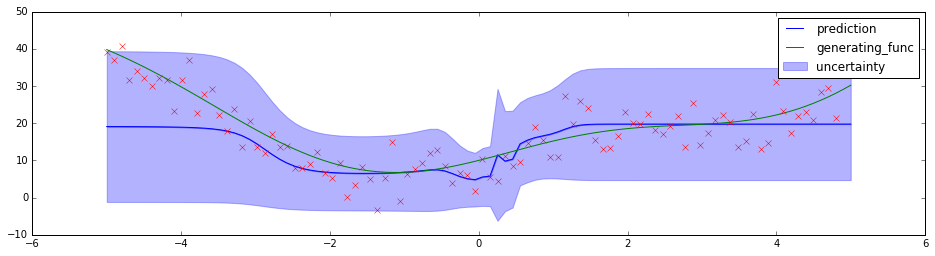

RSME is 7.117660045623779
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 14.327437400817871
COVERAGE/MEAN_VAR is 0.06770226753492067
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.52195179, 2.5610737158962547e-08)


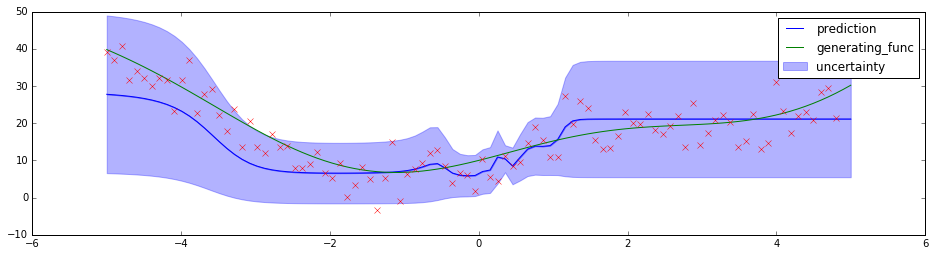

RSME is 5.98281192779541
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 12.762459754943848
COVERAGE/MEAN_VAR is 0.07522060938355717
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.30358446, 0.0021371043119456624)


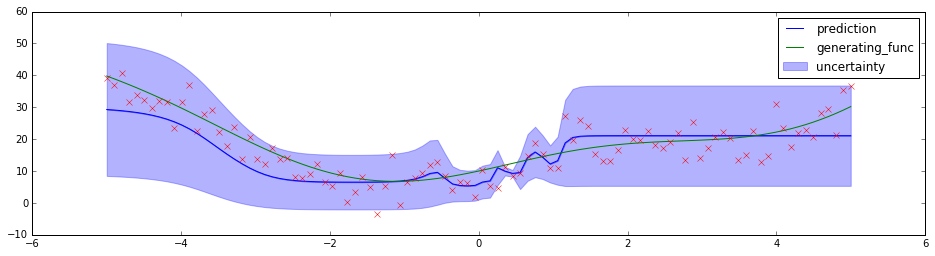

RSME is 5.523975849151611
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 12.805716514587402
COVERAGE/MEAN_VAR is 0.07652832224449531
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.29160044, 0.0032442098590588372)


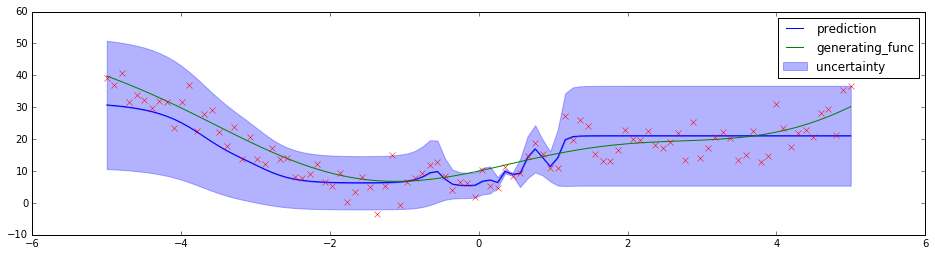

RSME is 5.181025505065918
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 12.529993057250977
COVERAGE/MEAN_VAR is 0.0750199936827604
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.28275681, 0.0043660098161424268)


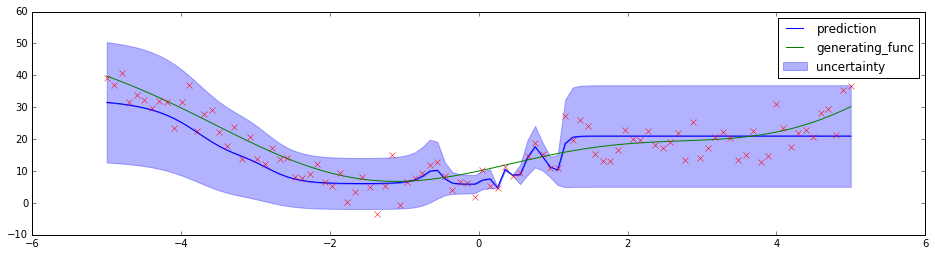

RSME is 5.086922645568848
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 12.123945236206055
COVERAGE/MEAN_VAR is 0.07670770379453025
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.27649167, 0.0053584069733477544)


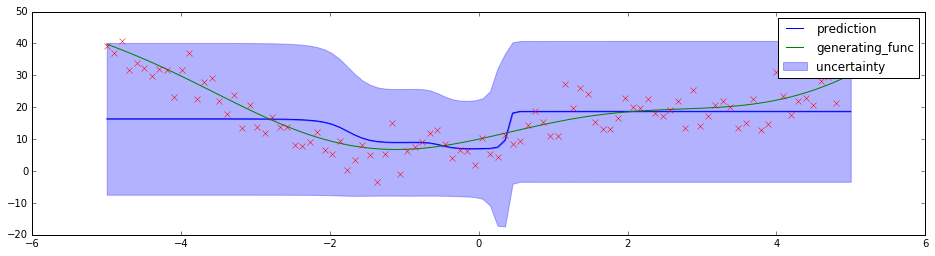

RSME is 8.407727241516113
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 21.573348999023438
COVERAGE/MEAN_VAR is 0.04588995431561481
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.27870578, 0.0049868639057009823)


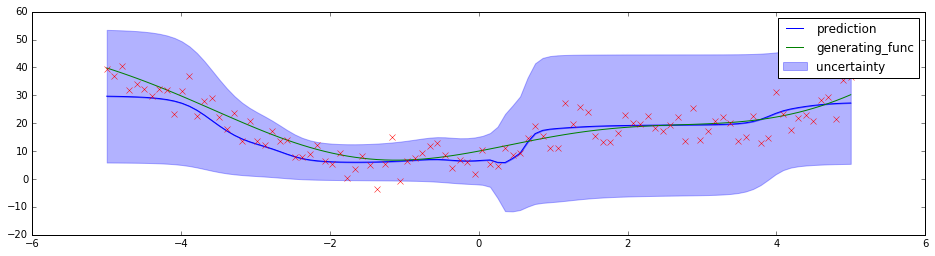

RSME is 4.8246307373046875
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 17.93734359741211
COVERAGE/MEAN_VAR is 0.054077126567389035
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.14599361, 0.14723735697828286)


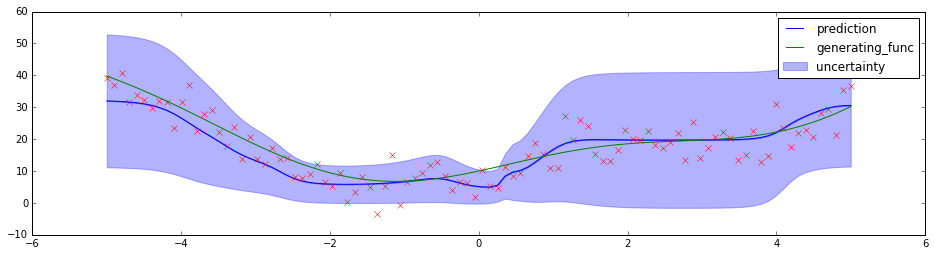

RSME is 4.635499000549316
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 14.466669082641602
COVERAGE/MEAN_VAR is 0.06566819179820009
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.1492448, 0.13834086007926127)


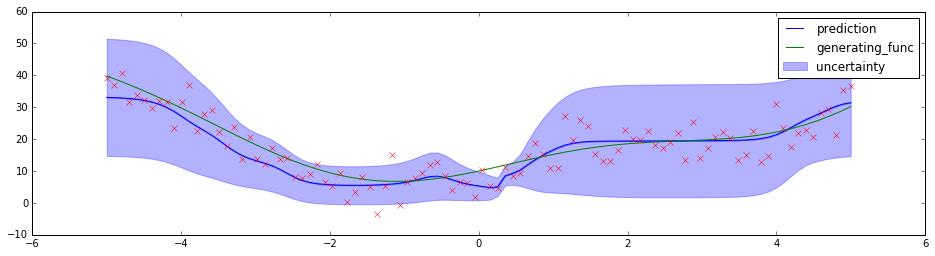

RSME is 4.426417827606201
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 12.36695671081543
COVERAGE/MEAN_VAR is 0.07681760535065062
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.15261409, 0.12955779030553541)


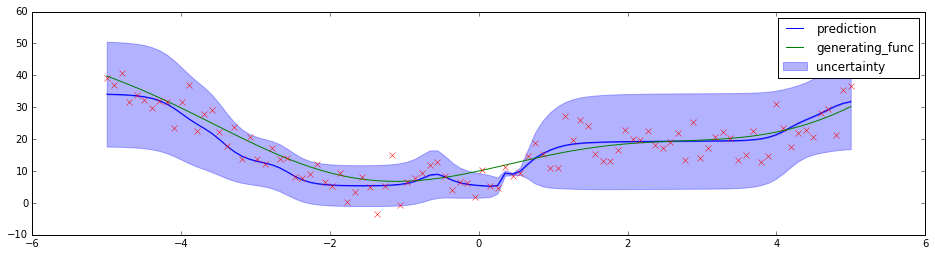

RSME is 4.327600955963135
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 10.868534088134766
COVERAGE/MEAN_VAR is 0.08648820460766671
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.17148893, 0.088009690050099801)


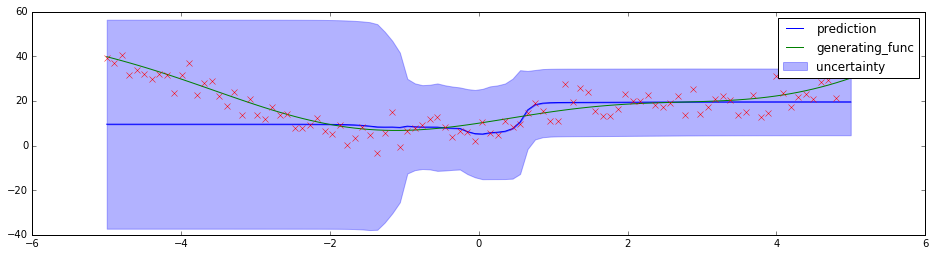

RSME is 10.364843368530273
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 28.314443588256836
COVERAGE/MEAN_VAR is 0.03461131054704696
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.48188195, 3.8530335978496084e-07)


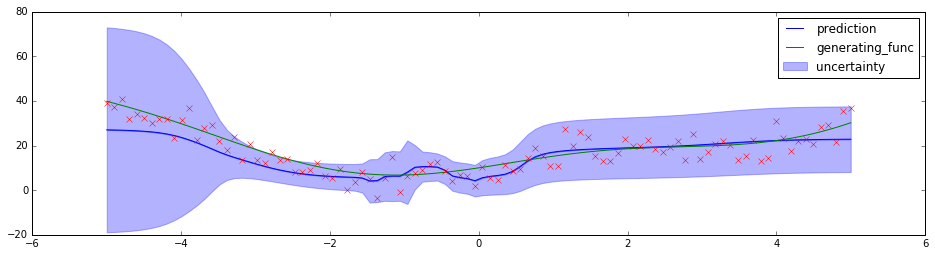

RSME is 5.52070951461792
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 15.089439392089844
COVERAGE/MEAN_VAR is 0.06428336897051931
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.42338967, 1.1390676307115233e-05)


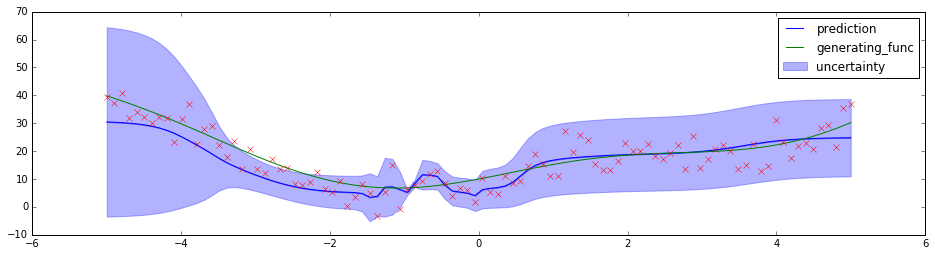

RSME is 5.053378105163574
COVERAGE PROBABILITY is 0.92
MEAN VARIANCE is 12.654807090759277
COVERAGE/MEAN_VAR is 0.07269964634006924
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.23805089, 0.017080370430859963)


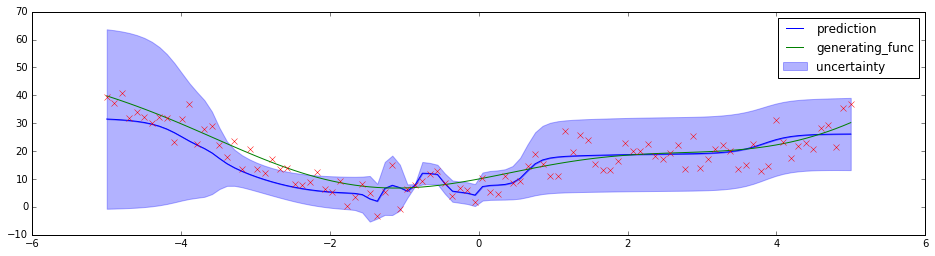

RSME is 4.9095139503479
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 11.889505386352539
COVERAGE/MEAN_VAR is 0.07906132084173882
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.19795014, 0.048359495378606225)


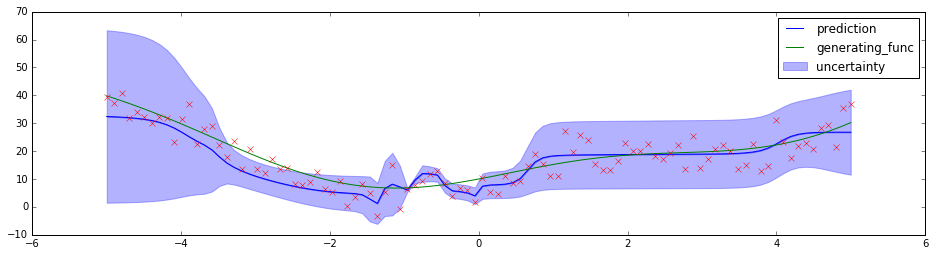

RSME is 4.654905796051025
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 11.429983139038086
COVERAGE/MEAN_VAR is 0.08136494942181219
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.17392541, 0.083522503716417021)


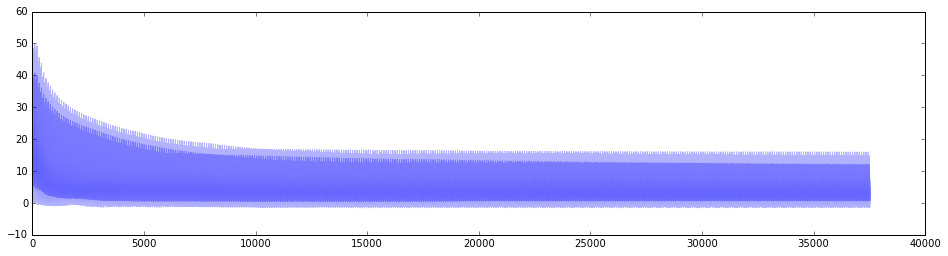

In [26]:
import numpy as np

#num_epochs = 15#10
#num_eps = 25#75
seed = 43#43 is cool 101 1011
params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}


errors_meta_lr = []


bad_seeds = [2,4]
for i in range(n_samples):
    silent = False
    if i == n_samples:
        silent = True
    if not i in bad_seeds:
        params['seed'] = seed+i
    else:
        params['seed'] = seed + 100+i
    lr_tmp = GaussianLearningRateEstimator(**params)

    errors = train_and_plot(lr_tmp,X,y,sorted_index,generating_func=generate_sinoid,
                   num_eps=num_eps,silent=silent)
    errors_meta_lr.append(errors)
    
    
    
plot_error_tmp(np.mean(errors_meta_lr,axis=0).flatten(),np.std(errors_meta_lr,axis=0).flatten())

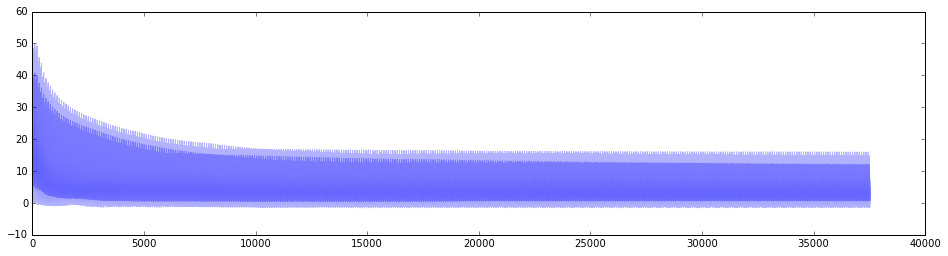

In [27]:
plot_error_tmp(np.mean(errors_meta_lr,axis=0).flatten(),np.std(errors_meta_lr,axis=0).flatten())

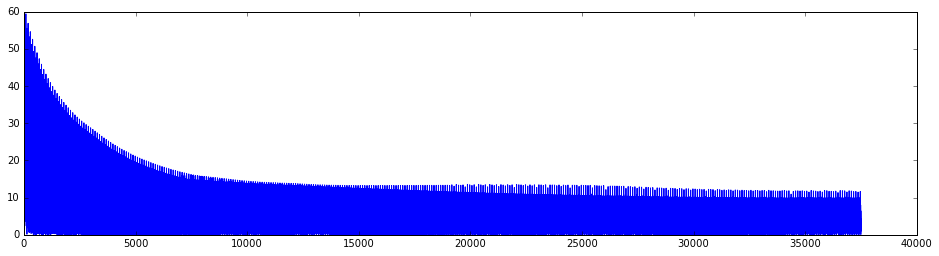

In [28]:
plt.plot(errors_meta_lr[19])

### Example of bad seed
As we can see, the GaussianLossEstimator does not cope well with bad initialisations; as soon as the learning rate is being changed, it seems that (at least for the initialisations that should be equally problematic), the issue disappears. No clue why. Points towards initialisation scheme having a big-ish impact 

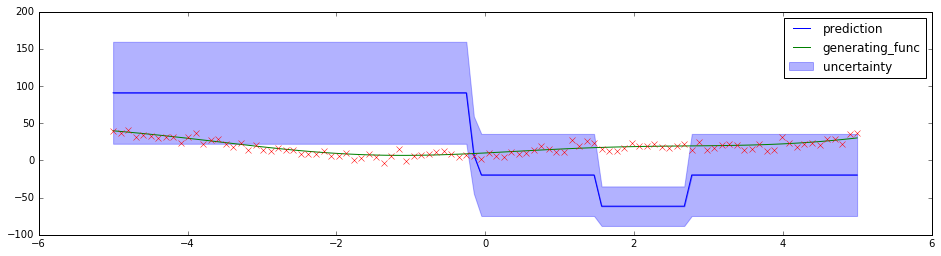

RSME is 63.683773040771484
COVERAGE PROBABILITY is 0.55
MEAN VARIANCE is 58.101192474365234
COVERAGE/MEAN_VAR is 0.009466242887229293
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.066068538, 0.51369629837387931)


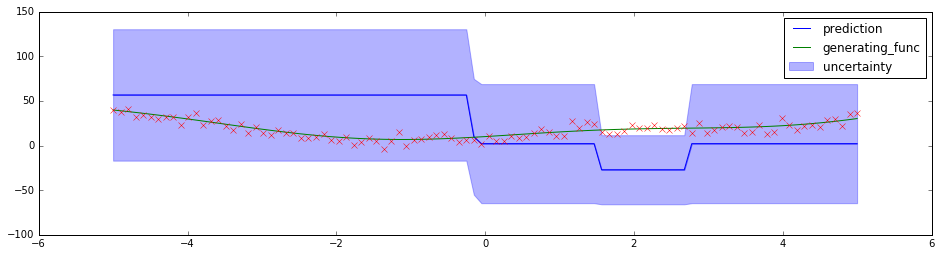

RSME is 34.75828552246094
COVERAGE PROBABILITY is 0.88
MEAN VARIANCE is 66.63505554199219
COVERAGE/MEAN_VAR is 0.013206261971905166
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.11293438, 0.26325597215146279)


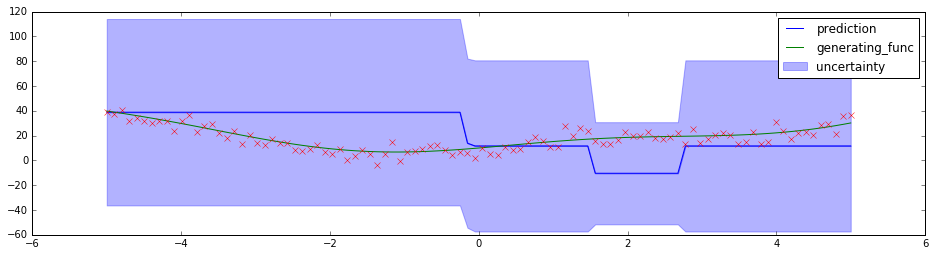

RSME is 21.075666427612305
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 68.62162780761719
COVERAGE/MEAN_VAR is 0.01457266509042208
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.16407412, 0.10285071240201804)


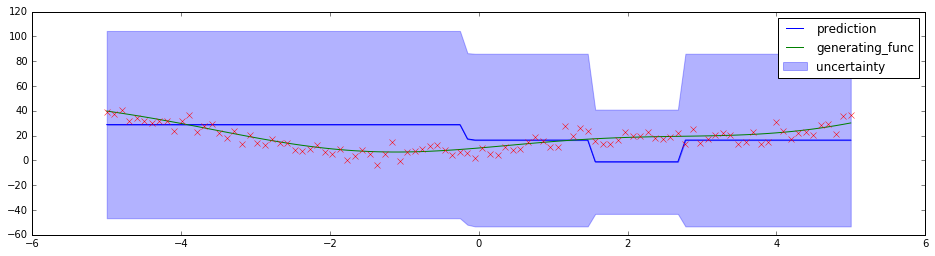

RSME is 14.543099403381348
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 69.1328353881836
COVERAGE/MEAN_VAR is 0.014464906500434426
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.16191575, 0.10752019220023136)


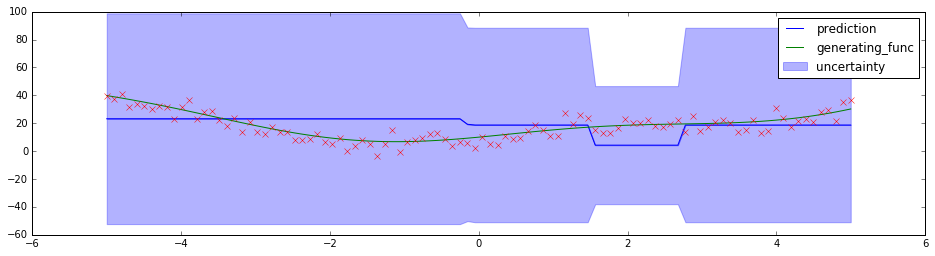

RSME is 11.762190818786621
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 69.2126693725586
COVERAGE/MEAN_VAR is 0.014448221822181006
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.083746515, 0.40744812749593873)


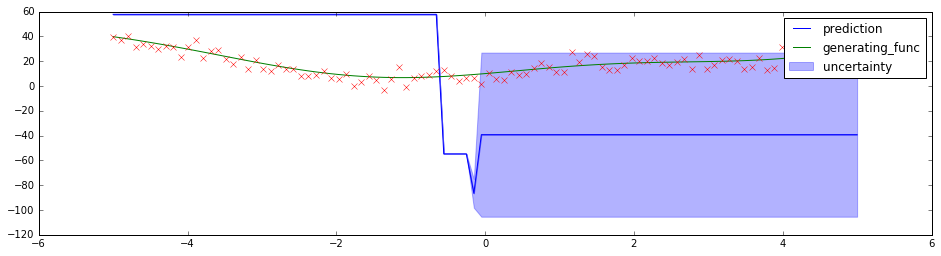

RSME is 52.352970123291016
COVERAGE PROBABILITY is 0.45
MEAN VARIANCE is 33.8643913269043
COVERAGE/MEAN_VAR is 0.01328829435190491
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.50534302, 8.2187819677147929e-08)


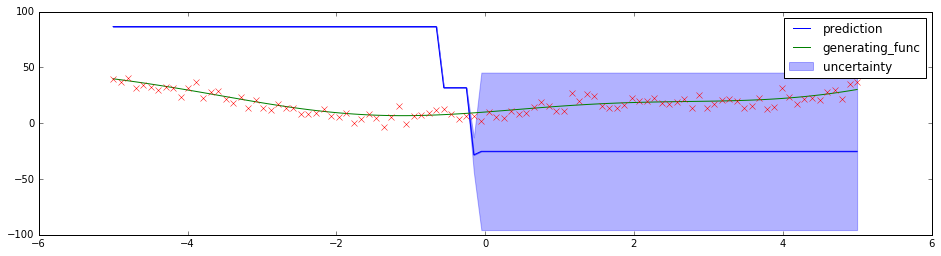

RSME is 56.47471618652344
COVERAGE PROBABILITY is 0.51
MEAN VARIANCE is 36.131263732910156
COVERAGE/MEAN_VAR is 0.014115199616875471
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.65758073, 1.0699241598478159e-13)


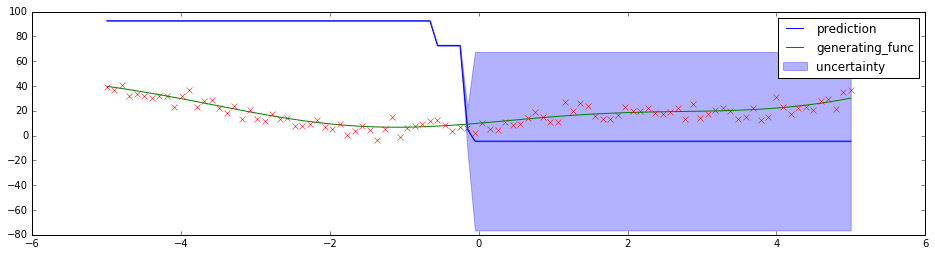

RSME is 54.76667404174805
COVERAGE PROBABILITY is 0.52
MEAN VARIANCE is 36.878047943115234
COVERAGE/MEAN_VAR is 0.014100529420703214
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.88599384, 1.768348355624125e-34)


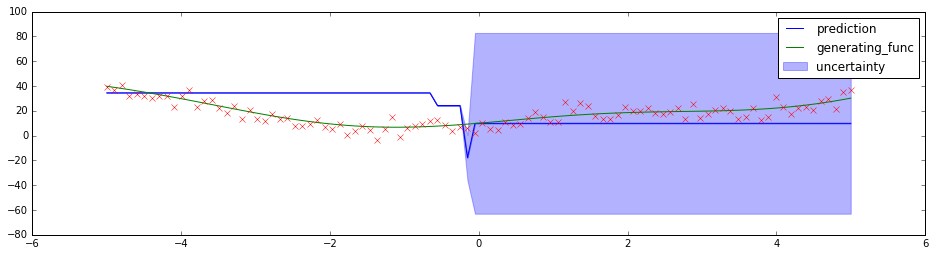

RSME is 16.392833709716797
COVERAGE PROBABILITY is 0.51
MEAN VARIANCE is 37.357460021972656
COVERAGE/MEAN_VAR is 0.013651891742640738
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.46139967, 1.3554222441575155e-06)


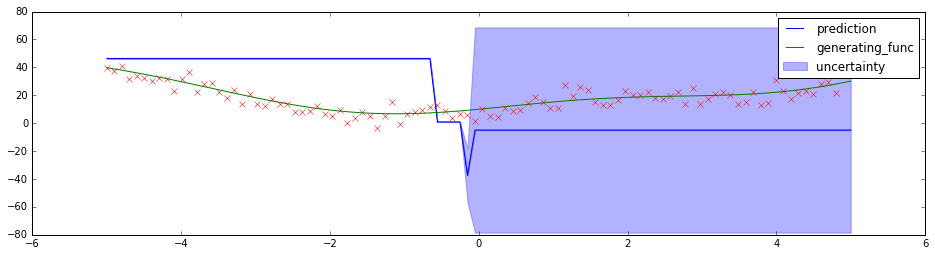

RSME is 27.46111297607422
COVERAGE PROBABILITY is 0.51
MEAN VARIANCE is 37.713531494140625
COVERAGE/MEAN_VAR is 0.01352299770917068
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.2735877, 0.0058829293320211114)


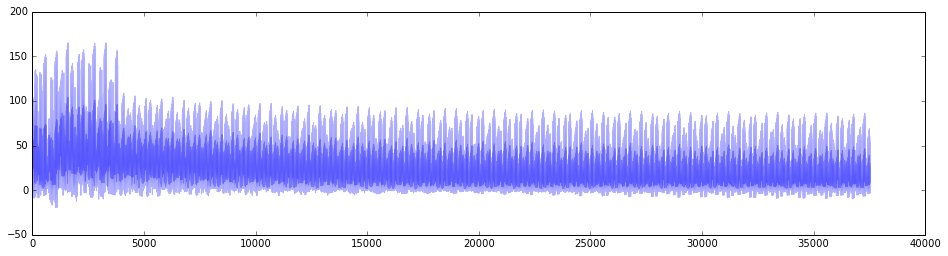

In [29]:
import numpy as np
n_samples = 3
num_epochs = 25#15#10#15
num_eps = 15#25#75
seed = 43#43 is cool 101 1011
params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}


errors_meta = []


#bad_seeds = [2,4,10,13,15,16,9]
#very_bad_seeds = [16,10]
bad_seeds = [1,3]#ignoring the good seeds
very_bad_seeds = []
for i in range(n_samples):
    silent = False
    if i == n_samples - 1:
        silent = True
    if not i in bad_seeds:
        params['seed'] = seed+i
    else:
        if i not in very_bad_seeds:
            params['seed'] = seed + 100+i
        else:
            params['seed'] = seed + 100+i + 42 + i

    gauss_tmp = GaussianLossEstimator(**params)

    errors = train_and_plot(gauss_tmp,X,y,sorted_index,generating_func=generate_sinoid,
                   num_eps=num_eps,silent=silent)
    errors_meta.append(errors)
    
    
    
plot_error_tmp(np.mean(errors_meta,axis=0).flatten(),np.std(errors_meta,axis=0).flatten())

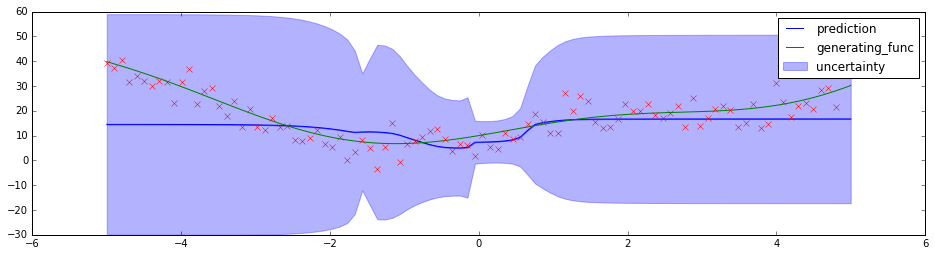

RSME is 9.11553955078125
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 33.667327880859375
COVERAGE/MEAN_VAR is 0.029702386941391993
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.40453857, 2.9874841059873533e-05)


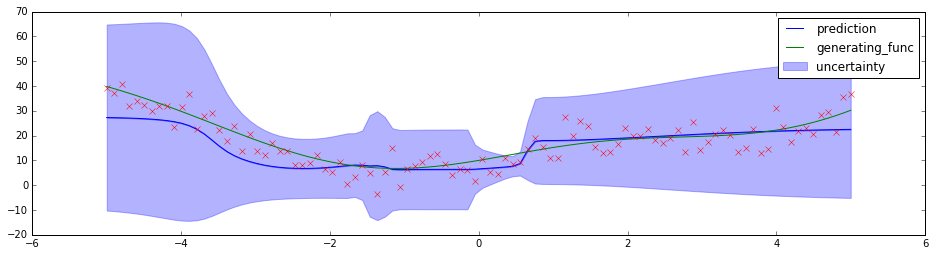

RSME is 5.833017826080322
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 21.2727108001709
COVERAGE/MEAN_VAR is 0.04700858340968779
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.34363288, 0.00046464272092959058)


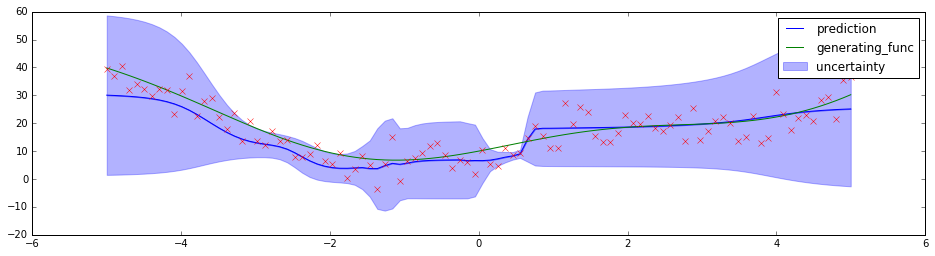

RSME is 4.9217658042907715
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 14.858175277709961
COVERAGE/MEAN_VAR is 0.0625918043513172
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.33550048, 0.00064419974623333817)


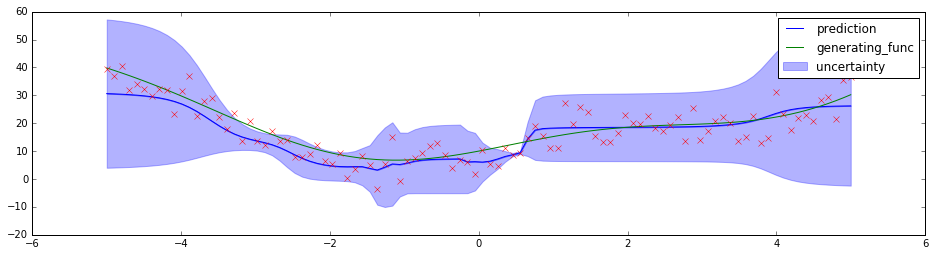

RSME is 4.715564250946045
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 13.491969108581543
COVERAGE/MEAN_VAR is 0.07041225727353276
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.33409637, 0.0006809785014756962)


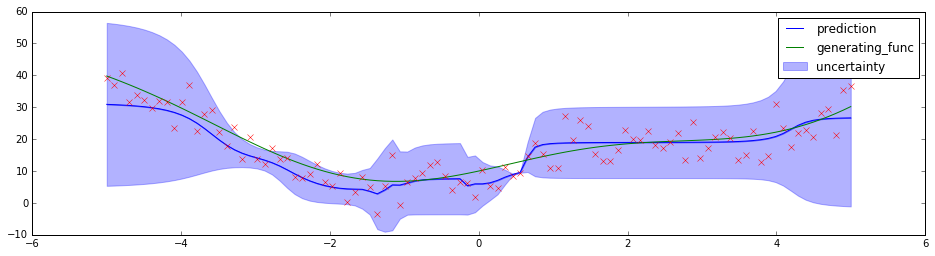

RSME is 4.529601097106934
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 12.284672737121582
COVERAGE/MEAN_VAR is 0.07570409240042222
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.31465495, 0.0014306977324523335)


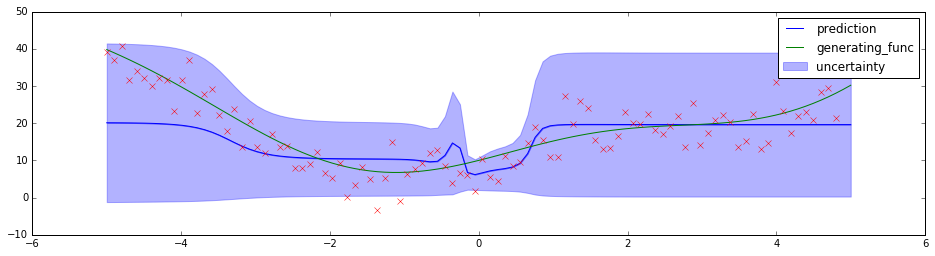

RSME is 7.292265892028809
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 15.550963401794434
COVERAGE/MEAN_VAR is 0.061732509761371124
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.34471232, 0.00044462516165909576)


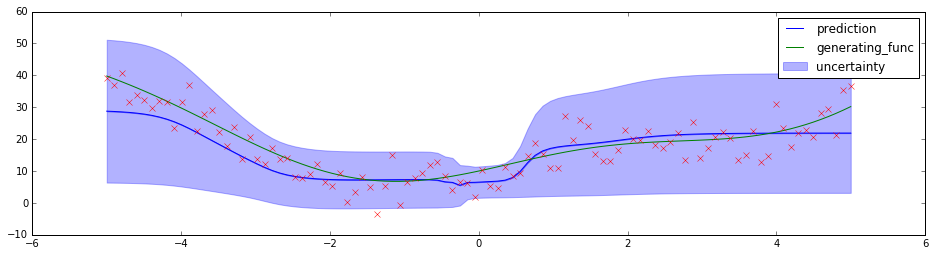

RSME is 5.442487716674805
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 14.381004333496094
COVERAGE/MEAN_VAR is 0.06884081090874174
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.29350924, 0.0030390624492509376)


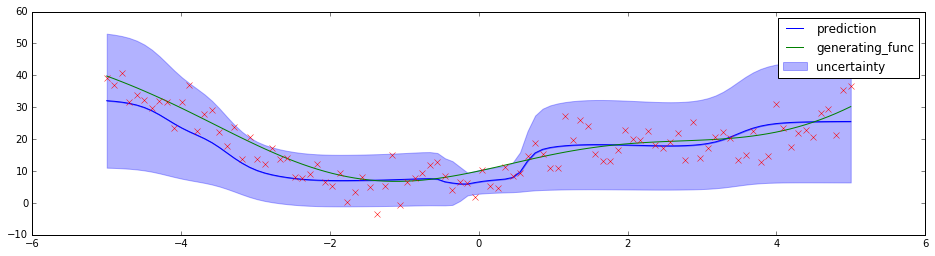

RSME is 5.261099338531494
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 12.592312812805176
COVERAGE/MEAN_VAR is 0.07703112322730761
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.23110689, 0.020699273021650973)


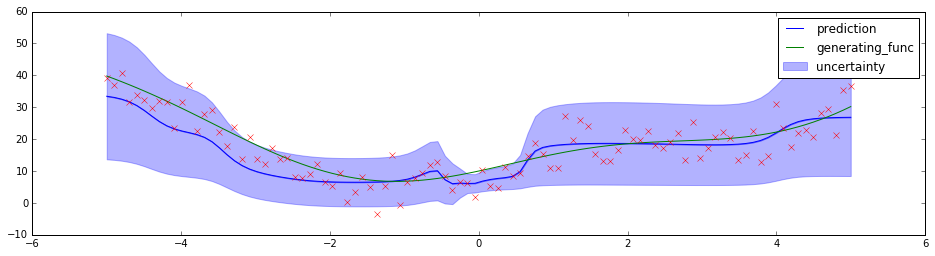

RSME is 5.064192771911621
COVERAGE PROBABILITY is 0.92
MEAN VARIANCE is 11.45169448852539
COVERAGE/MEAN_VAR is 0.08033745581685234
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.19263412, 0.054839297395415272)


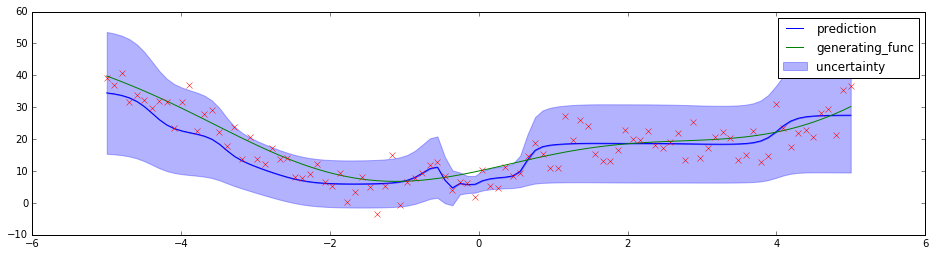

RSME is 4.851399898529053
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 11.062185287475586
COVERAGE/MEAN_VAR is 0.08497416880769947
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.20429939, 0.041463393336487644)


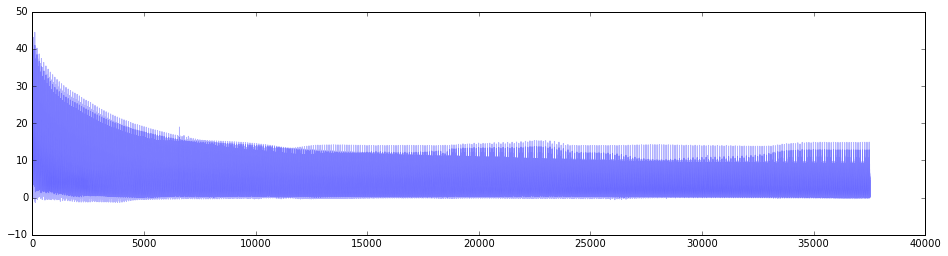

In [30]:
import numpy as np
n_samples = 3
num_epochs = 25#15#10#15
num_eps = 15#25#75
seed = 43#43 is cool 101 1011
params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}


errors_meta = []


#bad_seeds = [2,4,10,13,15,16,9]
#very_bad_seeds = [16,10]
bad_seeds = [1,3]#ignoring the good seeds
very_bad_seeds = []
for i in range(n_samples):
    silent = False
    if i == n_samples - 1:
        silent = True
    if not i in bad_seeds:
        params['seed'] = seed+i
    else:
        if i not in very_bad_seeds:
            params['seed'] = seed + 100+i
        else:
            params['seed'] = seed + 100+i + 42 + i

    gauss_tmp_lr = GaussianLearningRateEstimator(**params)

    errors = train_and_plot(gauss_tmp_lr,X,y,sorted_index,generating_func=generate_sinoid,
                   num_eps=num_eps,silent=silent)
    errors_meta.append(errors)
    
    
    
plot_error_tmp(np.mean(errors_meta,axis=0).flatten(),np.std(errors_meta,axis=0).flatten())

# Old Stuff can probbly be removed only staying for security reasons

In [31]:
gauss.train(X,y)
gauss_lr.train(X,y)
vanilla.train(X,y)

In [32]:
gauss_preds = gauss.predict(X)
gauss_var = gauss.predict_var(X)

lr_preds = gauss_lr.predict(X)
lr_var = gauss_lr.predict_var(X)

vanilla_preds = vanilla.predict(X)

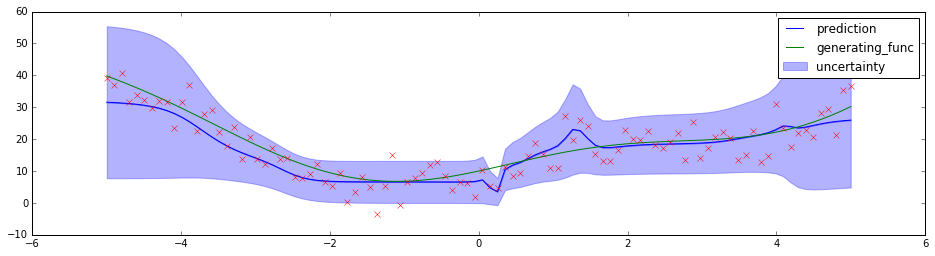

In [33]:
plot_prediction(X,gauss_preds,sorted_index,gauss_var,generating_func=generate_sinoid)
plt.plot(X,y,'x')

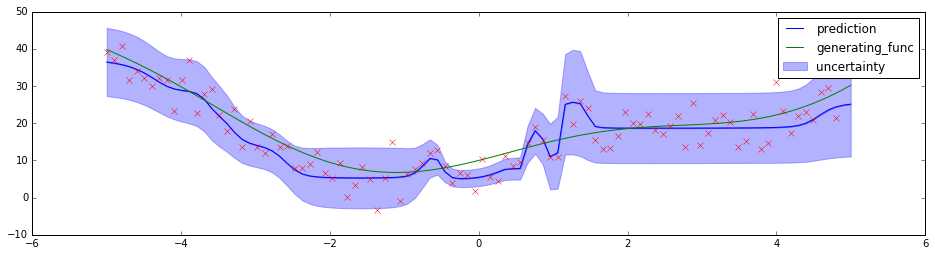

In [34]:
plot_prediction(X,lr_preds,sorted_index,lr_var,generating_func=generate_sinoid)
plt.plot(X,y,'x')

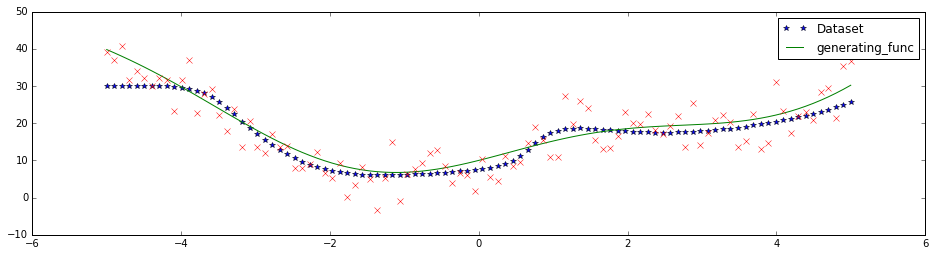

In [35]:
plot_prediction(X,vanilla_preds,sorted_index,generating_func=generate_sinoid)
plt.plot(X,y,'x')

In [36]:
evaluate_model(X,y,gauss_preds,var=gauss_var)

RSME is 4.5595269203186035
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 11.3399076461792
COVERAGE/MEAN_VAR is 0.08553861550422996
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.25558469, 0.010273346839464511)


In [37]:
evaluate_model(X,y,lr_preds,var=lr_var)

RSME is 4.083553314208984
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 8.123705863952637
COVERAGE/MEAN_VAR is 0.11447977260312858
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.30462983, 0.0020589762564638334)


In [38]:
evaluate_model(X,y,vanilla_preds)

RSME is 4.620369911193848


# Other research
https://arxiv.org/pdf/1406.2541.pdf

https://arxiv.org/pdf/1612.01474.pdf